# ECE 763 - Computer Vision - Project 03
## Babysitting the training of a Network - On Face Data.

### mmsardes 

#### Import libraries
<p>Keras Sequential API was used to build the network. The CIFAR datasets was downloaded from keras datasets. 
Babysitting the training of a DNN is important as the final network performance depends a lot on how you set the hyper-parameters, how you initialize the weights, for how long you train the network etc. You don't want to over-train, or over-fit the model as it would lead to loss of generalization. General steps followed while training a DNN are 
1. Pre-process the Data and select Data Augmentation schemes. 
2. Choose architecture of the network 
3. Double check if the loss is reasonable. 
4. Hyperparameter tuning 
    </p>


In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Reshape, BatchNormalization, Activation
from tensorflow.keras import optimizers, regularizers, initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from DataHandling import readDumpImages
from tqdm import tqdm 

#### Import and preprocess the data. 
<p> Preprocessing scheme was standard scaling by subtracting mean and dividing by the standard deviation. A basic preprocessing operation is done by subtracting the mean and dividing by the standard deviation over the dataset. This is basically zero centering the data. This makes the model less sensitive to small changes in weights and makes it easier to optimize. It also reduces the effect of outliers to some extent as the range of the data is restricted. </p>

In [3]:
trainFace, trainNonFace, testFace, testNonFace = readDumpImages()

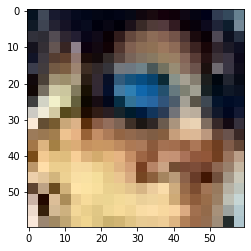

In [4]:
trainFace.shape
X_train=np.vstack((trainFace, trainNonFace))
y_train=np.hstack((np.array([1 for i in range(trainFace.shape[0])]),np.array([0 for i in range(trainFace.shape[0])])))

X_test=np.vstack((testFace, testNonFace))
y_test=np.hstack((np.array([1 for i in range(testFace.shape[0])]),np.array([0 for i in range(testFace.shape[0])])))
X_test.shape
plt.imshow(cv2.cvtColor(X_test[0], cv2.COLOR_BGR2RGB))

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train,y_train=shuffle(X_train, y_train, random_state=42)
X_test,y_test=shuffle(X_test, y_test, random_state=42)
X_train.shape, y_train.shape, y_train

C:\Users\sarde\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\sarde\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\sarde\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\sarde\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


((2000, 60, 60, 3), (2000,), array([0, 1, 0, ..., 1, 0, 0]))

In [6]:
(X_train, y_train), (X_test, y_test)=(X_train.astype('float64'), y_train), (X_test.astype('float64'), y_test)

In [7]:
class_name = ['face','nonface']
num_classes=len(class_name)

In [8]:
def preprocess_data(X_train, X_test):
    X_train-=np.mean(X_train,axis=0)
    X_test-=np.mean(X_test,axis=0)
    X_train/=np.std(X_train,axis=0)
    X_test/=np.std(X_test,axis=0)
    return X_train, X_test
X_train, X_test=preprocess_data(X_train, X_test)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
iRows,iCols=X_train[0].shape[0],X_train[0].shape[1]

### Build the CNN 
<p> Here I have chosen a basic CNN with 3 layers. 32, 64, 128 filters in the three layers. All of them being 3x3 filters with a stride of 1. All the convolutional blocks are followed by 2x2 maxpool blocks. In the end the result is flattened and connected to a FCN with one hidden layer with 128 neurons and a softmax layer with 2 units as there are 2 classes in CIFAR. This can also be replaced by an output layer with a single neuron and sigmoid activation. In this case, we will need to use Binary Cross entropy loss. All the layers have 'relu' activations. The model is created using the Sequential API in Keras. Conditions are added to tweak the network if batchnormalization and dropout is desired.</p> 

In [11]:
#model hyperparam
LEARNING_RATE=1e-2
EPOCHS=10
L2_REG=1e-3
BATCH_SIZE=32

In [14]:
def create_model(num_clases,L2_REG, drop=False, bnorm=False, init='glorot_uniform'):
    model = Sequential()
    if init=='he_uniform':
        if drop==True and bnorm==False:
            model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same',kernel_initializer=init, activation='relu',input_shape = (iRows, iCols,3)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
            model.add(Dropout(DROPOUT))
            model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_initializer=init,kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_initializer=init,kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
            model.add(Dropout(DROPOUT))

            model.add(Flatten())
            model.add(Dense(units = 128, activation='relu', kernel_initializer=init,kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(Dense(units=num_classes,kernel_initializer=init,activation='softmax'))
        elif bnorm==True and drop == False:
            model.add(Conv2D(filters=32, kernel_size=(3,3),kernel_initializer=init, padding= 'same',input_shape = (iRows, iCols,3)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=64, kernel_size=(3,3),kernel_initializer=init, padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same',kernel_initializer=init, kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, kernel_initializer=init,padding='same'))

            model.add(Flatten())
            model.add(Dense(units = 128,kernel_initializer=init, kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Dense(units=num_classes,kernel_initializer=init,activation='softmax'))
        else:
            model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', kernel_initializer=init,activation='relu',input_shape = (iRows, iCols,3)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_initializer=init,kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_initializer=init,kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Flatten())
            model.add(Dense(units = 128, activation='relu', kernel_initializer=init,kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(Dense(units=num_classes,kernel_initializer=init,activation='softmax'))
    else:
        if drop==True and bnorm==False:
            model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = (iRows, iCols,3)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
            model.add(Dropout(DROPOUT))
            model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
            model.add(Dropout(DROPOUT))

            model.add(Flatten())
            model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(Dense(units=num_classes,activation='softmax'))
        elif bnorm==True and drop == False:
            model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same',input_shape = (iRows, iCols,3)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Flatten())
            model.add(Dense(units = 128, kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Dense(units=num_classes,activation='softmax'))
        else:
            model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = (iRows, iCols,3)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

            model.add(Flatten())
            model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
            model.add(Dense(units=num_classes,activation='softmax'))
    return model 

In [33]:
model=create_model(num_classes,L2_REG)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 60, 60, 32)        896       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)            

#### Compile and evaluate the Initial loss as a sanity check 
<p> The initial loss should come up to be around 2.3 for 10 classes with no regularization applied. </p>

In [34]:
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [35]:
model.evaluate(X_train,y_train)

1600/1600 [==============================] - 0s 245us/sample - loss: 0.7073 - sparse_categorical_accuracy: 0.4800


[0.707324982881546, 0.48]

#### Crank up regularization 
Sanity check: If we crank up the regularization we get a higher loss as expected. 

In [36]:
#model hyperparam
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=1e3

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.evaluate(X_train, y_train)

1600/1600 [==============================] - 0s 246us/sample - loss: 379751.1644 - sparse_categorical_accuracy: 0.5006


[379751.164375, 0.500625]

#### Try to overfit a small portion of data. 
We try to overfit the small portion of the data as a sanity check with no regularization and vanilla SGD optimizer. This ensures that our model is actually learning and the loss is going down. We verify this using the training accuracy (It should reach 100% theoretically). We can also see that the model reaches a very small loss as we reach the last epoch. That's a good sanity check. 

In [37]:
#model hyperparam
LEARNING_RATE=1e-3
EPOCHS=100
L2_REG=0

X_tiny=X_train[:20]
y_tiny=y_train[:20]


In [38]:
model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_tiny,y_tiny,batch_size=2,epochs=EPOCHS, verbose=1)

Train on 20 samples
Epoch 1/100
20/20 [==============================] - 0s 8ms/sample - loss: 0.7230 - sparse_categorical_accuracy: 0.3500
Epoch 2/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.6634 - sparse_categorical_accuracy: 0.7000
Epoch 3/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.6321 - sparse_categorical_accuracy: 0.6500
Epoch 4/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.6080 - sparse_categorical_accuracy: 0.7000
Epoch 5/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.6062 - sparse_categorical_accuracy: 0.6500
Epoch 6/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.5807 - sparse_categorical_accuracy: 0.6500
Epoch 7/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.5679 - sparse_categorical_accuracy: 0.7000
Epoch 8/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.5482 - sparse_categorical_accuracy: 0.8000
Epoch 9/100
20/20 [=

20/20 [==============================] - 0s 2ms/sample - loss: 0.1413 - sparse_categorical_accuracy: 1.0000
Epoch 69/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1284 - sparse_categorical_accuracy: 1.0000
Epoch 70/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1352 - sparse_categorical_accuracy: 0.9500
Epoch 71/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1246 - sparse_categorical_accuracy: 1.0000
Epoch 72/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1292 - sparse_categorical_accuracy: 0.9000
Epoch 73/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1450 - sparse_categorical_accuracy: 1.0000
Epoch 74/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1467 - sparse_categorical_accuracy: 1.0000
Epoch 75/100
20/20 [==============================] - 0s 2ms/sample - loss: 0.1268 - sparse_categorical_accuracy: 1.0000
Epoch 76/100
20/20 [=========================

In [39]:
#Function for plotting loss and accuracy curves from the history variable. 
def plot_curves(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

#### Start with small regularization and find a Learning rate that makes the loss go down 

We start with a small regularization and try to find a learning rate that makes the loss go down. 
We can observe here that the loss is not going down. As we can see in curves below the learning rate is so small that the model is actually not learning! The validation accuracy is still around 10% owing to the random guess. Remember that the softmax function is used at the end of the network for the actual 'classification' purposes. 

In [110]:
LEARNING_RATE=1e-6
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 11s 7ms/sample - loss: 0.7243 - sparse_categorical_accuracy: 0.4631 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.4750
Epoch 2/10
1600/1600 [==============================] - 1s 560us/sample - loss: 0.7241 - sparse_categorical_accuracy: 0.4631 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.4750
Epoch 3/10
1600/1600 [==============================] - 1s 549us/sample - loss: 0.7239 - sparse_categorical_accuracy: 0.4631 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.4750
Epoch 4/10
1600/1600 [==============================] - 1s 592us/sample - loss: 0.7237 - sparse_categorical_accuracy: 0.4631 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.4750
Epoch 5/10
1600/1600 [==============================] - 1s 572us/sample - loss: 0.7236 - sparse_categorical_accuracy: 0.4631 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.4750
Epoch 6/10
1600/1600 [==

#### Very high Learning Rate - Loss exploding

We can now try a higher learning rate. We set the learning rate to 1e6. As we can see in the curves below the cost is so high that the loss is exploding. It is because the weights are updated by a huge number. Trying to find the optimum learning rate is very important. 

In [41]:
LEARNING_RATE=1e5
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 1s 604us/sample - loss: nan - sparse_categorical_accuracy: 0.4963 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 2/10
1600/1600 [==============================] - 0s 307us/sample - loss: nan - sparse_categorical_accuracy: 0.5019 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 3/10
1600/1600 [==============================] - 0s 310us/sample - loss: nan - sparse_categorical_accuracy: 0.5044 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 4/10
1600/1600 [==============================] - 0s 306us/sample - loss: nan - sparse_categorical_accuracy: 0.4981 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 5/10
1600/1600 [==============================] - 1s 317us/sample - loss: nan - sparse_categorical_accuracy: 0.5044 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 6/10
1600/1600 [==============================]

#### Crank up the Learning rate to check if the loss still explodes. 

We can keep trying values for which the loss will go down, but that is a trial and error method. We can adopt a cross validation strategy where we try different learning rates and regularizations in a fixed range and choose the combination that gives the best performance on the model. We can see here that the loss is still exploding for an increased LR. 
The learning rate is generally selected between 1e-3, 1e-4

In [42]:
LEARNING_RATE=0.2425
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 1s 589us/sample - loss: 1.4783 - sparse_categorical_accuracy: 0.6781 - val_loss: 2.2005 - val_sparse_categorical_accuracy: 0.5325
Epoch 2/10
1600/1600 [==============================] - 1s 317us/sample - loss: nan - sparse_categorical_accuracy: 0.4925 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 3/10
1600/1600 [==============================] - 1s 327us/sample - loss: nan - sparse_categorical_accuracy: 0.4981 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 4/10
1600/1600 [==============================] - 1s 317us/sample - loss: nan - sparse_categorical_accuracy: 0.4981 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 5/10
1600/1600 [==============================] - 1s 325us/sample - loss: nan - sparse_categorical_accuracy: 0.4981 - val_loss: nan - val_sparse_categorical_accuracy: 0.5075
Epoch 6/10
1600/1600 [=========================

### Hyper parameter Tuning
To find the optimum learning rate and regularization to apply, we first go through a few epochs to get a rough idea of how the params work and then move on to the second stage, where we have a longer run time and a finer search. 

#### Coarse Search
For coarse search we take a random value of the learning rate between 1e-3 and 1e-6 and a random value for regularization. As seen in we can see the top 10 performers from the coarse search strategy, we  can  see  that  the  learning  ratesare restricted within the range 1e-3 and 1e-4 and the regularization between 1e-5 and 1. Thus, we narrow down the range andperform a finer search for a longer time, i.e. increase the number of epochs

In [43]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(100)):
    lr = 10**np.random.uniform(-3,-6)
    l2_reg = 10**np.random.uniform(-5, 1)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=5, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)


  0%|          | 0/100 [00:00<?, ?it/s]

Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 648us/sample - loss: 0.8102 - sparse_categorical_accuracy: 0.5325 - val_loss: 0.8138 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/5
1600/1600 [==============================] - 1s 319us/sample - loss: 0.8098 - sparse_categorical_accuracy: 0.5337 - val_loss: 0.8134 - val_sparse_categorical_accuracy: 0.5275
Epoch 3/5
1600/1600 [==============================] - 1s 315us/sample - loss: 0.8093 - sparse_categorical_accuracy: 0.5344 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.5225
Epoch 4/5
1600/1600 [==============================] - 1s 313us/sample - loss: 0.8089 - sparse_categorical_accuracy: 0.5381 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/5
1600/1600 [==============================] - 1s 319us/sample - loss: 0.8085 - sparse_categorical_accuracy: 0.5394 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.5325



  1%|          | 1/100 [00:03<06:24,  3.88s/it]

0.5325 4.481594789220756e-06 0.00029480190743020885
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 656us/sample - loss: 197.2203 - sparse_categorical_accuracy: 0.4837 - val_loss: 197.1875 - val_sparse_categorical_accuracy: 0.4850
Epoch 2/5
1600/1600 [==============================] - 1s 313us/sample - loss: 197.1540 - sparse_categorical_accuracy: 0.4831 - val_loss: 197.1212 - val_sparse_categorical_accuracy: 0.4850
Epoch 3/5
1600/1600 [==============================] - 0s 311us/sample - loss: 197.0877 - sparse_categorical_accuracy: 0.4831 - val_loss: 197.0549 - val_sparse_categorical_accuracy: 0.4850
Epoch 4/5
1600/1600 [==============================] - 1s 321us/sample - loss: 197.0214 - sparse_categorical_accuracy: 0.4831 - val_loss: 196.9886 - val_sparse_categorical_accuracy: 0.4850
Epoch 5/5
1600/1600 [==============================] - 1s 320us/sample - loss: 196.9551 - sparse_categorical_accuracy: 0.4837 - val_loss: 196.922


  2%|▏         | 2/100 [00:07<06:21,  3.89s/it]

0.485 3.255916101149697e-06 0.5165115732273361
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 692us/sample - loss: 497.8218 - sparse_categorical_accuracy: 0.5575 - val_loss: 492.3497 - val_sparse_categorical_accuracy: 0.5950
Epoch 2/5
1600/1600 [==============================] - 1s 338us/sample - loss: 487.1756 - sparse_categorical_accuracy: 0.5850 - val_loss: 481.8214 - val_sparse_categorical_accuracy: 0.6025
Epoch 3/5
1600/1600 [==============================] - 1s 324us/sample - loss: 476.7586 - sparse_categorical_accuracy: 0.5931 - val_loss: 471.5197 - val_sparse_categorical_accuracy: 0.6150
Epoch 4/5
1600/1600 [==============================] - 0s 308us/sample - loss: 466.5656 - sparse_categorical_accuracy: 0.5975 - val_loss: 461.4391 - val_sparse_categorical_accuracy: 0.6200
Epoch 5/5
1600/1600 [==============================] - 0s 311us/sample - loss: 456.5914 - sparse_categorical_accuracy: 0.6025 - val_loss: 451.5751 - v


  3%|▎         | 3/100 [00:11<06:21,  3.94s/it]

0.625 8.172571063278667e-05 1.3232840230049692
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 669us/sample - loss: 0.7045 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.6809 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/5
1600/1600 [==============================] - 0s 306us/sample - loss: 0.6630 - sparse_categorical_accuracy: 0.7675 - val_loss: 0.6431 - val_sparse_categorical_accuracy: 0.8000
Epoch 3/5
1600/1600 [==============================] - 0s 304us/sample - loss: 0.6286 - sparse_categorical_accuracy: 0.8200 - val_loss: 0.6083 - val_sparse_categorical_accuracy: 0.8450
Epoch 4/5
1600/1600 [==============================] - 0s 305us/sample - loss: 0.5962 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.5747 - val_sparse_categorical_accuracy: 0.8625
Epoch 5/5
1600/1600 [==============================] - 0s 305us/sample - loss: 0.5649 - sparse_categorical_accuracy: 0.8544 - val_loss: 0.5421 - val_sparse_categorica


  4%|▍         | 4/100 [00:15<06:16,  3.92s/it]

0.8725 0.0007616446555284202 0.00010734120422914724
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 685us/sample - loss: 0.8101 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7993 - val_sparse_categorical_accuracy: 0.4925
Epoch 2/5
1600/1600 [==============================] - 0s 308us/sample - loss: 0.7882 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.7806 - val_sparse_categorical_accuracy: 0.4925
Epoch 3/5
1600/1600 [==============================] - 0s 304us/sample - loss: 0.7737 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.7670 - val_sparse_categorical_accuracy: 0.4925
Epoch 4/5
1600/1600 [==============================] - 1s 316us/sample - loss: 0.7626 - sparse_categorical_accuracy: 0.5444 - val_loss: 0.7562 - val_sparse_categorical_accuracy: 0.6050
Epoch 5/5
1600/1600 [==============================] - 0s 306us/sample - loss: 0.7535 - sparse_categorical_accuracy: 0.6394 - val_loss: 0.7471 - val_sparse_categ


  5%|▌         | 5/100 [00:19<06:15,  3.95s/it]

0.63 0.000127496638196986 0.000258244682229909
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 728us/sample - loss: 0.7107 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.7016 - val_sparse_categorical_accuracy: 0.7775
Epoch 2/5
1600/1600 [==============================] - 1s 324us/sample - loss: 0.6978 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.6901 - val_sparse_categorical_accuracy: 0.8250
Epoch 3/5
1600/1600 [==============================] - 1s 335us/sample - loss: 0.6870 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.8200
Epoch 4/5
1600/1600 [==============================] - 1s 337us/sample - loss: 0.6773 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.8250
Epoch 5/5
1600/1600 [==============================] - 1s 324us/sample - loss: 0.6682 - sparse_categorical_accuracy: 0.7750 - val_loss: 0.6620 - val_sparse_categorica


  6%|▌         | 6/100 [00:23<06:19,  4.04s/it]

0.8375 0.00018898555670556703 0.00011291346006293098
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 718us/sample - loss: 159.5645 - sparse_categorical_accuracy: 0.5169 - val_loss: 159.5327 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 342us/sample - loss: 159.4950 - sparse_categorical_accuracy: 0.5169 - val_loss: 159.4632 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/5
1600/1600 [==============================] - 0s 311us/sample - loss: 159.4256 - sparse_categorical_accuracy: 0.5175 - val_loss: 159.3937 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/5
1600/1600 [==============================] - 1s 326us/sample - loss: 159.3561 - sparse_categorical_accuracy: 0.5175 - val_loss: 159.3243 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/5
1600/1600 [==============================] - 1s 322us/sample - loss: 159.2867 - sparse_categorical_accuracy: 0.5194 - val_loss: 159.25


  7%|▋         | 7/100 [00:28<06:20,  4.09s/it]

0.51 5.207544990403276e-06 0.4184335782697126
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 738us/sample - loss: 0.7666 - sparse_categorical_accuracy: 0.4938 - val_loss: 0.7699 - val_sparse_categorical_accuracy: 0.4725
Epoch 2/5
1600/1600 [==============================] - 1s 352us/sample - loss: 0.7596 - sparse_categorical_accuracy: 0.4969 - val_loss: 0.7630 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/5
1600/1600 [==============================] - 1s 361us/sample - loss: 0.7528 - sparse_categorical_accuracy: 0.5006 - val_loss: 0.7563 - val_sparse_categorical_accuracy: 0.4775
Epoch 4/5
1600/1600 [==============================] - 1s 362us/sample - loss: 0.7463 - sparse_categorical_accuracy: 0.5056 - val_loss: 0.7499 - val_sparse_categorical_accuracy: 0.4825
Epoch 5/5
1600/1600 [==============================] - 1s 362us/sample - loss: 0.7401 - sparse_categorical_accuracy: 0.5106 - val_loss: 0.7437 - val_sparse_categorical


  8%|▊         | 8/100 [00:32<06:27,  4.22s/it]

0.4925 7.708134998269405e-05 0.00020734837568696875
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 849us/sample - loss: 3.6039 - sparse_categorical_accuracy: 0.5919 - val_loss: 3.6017 - val_sparse_categorical_accuracy: 0.6050
Epoch 2/5
1600/1600 [==============================] - 1s 342us/sample - loss: 3.5986 - sparse_categorical_accuracy: 0.6231 - val_loss: 3.5966 - val_sparse_categorical_accuracy: 0.6225
Epoch 3/5
1600/1600 [==============================] - ETA: 0s - loss: 3.5940 - sparse_categorical_accuracy: 0.646 - 1s 343us/sample - loss: 3.5937 - sparse_categorical_accuracy: 0.6456 - val_loss: 3.5917 - val_sparse_categorical_accuracy: 0.6375
Epoch 4/5
1600/1600 [==============================] - 1s 354us/sample - loss: 3.5892 - sparse_categorical_accuracy: 0.6575 - val_loss: 3.5871 - val_sparse_categorical_accuracy: 0.6525
Epoch 5/5
1600/1600 [==============================] - 1s 328us/sample - loss: 3.5849 - sparse_cate


  9%|▉         | 9/100 [00:37<06:38,  4.38s/it]

0.6625 4.877712363266992e-05 0.007668414213983183
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 744us/sample - loss: 0.6812 - sparse_categorical_accuracy: 0.5669 - val_loss: 0.6676 - val_sparse_categorical_accuracy: 0.6075
Epoch 2/5
1600/1600 [==============================] - 1s 363us/sample - loss: 0.6626 - sparse_categorical_accuracy: 0.6100 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.6350
Epoch 3/5
1600/1600 [==============================] - 1s 363us/sample - loss: 0.6475 - sparse_categorical_accuracy: 0.6756 - val_loss: 0.6371 - val_sparse_categorical_accuracy: 0.6600
Epoch 4/5
1600/1600 [==============================] - 1s 364us/sample - loss: 0.6336 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.7850
Epoch 5/5
1600/1600 [==============================] - 1s 359us/sample - loss: 0.6201 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.6095 - val_sparse_categor


 10%|█         | 10/100 [00:42<06:39,  4.44s/it]

0.815 0.0003476731470241004 1.5476411658588008e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 786us/sample - loss: 3.7965 - sparse_categorical_accuracy: 0.4275 - val_loss: 3.7933 - val_sparse_categorical_accuracy: 0.4300
Epoch 2/5
1600/1600 [==============================] - 1s 366us/sample - loss: 3.7889 - sparse_categorical_accuracy: 0.4812 - val_loss: 3.7862 - val_sparse_categorical_accuracy: 0.4775
Epoch 3/5
1600/1600 [==============================] - 1s 340us/sample - loss: 3.7820 - sparse_categorical_accuracy: 0.5356 - val_loss: 3.7798 - val_sparse_categorical_accuracy: 0.5325
Epoch 4/5
1600/1600 [==============================] - 1s 331us/sample - loss: 3.7756 - sparse_categorical_accuracy: 0.5700 - val_loss: 3.7737 - val_sparse_categorical_accuracy: 0.5525
Epoch 5/5
1600/1600 [==============================] - 1s 332us/sample - loss: 3.7694 - sparse_categorical_accuracy: 0.5844 - val_loss: 3.7678 - val_sparse_catego


 11%|█         | 11/100 [00:46<06:41,  4.51s/it]

0.5675 9.984608593692621e-05 0.008128148002445327
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 803us/sample - loss: 0.9540 - sparse_categorical_accuracy: 0.5531 - val_loss: 0.9329 - val_sparse_categorical_accuracy: 0.6400
Epoch 2/5
1600/1600 [==============================] - 1s 345us/sample - loss: 0.9188 - sparse_categorical_accuracy: 0.6587 - val_loss: 0.9047 - val_sparse_categorical_accuracy: 0.7000
Epoch 3/5
1600/1600 [==============================] - 1s 341us/sample - loss: 0.8921 - sparse_categorical_accuracy: 0.6869 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.7775
Epoch 4/5
1600/1600 [==============================] - 1s 367us/sample - loss: 0.8671 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.8514 - val_sparse_categorical_accuracy: 0.8075
Epoch 5/5
1600/1600 [==============================] - 1s 362us/sample - loss: 0.8430 - sparse_categorical_accuracy: 0.7806 - val_loss: 0.8274 - val_sparse_categor


 12%|█▏        | 12/100 [00:51<06:42,  4.58s/it]

0.805 0.0006128044882498186 0.0007289146317917788
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 837us/sample - loss: 1842.7228 - sparse_categorical_accuracy: 0.4288 - val_loss: 1841.1116 - val_sparse_categorical_accuracy: 0.4150
Epoch 2/5
1600/1600 [==============================] - 1s 322us/sample - loss: 1839.5654 - sparse_categorical_accuracy: 0.4288 - val_loss: 1837.9570 - val_sparse_categorical_accuracy: 0.4225
Epoch 3/5
1600/1600 [==============================] - 1s 321us/sample - loss: 1836.4135 - sparse_categorical_accuracy: 0.4306 - val_loss: 1834.8077 - val_sparse_categorical_accuracy: 0.4225
Epoch 4/5
1600/1600 [==============================] - 1s 336us/sample - loss: 1833.2669 - sparse_categorical_accuracy: 0.4338 - val_loss: 1831.6641 - val_sparse_categorical_accuracy: 0.4225
Epoch 5/5
1600/1600 [==============================] - 1s 321us/sample - loss: 1830.1257 - sparse_categorical_accuracy: 0.4325 - val_loss: 


 13%|█▎        | 13/100 [00:56<06:41,  4.61s/it]

0.4225 1.767899146717715e-06 4.851582941717853
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 776us/sample - loss: 0.7371 - sparse_categorical_accuracy: 0.4006 - val_loss: 0.7413 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/5
1600/1600 [==============================] - 1s 320us/sample - loss: 0.7368 - sparse_categorical_accuracy: 0.4038 - val_loss: 0.7410 - val_sparse_categorical_accuracy: 0.3775
Epoch 3/5
1600/1600 [==============================] - 1s 322us/sample - loss: 0.7365 - sparse_categorical_accuracy: 0.4106 - val_loss: 0.7407 - val_sparse_categorical_accuracy: 0.3800
Epoch 4/5
1600/1600 [==============================] - 1s 327us/sample - loss: 0.7363 - sparse_categorical_accuracy: 0.4144 - val_loss: 0.7404 - val_sparse_categorical_accuracy: 0.3850
Epoch 5/5
1600/1600 [==============================] - 1s 322us/sample - loss: 0.7360 - sparse_categorical_accuracy: 0.4162 - val_loss: 0.7401 - val_sparse_categorica


 14%|█▍        | 14/100 [01:00<06:33,  4.58s/it]

0.39 3.443029003421429e-06 9.082524875696008e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 805us/sample - loss: 353.1152 - sparse_categorical_accuracy: 0.4944 - val_loss: 352.1544 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/5
1600/1600 [==============================] - 1s 328us/sample - loss: 351.2375 - sparse_categorical_accuracy: 0.5006 - val_loss: 350.2820 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/5
1600/1600 [==============================] - 1s 323us/sample - loss: 349.3699 - sparse_categorical_accuracy: 0.5038 - val_loss: 348.4196 - val_sparse_categorical_accuracy: 0.5150
Epoch 4/5
1600/1600 [==============================] - 1s 345us/sample - loss: 347.5124 - sparse_categorical_accuracy: 0.5138 - val_loss: 346.5672 - val_sparse_categorical_accuracy: 0.5225
Epoch 5/5
1600/1600 [==============================] - 1s 345us/sample - loss: 345.6649 - sparse_categorical_accuracy: 0.5150 - val_loss: 344.7249 -


 15%|█▌        | 15/100 [01:05<06:31,  4.60s/it]

0.5175 2.8697039633590683e-05 0.9292923415873653
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 844us/sample - loss: 0.9476 - sparse_categorical_accuracy: 0.5231 - val_loss: 0.9475 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/5
1600/1600 [==============================] - 1s 338us/sample - loss: 0.9465 - sparse_categorical_accuracy: 0.5088 - val_loss: 0.9464 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 328us/sample - loss: 0.9454 - sparse_categorical_accuracy: 0.4963 - val_loss: 0.9454 - val_sparse_categorical_accuracy: 0.5150
Epoch 4/5
1600/1600 [==============================] - 1s 314us/sample - loss: 0.9443 - sparse_categorical_accuracy: 0.5025 - val_loss: 0.9443 - val_sparse_categorical_accuracy: 0.5150
Epoch 5/5
1600/1600 [==============================] - 0s 312us/sample - loss: 0.9432 - sparse_categorical_accuracy: 0.5056 - val_loss: 0.9433 - val_sparse_categori


 16%|█▌        | 16/100 [01:10<06:32,  4.67s/it]

0.515 1.0435325394110005e-05 0.0006530285808724126
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 827us/sample - loss: 0.7232 - sparse_categorical_accuracy: 0.4975 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.4850
Epoch 2/5
1600/1600 [==============================] - 1s 345us/sample - loss: 0.7228 - sparse_categorical_accuracy: 0.4994 - val_loss: 0.7258 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/5
1600/1600 [==============================] - 1s 332us/sample - loss: 0.7225 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7255 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/5
1600/1600 [==============================] - 1s 327us/sample - loss: 0.7222 - sparse_categorical_accuracy: 0.5038 - val_loss: 0.7251 - val_sparse_categorical_accuracy: 0.5025
Epoch 5/5
1600/1600 [==============================] - 1s 328us/sample - loss: 0.7218 - sparse_categorical_accuracy: 0.5088 - val_loss: 0.7248 - val_sparse_catego


 17%|█▋        | 17/100 [01:14<06:29,  4.69s/it]

0.51 4.117033610309343e-06 6.520392368295293e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 836us/sample - loss: 4.3296 - sparse_categorical_accuracy: 0.5031 - val_loss: 4.3255 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/5
1600/1600 [==============================] - 1s 333us/sample - loss: 4.3283 - sparse_categorical_accuracy: 0.5044 - val_loss: 4.3243 - val_sparse_categorical_accuracy: 0.5200
Epoch 3/5
1600/1600 [==============================] - 1s 330us/sample - loss: 4.3270 - sparse_categorical_accuracy: 0.5056 - val_loss: 4.3231 - val_sparse_categorical_accuracy: 0.5250
Epoch 4/5
1600/1600 [==============================] - 1s 331us/sample - loss: 4.3257 - sparse_categorical_accuracy: 0.5081 - val_loss: 4.3219 - val_sparse_categorical_accuracy: 0.5250
Epoch 5/5
1600/1600 [==============================] - 1s 329us/sample - loss: 4.3245 - sparse_categorical_accuracy: 0.5119 - val_loss: 4.3207 - val_sparse_categori


 18%|█▊        | 18/100 [01:19<06:26,  4.71s/it]

0.5275 1.2654488229341971e-05 0.00953616816001502
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 872us/sample - loss: 0.7198 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.5275
Epoch 2/5
1600/1600 [==============================] - 1s 327us/sample - loss: 0.7105 - sparse_categorical_accuracy: 0.5156 - val_loss: 0.7041 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/5
1600/1600 [==============================] - 1s 342us/sample - loss: 0.7026 - sparse_categorical_accuracy: 0.5350 - val_loss: 0.6972 - val_sparse_categorical_accuracy: 0.6150
Epoch 4/5
1600/1600 [==============================] - 1s 333us/sample - loss: 0.6955 - sparse_categorical_accuracy: 0.6194 - val_loss: 0.6909 - val_sparse_categorical_accuracy: 0.6625
Epoch 5/5
1600/1600 [==============================] - 0s 312us/sample - loss: 0.6891 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.6853 - val_sparse_categor

0.7125 9.265199120200374e-05 2.037886938220924e-05


 19%|█▉        | 19/100 [01:24<06:24,  4.75s/it]

Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 831us/sample - loss: 11.3551 - sparse_categorical_accuracy: 0.6344 - val_loss: 11.2997 - val_sparse_categorical_accuracy: 0.6900
Epoch 2/5
1600/1600 [==============================] - 1s 340us/sample - loss: 11.2520 - sparse_categorical_accuracy: 0.6800 - val_loss: 11.2058 - val_sparse_categorical_accuracy: 0.6900
Epoch 3/5
1600/1600 [==============================] - 1s 323us/sample - loss: 11.1623 - sparse_categorical_accuracy: 0.6969 - val_loss: 11.1165 - val_sparse_categorical_accuracy: 0.7700
Epoch 4/5
1600/1600 [==============================] - 0s 312us/sample - loss: 11.0758 - sparse_categorical_accuracy: 0.7594 - val_loss: 11.0312 - val_sparse_categorical_accuracy: 0.8225
Epoch 5/5
1600/1600 [==============================] - 1s 330us/sample - loss: 10.9930 - sparse_categorical_accuracy: 0.8125 - val_loss: 10.9474 - val_sparse_categorical_accuracy: 0.8400



 20%|██        | 20/100 [01:29<06:19,  4.74s/it]

0.84 0.000907719033866728 0.02819076294441034
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 903us/sample - loss: 2.0095 - sparse_categorical_accuracy: 0.4944 - val_loss: 2.0087 - val_sparse_categorical_accuracy: 0.4775
Epoch 2/5
1600/1600 [==============================] - 1s 333us/sample - loss: 2.0092 - sparse_categorical_accuracy: 0.4950 - val_loss: 2.0084 - val_sparse_categorical_accuracy: 0.4775
Epoch 3/5
1600/1600 [==============================] - 1s 330us/sample - loss: 2.0088 - sparse_categorical_accuracy: 0.4950 - val_loss: 2.0081 - val_sparse_categorical_accuracy: 0.4775
Epoch 4/5
1600/1600 [==============================] - 1s 330us/sample - loss: 2.0085 - sparse_categorical_accuracy: 0.4975 - val_loss: 2.0078 - val_sparse_categorical_accuracy: 0.4775
Epoch 5/5
1600/1600 [==============================] - 1s 332us/sample - loss: 2.0082 - sparse_categorical_accuracy: 0.4988 - val_loss: 2.0075 - val_sparse_categorical


 21%|██        | 21/100 [01:34<06:19,  4.80s/it]

0.4775 4.23805682361898e-06 0.0034857533890601668
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1s 904us/sample - loss: 2.0382 - sparse_categorical_accuracy: 0.6531 - val_loss: 2.0395 - val_sparse_categorical_accuracy: 0.6550
Epoch 2/5
1600/1600 [==============================] - 1s 344us/sample - loss: 2.0296 - sparse_categorical_accuracy: 0.6606 - val_loss: 2.0305 - val_sparse_categorical_accuracy: 0.6650
Epoch 3/5
1600/1600 [==============================] - 1s 320us/sample - loss: 2.0217 - sparse_categorical_accuracy: 0.6662 - val_loss: 2.0222 - val_sparse_categorical_accuracy: 0.6700
Epoch 4/5
1600/1600 [==============================] - 1s 317us/sample - loss: 2.0143 - sparse_categorical_accuracy: 0.6725 - val_loss: 2.0144 - val_sparse_categorical_accuracy: 0.6750
Epoch 5/5
1600/1600 [==============================] - 1s 316us/sample - loss: 2.0072 - sparse_categorical_accuracy: 0.6769 - val_loss: 2.0070 - val_sparse_categor


 22%|██▏       | 22/100 [01:39<06:17,  4.84s/it]

0.6825 0.0001447647468664353 0.0036236226833361
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 949us/sample - loss: 0.6962 - sparse_categorical_accuracy: 0.4956 - val_loss: 0.7003 - val_sparse_categorical_accuracy: 0.4875
Epoch 2/5
1600/1600 [==============================] - 1s 321us/sample - loss: 0.6955 - sparse_categorical_accuracy: 0.4956 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.4875
Epoch 3/5
1600/1600 [==============================] - 1s 324us/sample - loss: 0.6949 - sparse_categorical_accuracy: 0.4975 - val_loss: 0.6991 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/5
1600/1600 [==============================] - 1s 321us/sample - loss: 0.6943 - sparse_categorical_accuracy: 0.4975 - val_loss: 0.6984 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/5
1600/1600 [==============================] - 1s 340us/sample - loss: 0.6937 - sparse_categorical_accuracy: 0.4988 - val_loss: 0.6978 - val_sparse_categoric


 23%|██▎       | 23/100 [01:44<06:18,  4.92s/it]

0.49 7.690420709806627e-06 4.013417470841404e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 958us/sample - loss: 191.8289 - sparse_categorical_accuracy: 0.5056 - val_loss: 191.7218 - val_sparse_categorical_accuracy: 0.5125
Epoch 2/5
1600/1600 [==============================] - 1s 330us/sample - loss: 191.6191 - sparse_categorical_accuracy: 0.5075 - val_loss: 191.5122 - val_sparse_categorical_accuracy: 0.5150
Epoch 3/5
1600/1600 [==============================] - 1s 326us/sample - loss: 191.4095 - sparse_categorical_accuracy: 0.5075 - val_loss: 191.3029 - val_sparse_categorical_accuracy: 0.5150
Epoch 4/5
1600/1600 [==============================] - 1s 334us/sample - loss: 191.2002 - sparse_categorical_accuracy: 0.5069 - val_loss: 191.0939 - val_sparse_categorical_accuracy: 0.5175
Epoch 5/5
1600/1600 [==============================] - 1s 323us/sample - loss: 190.9913 - sparse_categorical_accuracy: 0.5094 - val_loss: 190.8852 -


 24%|██▍       | 24/100 [01:49<06:21,  5.02s/it]

0.525 1.0850918642667118e-05 0.5020762897018434
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 971us/sample - loss: 0.8264 - sparse_categorical_accuracy: 0.4056 - val_loss: 0.8199 - val_sparse_categorical_accuracy: 0.4350
Epoch 2/5
1600/1600 [==============================] - 1s 343us/sample - loss: 0.8114 - sparse_categorical_accuracy: 0.4650 - val_loss: 0.8054 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/5
1600/1600 [==============================] - 1s 336us/sample - loss: 0.7977 - sparse_categorical_accuracy: 0.5075 - val_loss: 0.7919 - val_sparse_categorical_accuracy: 0.5225
Epoch 4/5
1600/1600 [==============================] - 1s 331us/sample - loss: 0.7851 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.7793 - val_sparse_categorical_accuracy: 0.6050
Epoch 5/5
1600/1600 [==============================] - 1s 339us/sample - loss: 0.7736 - sparse_categorical_accuracy: 0.6538 - val_loss: 0.7678 - val_sparse_categoric


 25%|██▌       | 25/100 [01:54<06:22,  5.10s/it]

0.6475 0.00018026823173780294 0.00032072654825978243
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 976us/sample - loss: 0.7389 - sparse_categorical_accuracy: 0.5138 - val_loss: 0.7372 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 338us/sample - loss: 0.7328 - sparse_categorical_accuracy: 0.5138 - val_loss: 0.7312 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/5
1600/1600 [==============================] - 1s 334us/sample - loss: 0.7270 - sparse_categorical_accuracy: 0.5175 - val_loss: 0.7254 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 336us/sample - loss: 0.7212 - sparse_categorical_accuracy: 0.5269 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.5350
Epoch 5/5
1600/1600 [==============================] - 1s 332us/sample - loss: 0.7156 - sparse_categorical_accuracy: 0.5431 - val_loss: 0.7139 - val_sparse_cate


 26%|██▌       | 26/100 [02:00<06:21,  5.15s/it]

0.57 6.154141363065018e-05 0.00017407547598026723
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 945us/sample - loss: 0.7235 - sparse_categorical_accuracy: 0.4938 - val_loss: 0.7240 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 326us/sample - loss: 0.7233 - sparse_categorical_accuracy: 0.4938 - val_loss: 0.7238 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/5
1600/1600 [==============================] - 1s 333us/sample - loss: 0.7231 - sparse_categorical_accuracy: 0.4938 - val_loss: 0.7236 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/5
1600/1600 [==============================] - 1s 331us/sample - loss: 0.7229 - sparse_categorical_accuracy: 0.4938 - val_loss: 0.7234 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/5
1600/1600 [==============================] - 1s 315us/sample - loss: 0.7227 - sparse_categorical_accuracy: 0.4944 - val_loss: 0.7232 - val_sparse_categor


 27%|██▋       | 27/100 [02:05<06:16,  5.16s/it]

0.49 4.387663719454188e-06 9.538315753251952e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 968us/sample - loss: 2388.0425 - sparse_categorical_accuracy: 0.5581 - val_loss: 2134.9293 - val_sparse_categorical_accuracy: 0.5375
Epoch 2/5
1600/1600 [==============================] - 1s 339us/sample - loss: 1924.3618 - sparse_categorical_accuracy: 0.6050 - val_loss: 1720.4111 - val_sparse_categorical_accuracy: 0.6025
Epoch 3/5
1600/1600 [==============================] - 1s 343us/sample - loss: 1550.7420 - sparse_categorical_accuracy: 0.6319 - val_loss: 1386.4039 - val_sparse_categorical_accuracy: 0.6125
Epoch 4/5
1600/1600 [==============================] - 1s 331us/sample - loss: 1249.6890 - sparse_categorical_accuracy: 0.6031 - val_loss: 1117.2692 - val_sparse_categorical_accuracy: 0.6025
Epoch 5/5
1600/1600 [==============================] - 1s 358us/sample - loss: 1007.1078 - sparse_categorical_accuracy: 0.6475 - val_loss: 9


 28%|██▊       | 28/100 [02:10<06:13,  5.19s/it]

0.5775 0.00015456887118549164 6.977927954508677
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 987us/sample - loss: 0.7109 - sparse_categorical_accuracy: 0.4800 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.4825
Epoch 2/5
1600/1600 [==============================] - 1s 348us/sample - loss: 0.7107 - sparse_categorical_accuracy: 0.4800 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.4850
Epoch 3/5
1600/1600 [==============================] - 1s 348us/sample - loss: 0.7106 - sparse_categorical_accuracy: 0.4806 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.4875
Epoch 4/5
1600/1600 [==============================] - 1s 338us/sample - loss: 0.7104 - sparse_categorical_accuracy: 0.4819 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.4875
Epoch 5/5
1600/1600 [==============================] - 1s 338us/sample - loss: 0.7102 - sparse_categorical_accuracy: 0.4825 - val_loss: 0.7105 - val_sparse_categoric


 29%|██▉       | 29/100 [02:15<06:14,  5.27s/it]

0.49 2.646981507788021e-06 1.87219596892905e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 301.1257 - sparse_categorical_accuracy: 0.5019 - val_loss: 296.9528 - val_sparse_categorical_accuracy: 0.4975
Epoch 2/5
1600/1600 [==============================] - 1s 339us/sample - loss: 293.0119 - sparse_categorical_accuracy: 0.5025 - val_loss: 288.9524 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/5
1600/1600 [==============================] - 1s 324us/sample - loss: 285.1199 - sparse_categorical_accuracy: 0.5487 - val_loss: 281.1704 - val_sparse_categorical_accuracy: 0.6175
Epoch 4/5
1600/1600 [==============================] - 1s 320us/sample - loss: 277.4428 - sparse_categorical_accuracy: 0.6394 - val_loss: 273.6001 - val_sparse_categorical_accuracy: 0.6525
Epoch 5/5
1600/1600 [==============================] - 1s 316us/sample - loss: 269.9739 - sparse_categorical_accuracy: 0.6594 - val_loss: 266.2349 - va


 30%|███       | 30/100 [02:21<06:11,  5.31s/it]

0.6625 0.00017037108296519987 0.8021460173530259
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 969us/sample - loss: 17.3916 - sparse_categorical_accuracy: 0.5487 - val_loss: 17.3891 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/5
1600/1600 [==============================] - 1s 340us/sample - loss: 17.3811 - sparse_categorical_accuracy: 0.5831 - val_loss: 17.3787 - val_sparse_categorical_accuracy: 0.5675
Epoch 3/5
1600/1600 [==============================] - 1s 334us/sample - loss: 17.3707 - sparse_categorical_accuracy: 0.5969 - val_loss: 17.3683 - val_sparse_categorical_accuracy: 0.5725
Epoch 4/5
1600/1600 [==============================] - 1s 350us/sample - loss: 17.3601 - sparse_categorical_accuracy: 0.6225 - val_loss: 17.3577 - val_sparse_categorical_accuracy: 0.5875
Epoch 5/5
1600/1600 [==============================] - 1s 339us/sample - loss: 17.3496 - sparse_categorical_accuracy: 0.6331 - val_loss: 17.3471 - val_spars


 31%|███       | 31/100 [02:26<06:09,  5.36s/it]

0.5925 5.3386223330853465e-05 0.04396760040640608
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 153.5651 - sparse_categorical_accuracy: 0.6381 - val_loss: 151.9372 - val_sparse_categorical_accuracy: 0.7775
Epoch 2/5
1600/1600 [==============================] - 1s 359us/sample - loss: 150.4053 - sparse_categorical_accuracy: 0.7987 - val_loss: 148.8218 - val_sparse_categorical_accuracy: 0.8025
Epoch 3/5
1600/1600 [==============================] - 1s 339us/sample - loss: 147.3237 - sparse_categorical_accuracy: 0.7994 - val_loss: 145.7746 - val_sparse_categorical_accuracy: 0.8100
Epoch 4/5
1600/1600 [==============================] - 1s 341us/sample - loss: 144.3086 - sparse_categorical_accuracy: 0.8169 - val_loss: 142.7921 - val_sparse_categorical_accuracy: 0.8125
Epoch 5/5
1600/1600 [==============================] - 1s 322us/sample - loss: 141.3571 - sparse_categorical_accuracy: 0.7975 - val_loss: 139.8715 - 


 32%|███▏      | 32/100 [02:32<06:07,  5.40s/it]

0.8325 0.00025471075203979877 0.4059713567790422
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 239.6438 - sparse_categorical_accuracy: 0.4125 - val_loss: 239.6067 - val_sparse_categorical_accuracy: 0.3900
Epoch 2/5
1600/1600 [==============================] - 1s 342us/sample - loss: 239.5681 - sparse_categorical_accuracy: 0.4119 - val_loss: 239.5310 - val_sparse_categorical_accuracy: 0.3900
Epoch 3/5
1600/1600 [==============================] - 1s 337us/sample - loss: 239.4924 - sparse_categorical_accuracy: 0.4150 - val_loss: 239.4553 - val_sparse_categorical_accuracy: 0.3925
Epoch 4/5
1600/1600 [==============================] - 1s 337us/sample - loss: 239.4168 - sparse_categorical_accuracy: 0.4175 - val_loss: 239.3797 - val_sparse_categorical_accuracy: 0.3925
Epoch 5/5
1600/1600 [==============================] - 1s 320us/sample - loss: 239.3411 - sparse_categorical_accuracy: 0.4212 - val_loss: 239.3041 - v


 33%|███▎      | 33/100 [02:37<06:04,  5.44s/it]

0.395 2.5114178834836524e-06 0.6288631760069927
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 356.0994 - sparse_categorical_accuracy: 0.4981 - val_loss: 355.6086 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 341us/sample - loss: 355.1467 - sparse_categorical_accuracy: 0.4981 - val_loss: 354.6574 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 329us/sample - loss: 354.1966 - sparse_categorical_accuracy: 0.4981 - val_loss: 353.7089 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 325us/sample - loss: 353.2493 - sparse_categorical_accuracy: 0.4981 - val_loss: 352.7631 - val_sparse_categorical_accuracy: 0.5075
Epoch 5/5
1600/1600 [==============================] - 1s 323us/sample - loss: 352.3047 - sparse_categorical_accuracy: 0.4981 - val_loss: 351.8200 - va


 34%|███▍      | 34/100 [02:43<05:59,  5.45s/it]

0.5075 1.4278912698584873e-05 0.9360299648866979
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7889 - sparse_categorical_accuracy: 0.5163 - val_loss: 0.7862 - val_sparse_categorical_accuracy: 0.5450
Epoch 2/5
1600/1600 [==============================] - 1s 342us/sample - loss: 0.7886 - sparse_categorical_accuracy: 0.5169 - val_loss: 0.7860 - val_sparse_categorical_accuracy: 0.5475
Epoch 3/5
1600/1600 [==============================] - 1s 337us/sample - loss: 0.7884 - sparse_categorical_accuracy: 0.5188 - val_loss: 0.7857 - val_sparse_categorical_accuracy: 0.5475
Epoch 4/5
1600/1600 [==============================] - 1s 333us/sample - loss: 0.7881 - sparse_categorical_accuracy: 0.5194 - val_loss: 0.7855 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/5
1600/1600 [==============================] - 1s 336us/sample - loss: 0.7878 - sparse_categorical_accuracy: 0.5188 - val_loss: 0.7852 - val_sparse_categorica


 35%|███▌      | 35/100 [02:48<05:58,  5.51s/it]

0.5525 2.7258163174918344e-06 0.00023393554973539238
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8817 - sparse_categorical_accuracy: 0.5263 - val_loss: 0.8729 - val_sparse_categorical_accuracy: 0.5850
Epoch 2/5
1600/1600 [==============================] - 1s 332us/sample - loss: 0.8655 - sparse_categorical_accuracy: 0.6056 - val_loss: 0.8588 - val_sparse_categorical_accuracy: 0.6125
Epoch 3/5
1600/1600 [==============================] - 1s 330us/sample - loss: 0.8530 - sparse_categorical_accuracy: 0.6194 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.6250
Epoch 4/5
1600/1600 [==============================] - 1s 322us/sample - loss: 0.8421 - sparse_categorical_accuracy: 0.6288 - val_loss: 0.8359 - val_sparse_categorical_accuracy: 0.6375
Epoch 5/5
1600/1600 [==============================] - 1s 337us/sample - loss: 0.8324 - sparse_categorical_accuracy: 0.6356 - val_loss: 0.8259 - val_sparse_catego


 36%|███▌      | 36/100 [02:54<05:53,  5.53s/it]

0.65 0.0002075540903800005 0.0005065698232913074
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 31.1216 - sparse_categorical_accuracy: 0.4994 - val_loss: 31.1159 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/5
1600/1600 [==============================] - 1s 335us/sample - loss: 31.1149 - sparse_categorical_accuracy: 0.4988 - val_loss: 31.1093 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 335us/sample - loss: 31.1082 - sparse_categorical_accuracy: 0.4975 - val_loss: 31.1027 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 352us/sample - loss: 31.1015 - sparse_categorical_accuracy: 0.4975 - val_loss: 31.0961 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/5
1600/1600 [==============================] - 1s 343us/sample - loss: 31.0949 - sparse_categorical_accuracy: 0.4969 - val_loss: 31.0896 - val_sparse_


 37%|███▋      | 37/100 [03:00<05:55,  5.64s/it]

0.51 1.0834220652782705e-05 0.07975959365742281
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 94.5365 - sparse_categorical_accuracy: 0.6275 - val_loss: 93.9168 - val_sparse_categorical_accuracy: 0.6175
Epoch 2/5
1600/1600 [==============================] - 1s 333us/sample - loss: 93.3236 - sparse_categorical_accuracy: 0.6506 - val_loss: 92.7126 - val_sparse_categorical_accuracy: 0.6300
Epoch 3/5
1600/1600 [==============================] - 1s 324us/sample - loss: 92.1288 - sparse_categorical_accuracy: 0.6606 - val_loss: 91.5258 - val_sparse_categorical_accuracy: 0.6300
Epoch 4/5
1600/1600 [==============================] - 1s 324us/sample - loss: 90.9510 - sparse_categorical_accuracy: 0.6762 - val_loss: 90.3558 - val_sparse_categorical_accuracy: 0.7075
Epoch 5/5
1600/1600 [==============================] - 1s 324us/sample - loss: 89.7895 - sparse_categorical_accuracy: 0.7475 - val_loss: 89.2015 - val_sparse_c


 38%|███▊      | 38/100 [03:05<05:48,  5.62s/it]

0.7625 0.00025884881440132063 0.2482169550852154
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1649 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.1655 - val_sparse_categorical_accuracy: 0.4075
Epoch 2/5
1600/1600 [==============================] - 1s 373us/sample - loss: 1.1640 - sparse_categorical_accuracy: 0.4212 - val_loss: 1.1646 - val_sparse_categorical_accuracy: 0.4125
Epoch 3/5
1600/1600 [==============================] - 1s 347us/sample - loss: 1.1631 - sparse_categorical_accuracy: 0.4269 - val_loss: 1.1638 - val_sparse_categorical_accuracy: 0.4200
Epoch 4/5
1600/1600 [==============================] - 1s 348us/sample - loss: 1.1622 - sparse_categorical_accuracy: 0.4313 - val_loss: 1.1629 - val_sparse_categorical_accuracy: 0.4225
Epoch 5/5
1600/1600 [==============================] - 1s 339us/sample - loss: 1.1613 - sparse_categorical_accuracy: 0.4363 - val_loss: 1.1621 - val_sparse_categorica


 39%|███▉      | 39/100 [03:11<05:47,  5.70s/it]

0.43 8.271536231351764e-06 0.0012232194239774107
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7118 - sparse_categorical_accuracy: 0.5763 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/5
1600/1600 [==============================] - 1s 327us/sample - loss: 0.7116 - sparse_categorical_accuracy: 0.5750 - val_loss: 0.7085 - val_sparse_categorical_accuracy: 0.6250
Epoch 3/5
1600/1600 [==============================] - 1s 326us/sample - loss: 0.7115 - sparse_categorical_accuracy: 0.5744 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.6225
Epoch 4/5
1600/1600 [==============================] - 1s 323us/sample - loss: 0.7114 - sparse_categorical_accuracy: 0.5769 - val_loss: 0.7083 - val_sparse_categorical_accuracy: 0.6225
Epoch 5/5
1600/1600 [==============================] - 1s 322us/sample - loss: 0.7113 - sparse_categorical_accuracy: 0.5769 - val_loss: 0.7082 - val_sparse_categorica


 40%|████      | 40/100 [03:17<05:43,  5.72s/it]

0.625 1.8745890989623193e-06 5.359541702599964e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 194.2518 - sparse_categorical_accuracy: 0.4825 - val_loss: 193.4592 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/5
1600/1600 [==============================] - 1s 345us/sample - loss: 192.7009 - sparse_categorical_accuracy: 0.5231 - val_loss: 191.9177 - val_sparse_categorical_accuracy: 0.5575
Epoch 3/5
1600/1600 [==============================] - 1s 335us/sample - loss: 191.1673 - sparse_categorical_accuracy: 0.6019 - val_loss: 190.3923 - val_sparse_categorical_accuracy: 0.6775
Epoch 4/5
1600/1600 [==============================] - 1s 330us/sample - loss: 189.6491 - sparse_categorical_accuracy: 0.7019 - val_loss: 188.8815 - val_sparse_categorical_accuracy: 0.7300
Epoch 5/5
1600/1600 [==============================] - 1s 326us/sample - loss: 188.1447 - sparse_categorical_accuracy: 0.7425 - val_loss: 187.3840 -


 41%|████      | 41/100 [03:23<05:38,  5.73s/it]

0.76 7.777061355144656e-05 0.5115875688334692
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7052 - sparse_categorical_accuracy: 0.5063 - val_loss: 0.7036 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/5
1600/1600 [==============================] - 1s 329us/sample - loss: 0.7051 - sparse_categorical_accuracy: 0.5069 - val_loss: 0.7035 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/5
1600/1600 [==============================] - 1s 326us/sample - loss: 0.7049 - sparse_categorical_accuracy: 0.5069 - val_loss: 0.7033 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/5
1600/1600 [==============================] - 1s 333us/sample - loss: 0.7048 - sparse_categorical_accuracy: 0.5069 - val_loss: 0.7032 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/5
1600/1600 [==============================] - 1s 339us/sample - loss: 0.7046 - sparse_categorical_accuracy: 0.5069 - val_loss: 0.7030 - val_sparse_categorical_a


 42%|████▏     | 42/100 [03:29<05:33,  5.75s/it]

0.5 1.2614216985729846e-06 6.660030104331341e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 2.5058 - sparse_categorical_accuracy: 0.5869 - val_loss: 2.5047 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/5
1600/1600 [==============================] - 1s 343us/sample - loss: 2.5019 - sparse_categorical_accuracy: 0.5713 - val_loss: 2.5011 - val_sparse_categorical_accuracy: 0.5625
Epoch 3/5
1600/1600 [==============================] - 1s 332us/sample - loss: 2.4982 - sparse_categorical_accuracy: 0.5738 - val_loss: 2.4977 - val_sparse_categorical_accuracy: 0.5550
Epoch 4/5
1600/1600 [==============================] - 1s 331us/sample - loss: 2.4948 - sparse_categorical_accuracy: 0.5763 - val_loss: 2.4944 - val_sparse_categorical_accuracy: 0.5750
Epoch 5/5
1600/1600 [==============================] - 1s 324us/sample - loss: 2.4915 - sparse_categorical_accuracy: 0.5800 - val_loss: 2.4914 - val_sparse_categorica


 43%|████▎     | 43/100 [03:35<05:30,  5.80s/it]

0.575 5.5166745697945856e-05 0.004779290270845103
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8040 - sparse_categorical_accuracy: 0.5163 - val_loss: 0.8042 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/5
1600/1600 [==============================] - 1s 365us/sample - loss: 0.8038 - sparse_categorical_accuracy: 0.5194 - val_loss: 0.8040 - val_sparse_categorical_accuracy: 0.5600
Epoch 3/5
1600/1600 [==============================] - 1s 342us/sample - loss: 0.8036 - sparse_categorical_accuracy: 0.5213 - val_loss: 0.8038 - val_sparse_categorical_accuracy: 0.5625
Epoch 4/5
1600/1600 [==============================] - 1s 340us/sample - loss: 0.8035 - sparse_categorical_accuracy: 0.5225 - val_loss: 0.8037 - val_sparse_categorical_accuracy: 0.5625
Epoch 5/5
1600/1600 [==============================] - 1s 323us/sample - loss: 0.8033 - sparse_categorical_accuracy: 0.5225 - val_loss: 0.8035 - val_sparse_categoric


 44%|████▍     | 44/100 [03:41<05:30,  5.90s/it]

0.5625 2.5392291415778403e-06 0.0002704616518162811
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7364 - sparse_categorical_accuracy: 0.5831 - val_loss: 0.7335 - val_sparse_categorical_accuracy: 0.5875
Epoch 2/5
1600/1600 [==============================] - 1s 365us/sample - loss: 0.7335 - sparse_categorical_accuracy: 0.5956 - val_loss: 0.7308 - val_sparse_categorical_accuracy: 0.6075
Epoch 3/5
1600/1600 [==============================] - 1s 342us/sample - loss: 0.7307 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.7283 - val_sparse_categorical_accuracy: 0.6250
Epoch 4/5
1600/1600 [==============================] - 1s 348us/sample - loss: 0.7282 - sparse_categorical_accuracy: 0.6194 - val_loss: 0.7260 - val_sparse_categorical_accuracy: 0.6350
Epoch 5/5
1600/1600 [==============================] - 1s 351us/sample - loss: 0.7258 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.7238 - val_sparse_categor


 45%|████▌     | 45/100 [03:47<05:30,  6.00s/it]

0.635 4.84773450547054e-05 0.0001278756007254463
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 12.5479 - sparse_categorical_accuracy: 0.4469 - val_loss: 12.5479 - val_sparse_categorical_accuracy: 0.4200
Epoch 2/5
1600/1600 [==============================] - 1s 341us/sample - loss: 12.5402 - sparse_categorical_accuracy: 0.4669 - val_loss: 12.5406 - val_sparse_categorical_accuracy: 0.4450
Epoch 3/5
1600/1600 [==============================] - 1s 342us/sample - loss: 12.5330 - sparse_categorical_accuracy: 0.4875 - val_loss: 12.5337 - val_sparse_categorical_accuracy: 0.4625
Epoch 4/5
1600/1600 [==============================] - 1s 341us/sample - loss: 12.5260 - sparse_categorical_accuracy: 0.5125 - val_loss: 12.5271 - val_sparse_categorical_accuracy: 0.4975
Epoch 5/5
1600/1600 [==============================] - 1s 336us/sample - loss: 12.5194 - sparse_categorical_accuracy: 0.5344 - val_loss: 12.5207 - val_sparse_


 46%|████▌     | 46/100 [03:53<05:27,  6.06s/it]

0.54 3.593963871256676e-05 0.03120164518378249
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7647 - sparse_categorical_accuracy: 0.3462 - val_loss: 0.7657 - val_sparse_categorical_accuracy: 0.3450
Epoch 2/5
1600/1600 [==============================] - 1s 376us/sample - loss: 0.7642 - sparse_categorical_accuracy: 0.3469 - val_loss: 0.7652 - val_sparse_categorical_accuracy: 0.3500
Epoch 3/5
1600/1600 [==============================] - 1s 355us/sample - loss: 0.7637 - sparse_categorical_accuracy: 0.3494 - val_loss: 0.7648 - val_sparse_categorical_accuracy: 0.3450
Epoch 4/5
1600/1600 [==============================] - 1s 339us/sample - loss: 0.7632 - sparse_categorical_accuracy: 0.3512 - val_loss: 0.7643 - val_sparse_categorical_accuracy: 0.3500
Epoch 5/5
1600/1600 [==============================] - 1s 328us/sample - loss: 0.7627 - sparse_categorical_accuracy: 0.3544 - val_loss: 0.7638 - val_sparse_categorical_


 47%|████▋     | 47/100 [04:00<05:25,  6.14s/it]

0.3475 7.385827771239987e-06 0.00012074027223917047
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0320 - sparse_categorical_accuracy: 0.4981 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/5
1600/1600 [==============================] - 1s 343us/sample - loss: 1.0296 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.0241 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/5
1600/1600 [==============================] - 1s 339us/sample - loss: 1.0272 - sparse_categorical_accuracy: 0.5063 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/5
1600/1600 [==============================] - 1s 354us/sample - loss: 1.0250 - sparse_categorical_accuracy: 0.5069 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.5325
Epoch 5/5
1600/1600 [==============================] - 1s 340us/sample - loss: 1.0229 - sparse_categorical_accuracy: 0.5106 - val_loss: 1.0183 - val_sparse_categor


 48%|████▊     | 48/100 [04:06<05:21,  6.17s/it]

0.545 1.8272794822186597e-05 0.0008643673248072978
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7169 - sparse_categorical_accuracy: 0.5156 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/5
1600/1600 [==============================] - 1s 340us/sample - loss: 0.7167 - sparse_categorical_accuracy: 0.5150 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.5175
Epoch 3/5
1600/1600 [==============================] - 1s 334us/sample - loss: 0.7166 - sparse_categorical_accuracy: 0.5156 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.5175
Epoch 4/5
1600/1600 [==============================] - 1s 333us/sample - loss: 0.7164 - sparse_categorical_accuracy: 0.5150 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.5175
Epoch 5/5
1600/1600 [==============================] - 1s 328us/sample - loss: 0.7163 - sparse_categorical_accuracy: 0.5150 - val_loss: 0.7147 - val_sparse_categori


 49%|████▉     | 49/100 [04:12<05:15,  6.18s/it]

0.5175 1.4217312419339845e-06 1.2403525071259202e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 79.3918 - sparse_categorical_accuracy: 0.5119 - val_loss: 79.3824 - val_sparse_categorical_accuracy: 0.5375
Epoch 2/5
1600/1600 [==============================] - 1s 349us/sample - loss: 79.3755 - sparse_categorical_accuracy: 0.5144 - val_loss: 79.3661 - val_sparse_categorical_accuracy: 0.5425
Epoch 3/5
1600/1600 [==============================] - 1s 350us/sample - loss: 79.3592 - sparse_categorical_accuracy: 0.5156 - val_loss: 79.3499 - val_sparse_categorical_accuracy: 0.5425
Epoch 4/5
1600/1600 [==============================] - 1s 365us/sample - loss: 79.3429 - sparse_categorical_accuracy: 0.5194 - val_loss: 79.3336 - val_sparse_categorical_accuracy: 0.5450
Epoch 5/5
1600/1600 [==============================] - 1s 354us/sample - loss: 79.3266 - sparse_categorical_accuracy: 0.5206 - val_loss: 79.3174 - val_spa


 50%|█████     | 50/100 [04:18<05:11,  6.23s/it]

0.5425 4.854381420018708e-06 0.20728598211693075
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 2843.9972 - sparse_categorical_accuracy: 0.5006 - val_loss: 2809.0856 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 352us/sample - loss: 2776.0714 - sparse_categorical_accuracy: 0.5125 - val_loss: 2741.9938 - val_sparse_categorical_accuracy: 0.5050
Epoch 3/5
1600/1600 [==============================] - 1s 342us/sample - loss: 2709.7683 - sparse_categorical_accuracy: 0.5300 - val_loss: 2676.5050 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/5
1600/1600 [==============================] - 1s 354us/sample - loss: 2645.0494 - sparse_categorical_accuracy: 0.5406 - val_loss: 2612.5806 - val_sparse_categorical_accuracy: 0.5225
Epoch 5/5
1600/1600 [==============================] - 1s 347us/sample - loss: 2581.8767 - sparse_categorical_accuracy: 0.5500 - val_loss: 255


 51%|█████     | 51/100 [04:25<05:08,  6.30s/it]

0.5325 1.595571784398713e-05 7.57602787698898
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1392.7639 - sparse_categorical_accuracy: 0.5031 - val_loss: 1391.9715 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 347us/sample - loss: 1391.2164 - sparse_categorical_accuracy: 0.5038 - val_loss: 1390.4252 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 338us/sample - loss: 1389.6707 - sparse_categorical_accuracy: 0.5038 - val_loss: 1388.8802 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 347us/sample - loss: 1388.1267 - sparse_categorical_accuracy: 0.5044 - val_loss: 1387.3370 - val_sparse_categorical_accuracy: 0.5075
Epoch 5/5
1600/1600 [==============================] - 1s 350us/sample - loss: 1386.5843 - sparse_categorical_accuracy: 0.5056 - val_loss: 1385.7


 52%|█████▏    | 52/100 [04:31<05:04,  6.35s/it]

0.5075 1.5193039758547623e-06 3.6597775414081157
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 13.6930 - sparse_categorical_accuracy: 0.5731 - val_loss: 13.6909 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/5
1600/1600 [==============================] - 1s 351us/sample - loss: 13.6865 - sparse_categorical_accuracy: 0.6037 - val_loss: 13.6845 - val_sparse_categorical_accuracy: 0.5800
Epoch 3/5
1600/1600 [==============================] - 1s 343us/sample - loss: 13.6800 - sparse_categorical_accuracy: 0.6200 - val_loss: 13.6781 - val_sparse_categorical_accuracy: 0.5950
Epoch 4/5
1600/1600 [==============================] - 1s 358us/sample - loss: 13.6735 - sparse_categorical_accuracy: 0.6381 - val_loss: 13.6718 - val_sparse_categorical_accuracy: 0.6125
Epoch 5/5
1600/1600 [==============================] - 1s 342us/sample - loss: 13.6670 - sparse_categorical_accuracy: 0.6519 - val_loss: 13.6655 - val_sparse_


 53%|█████▎    | 53/100 [04:38<05:03,  6.45s/it]

0.6325 4.26065292371583e-05 0.03419197302886645
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.3999 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.3852 - val_sparse_categorical_accuracy: 0.5050
Epoch 2/5
1600/1600 [==============================] - 1s 348us/sample - loss: 1.3789 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.3682 - val_sparse_categorical_accuracy: 0.5675
Epoch 3/5
1600/1600 [==============================] - 1s 339us/sample - loss: 1.3638 - sparse_categorical_accuracy: 0.5731 - val_loss: 1.3553 - val_sparse_categorical_accuracy: 0.6400
Epoch 4/5
1600/1600 [==============================] - 1s 337us/sample - loss: 1.3521 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.3448 - val_sparse_categorical_accuracy: 0.6500
Epoch 5/5
1600/1600 [==============================] - 1s 332us/sample - loss: 1.3422 - sparse_categorical_accuracy: 0.6562 - val_loss: 1.3356 - val_sparse_categorical


 54%|█████▍    | 54/100 [04:44<04:55,  6.43s/it]

0.6625 0.00014641826413215408 0.001821129822462392
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 2631.3880 - sparse_categorical_accuracy: 0.4981 - val_loss: 2547.9059 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 370us/sample - loss: 2470.9984 - sparse_categorical_accuracy: 0.4981 - val_loss: 2392.6108 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 341us/sample - loss: 2320.3944 - sparse_categorical_accuracy: 0.4975 - val_loss: 2246.7886 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 340us/sample - loss: 2178.9763 - sparse_categorical_accuracy: 0.5000 - val_loss: 2109.8599 - val_sparse_categorical_accuracy: 0.5075
Epoch 5/5
1600/1600 [==============================] - 1s 337us/sample - loss: 2046.1824 - sparse_categorical_accuracy: 0.5019 - val_loss: 1


 55%|█████▌    | 55/100 [04:51<04:50,  6.45s/it]

0.5275 4.4009680670656014e-05 7.143576108445116
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 940.4247 - sparse_categorical_accuracy: 0.4950 - val_loss: 939.9438 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/5
1600/1600 [==============================] - 1s 370us/sample - loss: 939.4893 - sparse_categorical_accuracy: 0.4938 - val_loss: 939.0089 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/5
1600/1600 [==============================] - 1s 361us/sample - loss: 938.5548 - sparse_categorical_accuracy: 0.4931 - val_loss: 938.0749 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/5
1600/1600 [==============================] - 1s 344us/sample - loss: 937.6213 - sparse_categorical_accuracy: 0.4925 - val_loss: 937.1418 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/5
1600/1600 [==============================] - 1s 363us/sample - loss: 936.6886 - sparse_categorical_accuracy: 0.4925 - val_loss: 936.2097 - va


 56%|█████▌    | 56/100 [04:57<04:45,  6.49s/it]

0.51 2.0147294207355223e-06 2.4707697909369655
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6436 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.6049 - val_sparse_categorical_accuracy: 0.8025
Epoch 2/5
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5908 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.5600 - val_sparse_categorical_accuracy: 0.8325
Epoch 3/5
1600/1600 [==============================] - 1s 343us/sample - loss: 0.5518 - sparse_categorical_accuracy: 0.8138 - val_loss: 0.5245 - val_sparse_categorical_accuracy: 0.8350
Epoch 4/5
1600/1600 [==============================] - 1s 345us/sample - loss: 0.5176 - sparse_categorical_accuracy: 0.8213 - val_loss: 0.4872 - val_sparse_categorical_accuracy: 0.8425
Epoch 5/5
1600/1600 [==============================] - 1s 340us/sample - loss: 0.4869 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.4567 - val_sparse_categorical_


 57%|█████▋    | 57/100 [05:04<04:40,  6.52s/it]

0.8425 0.0008860056689095033 1.0674596006262428e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7071 - sparse_categorical_accuracy: 0.5606 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.5925
Epoch 2/5
1600/1600 [==============================] - 1s 356us/sample - loss: 0.7012 - sparse_categorical_accuracy: 0.5663 - val_loss: 0.6971 - val_sparse_categorical_accuracy: 0.6125
Epoch 3/5
1600/1600 [==============================] - 1s 341us/sample - loss: 0.6955 - sparse_categorical_accuracy: 0.5756 - val_loss: 0.6916 - val_sparse_categorical_accuracy: 0.6225
Epoch 4/5
1600/1600 [==============================] - 1s 337us/sample - loss: 0.6900 - sparse_categorical_accuracy: 0.5675 - val_loss: 0.6862 - val_sparse_categorical_accuracy: 0.5975
Epoch 5/5
1600/1600 [==============================] - 1s 335us/sample - loss: 0.6847 - sparse_categorical_accuracy: 0.5688 - val_loss: 0.6810 - val_sparse_categor


 58%|█████▊    | 58/100 [05:11<04:35,  6.56s/it]

0.6 6.748127697433325e-05 5.7921594836004546e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0496 - sparse_categorical_accuracy: 0.5663 - val_loss: 1.0475 - val_sparse_categorical_accuracy: 0.5775
Epoch 2/5
1600/1600 [==============================] - 1s 365us/sample - loss: 1.0491 - sparse_categorical_accuracy: 0.5694 - val_loss: 1.0471 - val_sparse_categorical_accuracy: 0.5775
Epoch 3/5
1600/1600 [==============================] - 1s 333us/sample - loss: 1.0487 - sparse_categorical_accuracy: 0.5719 - val_loss: 1.0466 - val_sparse_categorical_accuracy: 0.5850
Epoch 4/5
1600/1600 [==============================] - 1s 327us/sample - loss: 1.0482 - sparse_categorical_accuracy: 0.5725 - val_loss: 1.0462 - val_sparse_categorical_accuracy: 0.5900
Epoch 5/5
1600/1600 [==============================] - 1s 332us/sample - loss: 1.0477 - sparse_categorical_accuracy: 0.5775 - val_loss: 1.0457 - val_sparse_categorica


 59%|█████▉    | 59/100 [05:18<04:32,  6.66s/it]

0.605 5.673009278760653e-06 0.0009561585645023467
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 4.1340 - sparse_categorical_accuracy: 0.4275 - val_loss: 4.1314 - val_sparse_categorical_accuracy: 0.4325
Epoch 2/5
1600/1600 [==============================] - 1s 368us/sample - loss: 4.1338 - sparse_categorical_accuracy: 0.4281 - val_loss: 4.1312 - val_sparse_categorical_accuracy: 0.4350
Epoch 3/5
1600/1600 [==============================] - 1s 350us/sample - loss: 4.1336 - sparse_categorical_accuracy: 0.4263 - val_loss: 4.1310 - val_sparse_categorical_accuracy: 0.4350
Epoch 4/5
1600/1600 [==============================] - 1s 359us/sample - loss: 4.1334 - sparse_categorical_accuracy: 0.4250 - val_loss: 4.1308 - val_sparse_categorical_accuracy: 0.4350
Epoch 5/5
1600/1600 [==============================] - 1s 358us/sample - loss: 4.1332 - sparse_categorical_accuracy: 0.4225 - val_loss: 4.1306 - val_sparse_categoric


 60%|██████    | 60/100 [05:24<04:29,  6.74s/it]

0.4325 1.6909667547736463e-06 0.008980179263615874
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 421.5352 - sparse_categorical_accuracy: 0.4837 - val_loss: 407.6762 - val_sparse_categorical_accuracy: 0.5725
Epoch 2/5
1600/1600 [==============================] - 1s 356us/sample - loss: 394.9329 - sparse_categorical_accuracy: 0.6044 - val_loss: 381.9540 - val_sparse_categorical_accuracy: 0.6625
Epoch 3/5
1600/1600 [==============================] - 1s 345us/sample - loss: 370.0182 - sparse_categorical_accuracy: 0.6494 - val_loss: 357.8620 - val_sparse_categorical_accuracy: 0.6850
Epoch 4/5
1600/1600 [==============================] - 1s 344us/sample - loss: 346.6814 - sparse_categorical_accuracy: 0.6762 - val_loss: 335.2947 - val_sparse_categorical_accuracy: 0.6900
Epoch 5/5
1600/1600 [==============================] - 1s 359us/sample - loss: 324.8209 - sparse_categorical_accuracy: 0.6869 - val_loss: 314.1545 -


 61%|██████    | 61/100 [05:31<04:25,  6.82s/it]

0.6925 0.00028554594585389906 1.1422233452748303
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 6.2636 - sparse_categorical_accuracy: 0.5044 - val_loss: 6.2653 - val_sparse_categorical_accuracy: 0.4925
Epoch 2/5
1600/1600 [==============================] - 1s 363us/sample - loss: 6.2628 - sparse_categorical_accuracy: 0.5044 - val_loss: 6.2645 - val_sparse_categorical_accuracy: 0.4925
Epoch 3/5
1600/1600 [==============================] - 1s 354us/sample - loss: 6.2620 - sparse_categorical_accuracy: 0.5044 - val_loss: 6.2637 - val_sparse_categorical_accuracy: 0.4925
Epoch 4/5
1600/1600 [==============================] - 1s 346us/sample - loss: 6.2613 - sparse_categorical_accuracy: 0.5044 - val_loss: 6.2629 - val_sparse_categorical_accuracy: 0.4925
Epoch 5/5
1600/1600 [==============================] - 1s 341us/sample - loss: 6.2605 - sparse_categorical_accuracy: 0.5038 - val_loss: 6.2621 - val_sparse_categorica


 62%|██████▏   | 62/100 [05:38<04:19,  6.84s/it]

0.4975 5.019417156597219e-06 0.014656454545240696
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 5.0474 - sparse_categorical_accuracy: 0.6119 - val_loss: 5.0434 - val_sparse_categorical_accuracy: 0.6025
Epoch 2/5
1600/1600 [==============================] - 1s 350us/sample - loss: 5.0393 - sparse_categorical_accuracy: 0.6231 - val_loss: 5.0361 - val_sparse_categorical_accuracy: 0.5800
Epoch 3/5
1600/1600 [==============================] - 1s 343us/sample - loss: 5.0322 - sparse_categorical_accuracy: 0.6275 - val_loss: 5.0295 - val_sparse_categorical_accuracy: 0.5950
Epoch 4/5
1600/1600 [==============================] - 1s 340us/sample - loss: 5.0257 - sparse_categorical_accuracy: 0.5906 - val_loss: 5.0234 - val_sparse_categorical_accuracy: 0.5700
Epoch 5/5
1600/1600 [==============================] - 1s 342us/sample - loss: 5.0197 - sparse_categorical_accuracy: 0.5750 - val_loss: 5.0176 - val_sparse_categoric


 63%|██████▎   | 63/100 [05:45<04:13,  6.84s/it]

0.5475 8.554960142951397e-05 0.011464086730181998
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.5970 - sparse_categorical_accuracy: 0.4294 - val_loss: 1.5965 - val_sparse_categorical_accuracy: 0.4475
Epoch 2/5
1600/1600 [==============================] - 1s 350us/sample - loss: 1.5966 - sparse_categorical_accuracy: 0.4306 - val_loss: 1.5961 - val_sparse_categorical_accuracy: 0.4525
Epoch 3/5
1600/1600 [==============================] - 1s 344us/sample - loss: 1.5963 - sparse_categorical_accuracy: 0.4319 - val_loss: 1.5957 - val_sparse_categorical_accuracy: 0.4525
Epoch 4/5
1600/1600 [==============================] - 1s 341us/sample - loss: 1.5959 - sparse_categorical_accuracy: 0.4356 - val_loss: 1.5953 - val_sparse_categorical_accuracy: 0.4625
Epoch 5/5
1600/1600 [==============================] - 1s 344us/sample - loss: 1.5955 - sparse_categorical_accuracy: 0.4369 - val_loss: 1.5950 - val_sparse_categoric


 64%|██████▍   | 64/100 [05:52<04:08,  6.91s/it]

0.4625 6.1609315424690725e-06 0.0023723269575492904
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 996.2688 - sparse_categorical_accuracy: 0.5019 - val_loss: 953.4814 - val_sparse_categorical_accuracy: 0.4950
Epoch 2/5
1600/1600 [==============================] - 1s 353us/sample - loss: 914.6510 - sparse_categorical_accuracy: 0.5025 - val_loss: 875.3735 - val_sparse_categorical_accuracy: 0.4950
Epoch 3/5
1600/1600 [==============================] - 1s 346us/sample - loss: 839.7291 - sparse_categorical_accuracy: 0.5031 - val_loss: 803.6727 - val_sparse_categorical_accuracy: 0.4975
Epoch 4/5
1600/1600 [==============================] - 1s 345us/sample - loss: 770.9516 - sparse_categorical_accuracy: 0.5050 - val_loss: 737.8514 - val_sparse_categorical_accuracy: 0.5050
Epoch 5/5
1600/1600 [==============================] - 1s 343us/sample - loss: 707.8136 - sparse_categorical_accuracy: 0.5069 - val_loss: 677.4271 


 65%|██████▌   | 65/100 [05:59<04:02,  6.94s/it]

0.51 0.00015661693931853324 2.7291288622715184
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.9533 - sparse_categorical_accuracy: 0.5044 - val_loss: 1.9570 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 364us/sample - loss: 1.9529 - sparse_categorical_accuracy: 0.5038 - val_loss: 1.9566 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/5
1600/1600 [==============================] - 1s 390us/sample - loss: 1.9525 - sparse_categorical_accuracy: 0.5038 - val_loss: 1.9562 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/5
1600/1600 [==============================] - 1s 371us/sample - loss: 1.9522 - sparse_categorical_accuracy: 0.5038 - val_loss: 1.9558 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/5
1600/1600 [==============================] - 1s 347us/sample - loss: 1.9518 - sparse_categorical_accuracy: 0.5038 - val_loss: 1.9554 - val_sparse_categorical_


 66%|██████▌   | 66/100 [06:07<03:59,  7.05s/it]

0.4925 3.2112846527592383e-06 0.0032963709502791096
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 28.0349 - sparse_categorical_accuracy: 0.6087 - val_loss: 28.0361 - val_sparse_categorical_accuracy: 0.6025
Epoch 2/5
1600/1600 [==============================] - 1s 387us/sample - loss: 28.0295 - sparse_categorical_accuracy: 0.6094 - val_loss: 28.0308 - val_sparse_categorical_accuracy: 0.6050
Epoch 3/5
1600/1600 [==============================] - 1s 367us/sample - loss: 28.0242 - sparse_categorical_accuracy: 0.6094 - val_loss: 28.0255 - val_sparse_categorical_accuracy: 0.6050
Epoch 4/5
1600/1600 [==============================] - 1s 363us/sample - loss: 28.0189 - sparse_categorical_accuracy: 0.6094 - val_loss: 28.0201 - val_sparse_categorical_accuracy: 0.6075
Epoch 5/5
1600/1600 [==============================] - 1s 360us/sample - loss: 28.0136 - sparse_categorical_accuracy: 0.6094 - val_loss: 28.0148 - val_spar


 67%|██████▋   | 67/100 [06:14<03:57,  7.19s/it]

0.6075 1.2149110130485262e-05 0.07196011277972912
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7966 - sparse_categorical_accuracy: 0.4719 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.5050
Epoch 2/5
1600/1600 [==============================] - 1s 349us/sample - loss: 0.7959 - sparse_categorical_accuracy: 0.4769 - val_loss: 0.7919 - val_sparse_categorical_accuracy: 0.5050
Epoch 3/5
1600/1600 [==============================] - 1s 365us/sample - loss: 0.7951 - sparse_categorical_accuracy: 0.4762 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/5
1600/1600 [==============================] - 1s 355us/sample - loss: 0.7944 - sparse_categorical_accuracy: 0.4775 - val_loss: 0.7905 - val_sparse_categorical_accuracy: 0.5050
Epoch 5/5
1600/1600 [==============================] - 1s 375us/sample - loss: 0.7937 - sparse_categorical_accuracy: 0.4769 - val_loss: 0.7898 - val_sparse_categoric


 68%|██████▊   | 68/100 [06:22<03:54,  7.31s/it]

0.5175 6.4026061008801655e-06 0.0002479732064599245
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 2ms/sample - loss: 15.7922 - sparse_categorical_accuracy: 0.4981 - val_loss: 15.7879 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 362us/sample - loss: 15.7914 - sparse_categorical_accuracy: 0.4981 - val_loss: 15.7871 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 409us/sample - loss: 15.7906 - sparse_categorical_accuracy: 0.4981 - val_loss: 15.7864 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 385us/sample - loss: 15.7898 - sparse_categorical_accuracy: 0.4981 - val_loss: 15.7856 - val_sparse_categorical_accuracy: 0.5075
Epoch 5/5
1600/1600 [==============================] - 1s 384us/sample - loss: 15.7890 - sparse_categorical_accuracy: 0.4981 - val_loss: 15.7848 - val_spar


 69%|██████▉   | 69/100 [06:30<03:51,  7.47s/it]

0.5075 2.1177032877239737e-06 0.03971804386118837
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 11.9521 - sparse_categorical_accuracy: 0.4800 - val_loss: 11.9497 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 387us/sample - loss: 11.9450 - sparse_categorical_accuracy: 0.5156 - val_loss: 11.9432 - val_sparse_categorical_accuracy: 0.4975
Epoch 3/5
1600/1600 [==============================] - 1s 366us/sample - loss: 11.9384 - sparse_categorical_accuracy: 0.5519 - val_loss: 11.9372 - val_sparse_categorical_accuracy: 0.5475
Epoch 4/5
1600/1600 [==============================] - 1s 356us/sample - loss: 11.9322 - sparse_categorical_accuracy: 0.5881 - val_loss: 11.9315 - val_sparse_categorical_accuracy: 0.5725
Epoch 5/5
1600/1600 [==============================] - 1s 356us/sample - loss: 11.9264 - sparse_categorical_accuracy: 0.6112 - val_loss: 11.9261 - val_sparse


 70%|███████   | 70/100 [06:37<03:45,  7.51s/it]

0.6 3.751103518899092e-05 0.02957025340921777
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 2834.3442 - sparse_categorical_accuracy: 0.5094 - val_loss: 2825.0913 - val_sparse_categorical_accuracy: 0.5300
Epoch 2/5
1600/1600 [==============================] - 1s 424us/sample - loss: 2816.2463 - sparse_categorical_accuracy: 0.5100 - val_loss: 2807.0524 - val_sparse_categorical_accuracy: 0.5325
Epoch 3/5
1600/1600 [==============================] - 1s 375us/sample - loss: 2798.2640 - sparse_categorical_accuracy: 0.5106 - val_loss: 2789.1293 - val_sparse_categorical_accuracy: 0.5325
Epoch 4/5
1600/1600 [==============================] - 1s 361us/sample - loss: 2780.3966 - sparse_categorical_accuracy: 0.5100 - val_loss: 2771.3201 - val_sparse_categorical_accuracy: 0.5325
Epoch 5/5
1600/1600 [==============================] - 1s 395us/sample - loss: 2762.6434 - sparse_categorical_accuracy: 0.5113 - val_loss: 2753.6


 71%|███████   | 71/100 [06:45<03:43,  7.71s/it]

0.5275 4.277923766165641e-06 7.488346651254542
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 2ms/sample - loss: 392.4354 - sparse_categorical_accuracy: 0.4794 - val_loss: 384.7162 - val_sparse_categorical_accuracy: 0.4625
Epoch 2/5
1600/1600 [==============================] - 1s 388us/sample - loss: 377.4945 - sparse_categorical_accuracy: 0.4425 - val_loss: 370.0746 - val_sparse_categorical_accuracy: 0.4775
Epoch 3/5
1600/1600 [==============================] - 1s 375us/sample - loss: 363.1296 - sparse_categorical_accuracy: 0.5356 - val_loss: 355.9950 - val_sparse_categorical_accuracy: 0.5825
Epoch 4/5
1600/1600 [==============================] - 1s 391us/sample - loss: 349.3154 - sparse_categorical_accuracy: 0.6175 - val_loss: 342.4545 - val_sparse_categorical_accuracy: 0.6350
Epoch 5/5
1600/1600 [==============================] - 1s 365us/sample - loss: 336.0302 - sparse_categorical_accuracy: 0.6587 - val_loss: 329.4321 - val


 72%|███████▏  | 72/100 [06:54<03:40,  7.87s/it]

0.67 0.00018465776990103766 1.0512737511822636
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 295.8027 - sparse_categorical_accuracy: 0.4963 - val_loss: 295.7704 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 413us/sample - loss: 295.7437 - sparse_categorical_accuracy: 0.4963 - val_loss: 295.7114 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/5
1600/1600 [==============================] - 1s 382us/sample - loss: 295.6847 - sparse_categorical_accuracy: 0.4963 - val_loss: 295.6524 - val_sparse_categorical_accuracy: 0.4925
Epoch 4/5
1600/1600 [==============================] - 1s 387us/sample - loss: 295.6258 - sparse_categorical_accuracy: 0.4956 - val_loss: 295.5935 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/5
1600/1600 [==============================] - 1s 366us/sample - loss: 295.5668 - sparse_categorical_accuracy: 0.4956 - val_loss: 295.5345 - val


 73%|███████▎  | 73/100 [07:02<03:36,  8.02s/it]

0.49 1.2824857075127829e-06 0.7770618132722125
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 2.5472 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.5421 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/5
1600/1600 [==============================] - 1s 393us/sample - loss: 2.5464 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.5413 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 369us/sample - loss: 2.5456 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.5406 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/5
1600/1600 [==============================] - 1s 383us/sample - loss: 2.5448 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.5398 - val_sparse_categorical_accuracy: 0.5075
Epoch 5/5
1600/1600 [==============================] - 1s 374us/sample - loss: 2.5440 - sparse_categorical_accuracy: 0.4994 - val_loss: 2.5391 - val_sparse_categorical_


 74%|███████▍  | 74/100 [07:10<03:29,  8.04s/it]

0.5075 4.759703053605136e-06 0.004799444080000698
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 120.7958 - sparse_categorical_accuracy: 0.4825 - val_loss: 120.7839 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 383us/sample - loss: 120.7714 - sparse_categorical_accuracy: 0.4831 - val_loss: 120.7595 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/5
1600/1600 [==============================] - 1s 365us/sample - loss: 120.7470 - sparse_categorical_accuracy: 0.4831 - val_loss: 120.7351 - val_sparse_categorical_accuracy: 0.4925
Epoch 4/5
1600/1600 [==============================] - 1s 379us/sample - loss: 120.7226 - sparse_categorical_accuracy: 0.4825 - val_loss: 120.7108 - val_sparse_categorical_accuracy: 0.4925
Epoch 5/5
1600/1600 [==============================] - 1s 380us/sample - loss: 120.6983 - sparse_categorical_accuracy: 0.4825 - val_loss: 120.6864 - 


 75%|███████▌  | 75/100 [07:18<03:23,  8.15s/it]

0.4925 3.186390894832981e-06 0.31594850516232603
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 2ms/sample - loss: 251.2736 - sparse_categorical_accuracy: 0.5412 - val_loss: 235.1586 - val_sparse_categorical_accuracy: 0.5225
Epoch 2/5
1600/1600 [==============================] - 1s 386us/sample - loss: 220.9527 - sparse_categorical_accuracy: 0.6100 - val_loss: 206.7927 - val_sparse_categorical_accuracy: 0.6400
Epoch 3/5
1600/1600 [==============================] - 1s 421us/sample - loss: 194.3110 - sparse_categorical_accuracy: 0.7194 - val_loss: 181.8653 - val_sparse_categorical_accuracy: 0.7650
Epoch 4/5
1600/1600 [==============================] - 1s 359us/sample - loss: 170.8959 - sparse_categorical_accuracy: 0.7694 - val_loss: 159.9557 - val_sparse_categorical_accuracy: 0.7925
Epoch 5/5
1600/1600 [==============================] - 1s 355us/sample - loss: 150.3151 - sparse_categorical_accuracy: 0.8062 - val_loss: 140.6981 - v


 76%|███████▌  | 76/100 [07:26<03:14,  8.12s/it]

0.8175 0.0009164554510306121 0.7026115521940856
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7287 - sparse_categorical_accuracy: 0.4481 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.4700
Epoch 2/5
1600/1600 [==============================] - 1s 421us/sample - loss: 0.7140 - sparse_categorical_accuracy: 0.5250 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.5475
Epoch 3/5
1600/1600 [==============================] - 1s 401us/sample - loss: 0.7018 - sparse_categorical_accuracy: 0.5888 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/5
1600/1600 [==============================] - 1s 355us/sample - loss: 0.6913 - sparse_categorical_accuracy: 0.6681 - val_loss: 0.6879 - val_sparse_categorical_accuracy: 0.7075
Epoch 5/5
1600/1600 [==============================] - 1s 356us/sample - loss: 0.6819 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6789 - val_sparse_categorical


 77%|███████▋  | 77/100 [07:35<03:08,  8.19s/it]

0.7375 0.00021276927799651719 7.309035551292164e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.6984 - sparse_categorical_accuracy: 0.4806 - val_loss: 0.6988 - val_sparse_categorical_accuracy: 0.4675
Epoch 2/5
1600/1600 [==============================] - 1s 377us/sample - loss: 0.6983 - sparse_categorical_accuracy: 0.4831 - val_loss: 0.6987 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/5
1600/1600 [==============================] - 1s 374us/sample - loss: 0.6982 - sparse_categorical_accuracy: 0.4825 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/5
1600/1600 [==============================] - 1s 373us/sample - loss: 0.6981 - sparse_categorical_accuracy: 0.4812 - val_loss: 0.6984 - val_sparse_categorical_accuracy: 0.4675
Epoch 5/5
1600/1600 [==============================] - 1s 360us/sample - loss: 0.6980 - sparse_categorical_accuracy: 0.4812 - val_loss: 0.6983 - val_sparse_categor


 78%|███████▊  | 78/100 [07:43<02:58,  8.12s/it]

0.47 1.0461337909892114e-06 2.0074378933385817e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7001 - sparse_categorical_accuracy: 0.4812 - val_loss: 0.6995 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/5
1600/1600 [==============================] - 1s 374us/sample - loss: 0.6959 - sparse_categorical_accuracy: 0.5163 - val_loss: 0.6957 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 363us/sample - loss: 0.6919 - sparse_categorical_accuracy: 0.5356 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.5475
Epoch 4/5
1600/1600 [==============================] - 1s 358us/sample - loss: 0.6881 - sparse_categorical_accuracy: 0.5650 - val_loss: 0.6885 - val_sparse_categorical_accuracy: 0.5650
Epoch 5/5
1600/1600 [==============================] - 1s 355us/sample - loss: 0.6844 - sparse_categorical_accuracy: 0.5906 - val_loss: 0.6851 - val_sparse_categori


 79%|███████▉  | 79/100 [07:51<02:48,  8.04s/it]

0.5975 4.001775911793568e-05 2.9399035235914176e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 29.9118 - sparse_categorical_accuracy: 0.5000 - val_loss: 29.9249 - val_sparse_categorical_accuracy: 0.4850
Epoch 2/5
1600/1600 [==============================] - 1s 375us/sample - loss: 29.9087 - sparse_categorical_accuracy: 0.4994 - val_loss: 29.9218 - val_sparse_categorical_accuracy: 0.4850
Epoch 3/5
1600/1600 [==============================] - 1s 368us/sample - loss: 29.9056 - sparse_categorical_accuracy: 0.4994 - val_loss: 29.9186 - val_sparse_categorical_accuracy: 0.4850
Epoch 4/5
1600/1600 [==============================] - 1s 364us/sample - loss: 29.9025 - sparse_categorical_accuracy: 0.4988 - val_loss: 29.9154 - val_sparse_categorical_accuracy: 0.4850
Epoch 5/5
1600/1600 [==============================] - 1s 359us/sample - loss: 29.8994 - sparse_categorical_accuracy: 0.4988 - val_loss: 29.9122 - val_spar


 80%|████████  | 80/100 [07:59<02:40,  8.02s/it]

0.485 5.872916512903702e-06 0.07697200479840963
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 720.6543 - sparse_categorical_accuracy: 0.3844 - val_loss: 719.6597 - val_sparse_categorical_accuracy: 0.3950
Epoch 2/5
1600/1600 [==============================] - 1s 402us/sample - loss: 718.7053 - sparse_categorical_accuracy: 0.3913 - val_loss: 717.7134 - val_sparse_categorical_accuracy: 0.3975
Epoch 3/5
1600/1600 [==============================] - 1s 375us/sample - loss: 716.7617 - sparse_categorical_accuracy: 0.3950 - val_loss: 715.7725 - val_sparse_categorical_accuracy: 0.4025
Epoch 4/5
1600/1600 [==============================] - 1s 368us/sample - loss: 714.8233 - sparse_categorical_accuracy: 0.3981 - val_loss: 713.8367 - val_sparse_categorical_accuracy: 0.4075
Epoch 5/5
1600/1600 [==============================] - 1s 364us/sample - loss: 712.8902 - sparse_categorical_accuracy: 0.4019 - val_loss: 711.9062 - va


 81%|████████  | 81/100 [08:07<02:33,  8.06s/it]

0.4125 7.1535791406600146e-06 1.8941119374188988
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.2467 - sparse_categorical_accuracy: 0.5556 - val_loss: 1.2379 - val_sparse_categorical_accuracy: 0.6075
Epoch 2/5
1600/1600 [==============================] - 1s 378us/sample - loss: 1.2354 - sparse_categorical_accuracy: 0.6137 - val_loss: 1.2275 - val_sparse_categorical_accuracy: 0.6475
Epoch 3/5
1600/1600 [==============================] - 1s 372us/sample - loss: 1.2249 - sparse_categorical_accuracy: 0.6438 - val_loss: 1.2177 - val_sparse_categorical_accuracy: 0.6775
Epoch 4/5
1600/1600 [==============================] - 1s 378us/sample - loss: 1.2150 - sparse_categorical_accuracy: 0.6825 - val_loss: 1.2083 - val_sparse_categorical_accuracy: 0.7400
Epoch 5/5
1600/1600 [==============================] - 1s 369us/sample - loss: 1.2058 - sparse_categorical_accuracy: 0.7150 - val_loss: 1.1994 - val_sparse_categorica


 82%|████████▏ | 82/100 [08:15<02:26,  8.12s/it]

0.7975 0.00012792270846492658 0.0014893396135335442
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 2.1196 - sparse_categorical_accuracy: 0.4856 - val_loss: 2.1178 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/5
1600/1600 [==============================] - 1s 385us/sample - loss: 2.1174 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.1155 - val_sparse_categorical_accuracy: 0.4925
Epoch 3/5
1600/1600 [==============================] - 1s 374us/sample - loss: 2.1151 - sparse_categorical_accuracy: 0.4850 - val_loss: 2.1133 - val_sparse_categorical_accuracy: 0.4975
Epoch 4/5
1600/1600 [==============================] - 1s 365us/sample - loss: 2.1129 - sparse_categorical_accuracy: 0.4856 - val_loss: 2.1111 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/5
1600/1600 [==============================] - 1s 367us/sample - loss: 2.1108 - sparse_categorical_accuracy: 0.4888 - val_loss: 2.1090 - val_sparse_categor


 83%|████████▎ | 83/100 [08:23<02:18,  8.14s/it]

0.505 3.088756711490371e-05 0.0037524246205628514
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 226.3087 - sparse_categorical_accuracy: 0.5025 - val_loss: 226.2792 - val_sparse_categorical_accuracy: 0.5025
Epoch 2/5
1600/1600 [==============================] - 1s 380us/sample - loss: 226.2575 - sparse_categorical_accuracy: 0.5031 - val_loss: 226.2280 - val_sparse_categorical_accuracy: 0.5025
Epoch 3/5
1600/1600 [==============================] - 1s 375us/sample - loss: 226.2063 - sparse_categorical_accuracy: 0.5038 - val_loss: 226.1769 - val_sparse_categorical_accuracy: 0.5025
Epoch 4/5
1600/1600 [==============================] - 1s 372us/sample - loss: 226.1552 - sparse_categorical_accuracy: 0.5038 - val_loss: 226.1257 - val_sparse_categorical_accuracy: 0.5050
Epoch 5/5
1600/1600 [==============================] - 1s 363us/sample - loss: 226.1040 - sparse_categorical_accuracy: 0.5044 - val_loss: 226.0746 - 


 84%|████████▍ | 84/100 [08:31<02:10,  8.16s/it]

0.505 1.8945728995155992e-06 0.5947912489850717
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 2859.2381 - sparse_categorical_accuracy: 0.5206 - val_loss: 2739.6305 - val_sparse_categorical_accuracy: 0.5250
Epoch 2/5
1600/1600 [==============================] - 1s 377us/sample - loss: 2630.9219 - sparse_categorical_accuracy: 0.5100 - val_loss: 2520.8695 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/5
1600/1600 [==============================] - 1s 368us/sample - loss: 2420.8440 - sparse_categorical_accuracy: 0.4950 - val_loss: 2319.5827 - val_sparse_categorical_accuracy: 0.5325
Epoch 4/5
1600/1600 [==============================] - 1s 365us/sample - loss: 2227.5469 - sparse_categorical_accuracy: 0.5225 - val_loss: 2134.3744 - val_sparse_categorical_accuracy: 0.5525
Epoch 5/5
1600/1600 [==============================] - 1s 364us/sample - loss: 2049.6892 - sparse_categorical_accuracy: 0.5506 - val_loss: 1963


 85%|████████▌ | 85/100 [08:40<02:02,  8.18s/it]

0.5925 5.299992648497853e-05 7.8494894523443985
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.9969 - sparse_categorical_accuracy: 0.4469 - val_loss: 0.9946 - val_sparse_categorical_accuracy: 0.4525
Epoch 2/5
1600/1600 [==============================] - 1s 388us/sample - loss: 0.9963 - sparse_categorical_accuracy: 0.4425 - val_loss: 0.9940 - val_sparse_categorical_accuracy: 0.4525
Epoch 3/5
1600/1600 [==============================] - 1s 370us/sample - loss: 0.9956 - sparse_categorical_accuracy: 0.4425 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.4525
Epoch 4/5
1600/1600 [==============================] - 1s 368us/sample - loss: 0.9950 - sparse_categorical_accuracy: 0.4412 - val_loss: 0.9928 - val_sparse_categorical_accuracy: 0.4550
Epoch 5/5
1600/1600 [==============================] - 1s 365us/sample - loss: 0.9944 - sparse_categorical_accuracy: 0.4394 - val_loss: 0.9922 - val_sparse_categorical


 86%|████████▌ | 86/100 [08:48<01:54,  8.20s/it]

0.45 4.5521160722630764e-06 0.0006965486735271567
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 935.5072 - sparse_categorical_accuracy: 0.5206 - val_loss: 925.1911 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/5
1600/1600 [==============================] - 1s 384us/sample - loss: 915.4293 - sparse_categorical_accuracy: 0.5537 - val_loss: 905.3362 - val_sparse_categorical_accuracy: 0.5725
Epoch 3/5
1600/1600 [==============================] - 1s 380us/sample - loss: 895.7845 - sparse_categorical_accuracy: 0.5987 - val_loss: 885.9093 - val_sparse_categorical_accuracy: 0.6250
Epoch 4/5
1600/1600 [==============================] - 1s 373us/sample - loss: 876.5630 - sparse_categorical_accuracy: 0.6381 - val_loss: 866.9005 - val_sparse_categorical_accuracy: 0.6825
Epoch 5/5
1600/1600 [==============================] - 1s 371us/sample - loss: 857.7551 - sparse_categorical_accuracy: 0.6775 - val_loss: 848.3007 - 


 87%|████████▋ | 87/100 [08:56<01:47,  8.26s/it]

0.74 4.366783708356975e-05 2.484649557121516
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 40.6468 - sparse_categorical_accuracy: 0.5569 - val_loss: 40.2627 - val_sparse_categorical_accuracy: 0.6750
Epoch 2/5
1600/1600 [==============================] - 1s 383us/sample - loss: 39.8991 - sparse_categorical_accuracy: 0.7331 - val_loss: 39.5309 - val_sparse_categorical_accuracy: 0.7850
Epoch 3/5
1600/1600 [==============================] - 1s 381us/sample - loss: 39.1784 - sparse_categorical_accuracy: 0.8025 - val_loss: 38.8200 - val_sparse_categorical_accuracy: 0.8325
Epoch 4/5
1600/1600 [==============================] - 1s 374us/sample - loss: 38.4764 - sparse_categorical_accuracy: 0.8263 - val_loss: 38.1254 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/5
1600/1600 [==============================] - 1s 384us/sample - loss: 37.7900 - sparse_categorical_accuracy: 0.8606 - val_loss: 37.4461 - val_sparse_cate


 88%|████████▊ | 88/100 [09:05<01:39,  8.30s/it]

0.8525 0.0008267420142316444 0.10615447684623033
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.0186 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.5125
Epoch 2/5
1600/1600 [==============================] - 1s 388us/sample - loss: 1.0168 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.0166 - val_sparse_categorical_accuracy: 0.5150
Epoch 3/5
1600/1600 [==============================] - 1s 379us/sample - loss: 1.0151 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.0149 - val_sparse_categorical_accuracy: 0.5175
Epoch 4/5
1600/1600 [==============================] - 1s 371us/sample - loss: 1.0134 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.0133 - val_sparse_categorical_accuracy: 0.5150
Epoch 5/5
1600/1600 [==============================] - 1s 371us/sample - loss: 1.0118 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.0117 - val_sparse_categorica


 89%|████████▉ | 89/100 [09:13<01:31,  8.33s/it]

0.52 9.396196505492335e-06 0.0008123333422577894
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 774.1501 - sparse_categorical_accuracy: 0.3894 - val_loss: 771.2353 - val_sparse_categorical_accuracy: 0.3625
Epoch 2/5
1600/1600 [==============================] - 1s 385us/sample - loss: 768.4447 - sparse_categorical_accuracy: 0.3944 - val_loss: 765.5514 - val_sparse_categorical_accuracy: 0.3550
Epoch 3/5
1600/1600 [==============================] - 1s 381us/sample - loss: 762.7814 - sparse_categorical_accuracy: 0.3931 - val_loss: 759.9095 - val_sparse_categorical_accuracy: 0.3500
Epoch 4/5
1600/1600 [==============================] - 1s 385us/sample - loss: 757.1600 - sparse_categorical_accuracy: 0.3875 - val_loss: 754.3093 - val_sparse_categorical_accuracy: 0.3425
Epoch 5/5
1600/1600 [==============================] - 1s 374us/sample - loss: 751.5801 - sparse_categorical_accuracy: 0.3762 - val_loss: 748.7504 - v


 90%|█████████ | 90/100 [09:22<01:24,  8.41s/it]

0.345 1.8106885600075846e-05 2.0437382315846158
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.9273 - sparse_categorical_accuracy: 0.3756 - val_loss: 0.9056 - val_sparse_categorical_accuracy: 0.4650
Epoch 2/5
1600/1600 [==============================] - 1s 388us/sample - loss: 0.8921 - sparse_categorical_accuracy: 0.5875 - val_loss: 0.8784 - val_sparse_categorical_accuracy: 0.6750
Epoch 3/5
1600/1600 [==============================] - 1s 378us/sample - loss: 0.8673 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.8560 - val_sparse_categorical_accuracy: 0.7875
Epoch 4/5
1600/1600 [==============================] - 1s 372us/sample - loss: 0.8463 - sparse_categorical_accuracy: 0.8012 - val_loss: 0.8358 - val_sparse_categorical_accuracy: 0.8425
Epoch 5/5
1600/1600 [==============================] - 1s 372us/sample - loss: 0.8272 - sparse_categorical_accuracy: 0.8363 - val_loss: 0.8171 - val_sparse_categorical


 91%|█████████ | 91/100 [09:30<01:15,  8.43s/it]

0.845 0.00035438284310212114 0.0005607554864327173
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 278.9014 - sparse_categorical_accuracy: 0.5444 - val_loss: 268.7673 - val_sparse_categorical_accuracy: 0.7425
Epoch 2/5
1600/1600 [==============================] - 1s 396us/sample - loss: 259.4939 - sparse_categorical_accuracy: 0.7613 - val_loss: 250.0727 - val_sparse_categorical_accuracy: 0.8075
Epoch 3/5
1600/1600 [==============================] - 1s 387us/sample - loss: 241.4508 - sparse_categorical_accuracy: 0.8019 - val_loss: 232.6890 - val_sparse_categorical_accuracy: 0.8350
Epoch 4/5
1600/1600 [==============================] - 1s 390us/sample - loss: 224.6708 - sparse_categorical_accuracy: 0.8125 - val_loss: 216.5210 - val_sparse_categorical_accuracy: 0.8525
Epoch 5/5
1600/1600 [==============================] - 1s 380us/sample - loss: 209.0638 - sparse_categorical_accuracy: 0.8275 - val_loss: 201.4827 -


 92%|█████████▏| 92/100 [09:39<01:08,  8.54s/it]

0.8525 0.0004751004383015738 0.7595170823955048
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.1645 - sparse_categorical_accuracy: 0.4700 - val_loss: 1.1554 - val_sparse_categorical_accuracy: 0.4775
Epoch 2/5
1600/1600 [==============================] - 1s 401us/sample - loss: 1.1638 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.1547 - val_sparse_categorical_accuracy: 0.4775
Epoch 3/5
1600/1600 [==============================] - 1s 382us/sample - loss: 1.1631 - sparse_categorical_accuracy: 0.4669 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.4750
Epoch 4/5
1600/1600 [==============================] - 1s 381us/sample - loss: 1.1624 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.1534 - val_sparse_categorical_accuracy: 0.4750
Epoch 5/5
1600/1600 [==============================] - 1s 394us/sample - loss: 1.1617 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.1527 - val_sparse_categorical


 93%|█████████▎| 93/100 [09:48<01:00,  8.66s/it]

0.4725 3.2648251374247943e-06 0.0011565317384691419
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 102.8317 - sparse_categorical_accuracy: 0.5031 - val_loss: 102.7730 - val_sparse_categorical_accuracy: 0.4950
Epoch 2/5
1600/1600 [==============================] - 1s 398us/sample - loss: 102.7088 - sparse_categorical_accuracy: 0.5038 - val_loss: 102.6499 - val_sparse_categorical_accuracy: 0.4950
Epoch 3/5
1600/1600 [==============================] - 1s 421us/sample - loss: 102.5860 - sparse_categorical_accuracy: 0.5038 - val_loss: 102.5269 - val_sparse_categorical_accuracy: 0.4950
Epoch 4/5
1600/1600 [==============================] - 1s 383us/sample - loss: 102.4635 - sparse_categorical_accuracy: 0.5038 - val_loss: 102.4042 - val_sparse_categorical_accuracy: 0.4950
Epoch 5/5
1600/1600 [==============================] - 1s 405us/sample - loss: 102.3411 - sparse_categorical_accuracy: 0.5038 - val_loss: 102.2817 


 94%|█████████▍| 94/100 [09:57<00:53,  8.84s/it]

0.495 2.2053690391158485e-05 0.26919931434378014
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 1545.9404 - sparse_categorical_accuracy: 0.5031 - val_loss: 1543.0856 - val_sparse_categorical_accuracy: 0.4950
Epoch 2/5
1600/1600 [==============================] - 1s 382us/sample - loss: 1540.3314 - sparse_categorical_accuracy: 0.5031 - val_loss: 1537.4869 - val_sparse_categorical_accuracy: 0.4950
Epoch 3/5
1600/1600 [==============================] - 1s 395us/sample - loss: 1534.7428 - sparse_categorical_accuracy: 0.5031 - val_loss: 1531.9086 - val_sparse_categorical_accuracy: 0.4950
Epoch 4/5
1600/1600 [==============================] - 1s 409us/sample - loss: 1529.1745 - sparse_categorical_accuracy: 0.5031 - val_loss: 1526.3504 - val_sparse_categorical_accuracy: 0.4950
Epoch 5/5
1600/1600 [==============================] - 1s 387us/sample - loss: 1523.6264 - sparse_categorical_accuracy: 0.5031 - val_loss: 152


 95%|█████████▌| 95/100 [10:06<00:44,  8.93s/it]

0.495 4.464717534640388e-06 4.07180514251977
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7348 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7364 - val_sparse_categorical_accuracy: 0.4925
Epoch 2/5
1600/1600 [==============================] - 1s 464us/sample - loss: 0.7333 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7349 - val_sparse_categorical_accuracy: 0.4925
Epoch 3/5
1600/1600 [==============================] - 1s 407us/sample - loss: 0.7319 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7335 - val_sparse_categorical_accuracy: 0.4925
Epoch 4/5
1600/1600 [==============================] - 1s 392us/sample - loss: 0.7304 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7320 - val_sparse_categorical_accuracy: 0.4925
Epoch 5/5
1600/1600 [==============================] - 1s 399us/sample - loss: 0.7291 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.7306 - val_sparse_categorical_ac


 96%|█████████▌| 96/100 [10:16<00:36,  9.10s/it]

0.4925 7.97216138725285e-06 5.404198444138619e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 226.3695 - sparse_categorical_accuracy: 0.6837 - val_loss: 224.6041 - val_sparse_categorical_accuracy: 0.6700
Epoch 2/5
1600/1600 [==============================] - 1s 394us/sample - loss: 222.9195 - sparse_categorical_accuracy: 0.7044 - val_loss: 221.1824 - val_sparse_categorical_accuracy: 0.6900
Epoch 3/5
1600/1600 [==============================] - 1s 394us/sample - loss: 219.5240 - sparse_categorical_accuracy: 0.7181 - val_loss: 217.8141 - val_sparse_categorical_accuracy: 0.6950
Epoch 4/5
1600/1600 [==============================] - 1s 401us/sample - loss: 216.1815 - sparse_categorical_accuracy: 0.7200 - val_loss: 214.4983 - val_sparse_categorical_accuracy: 0.7025
Epoch 5/5
1600/1600 [==============================] - 1s 415us/sample - loss: 212.8910 - sparse_categorical_accuracy: 0.7244 - val_loss: 211.2339 - 


 97%|█████████▋| 97/100 [10:25<00:27,  9.26s/it]

0.7075 0.00012851256262523636 0.5975575367779025
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.1220 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.1249 - val_sparse_categorical_accuracy: 0.4950
Epoch 2/5
1600/1600 [==============================] - 1s 402us/sample - loss: 1.1217 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.1246 - val_sparse_categorical_accuracy: 0.4950
Epoch 3/5
1600/1600 [==============================] - 1s 403us/sample - loss: 1.1214 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.1243 - val_sparse_categorical_accuracy: 0.4950
Epoch 4/5
1600/1600 [==============================] - 1s 379us/sample - loss: 1.1211 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.1240 - val_sparse_categorical_accuracy: 0.4950
Epoch 5/5
1600/1600 [==============================] - 1s 391us/sample - loss: 1.1208 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.1236 - val_sparse_categorica


 98%|█████████▊| 98/100 [10:35<00:18,  9.26s/it]

0.495 3.2111043838186205e-06 0.0010911097141839405
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 28.5148 - sparse_categorical_accuracy: 0.4431 - val_loss: 28.5145 - val_sparse_categorical_accuracy: 0.4375
Epoch 2/5
1600/1600 [==============================] - 1s 417us/sample - loss: 28.5111 - sparse_categorical_accuracy: 0.4431 - val_loss: 28.5108 - val_sparse_categorical_accuracy: 0.4400
Epoch 3/5
1600/1600 [==============================] - 1s 401us/sample - loss: 28.5075 - sparse_categorical_accuracy: 0.4425 - val_loss: 28.5072 - val_sparse_categorical_accuracy: 0.4425
Epoch 4/5
1600/1600 [==============================] - 1s 401us/sample - loss: 28.5038 - sparse_categorical_accuracy: 0.4425 - val_loss: 28.5035 - val_sparse_categorical_accuracy: 0.4425
Epoch 5/5
1600/1600 [==============================] - 1s 374us/sample - loss: 28.5002 - sparse_categorical_accuracy: 0.4419 - val_loss: 28.4999 - val_spars


 99%|█████████▉| 99/100 [10:44<00:09,  9.33s/it]

0.4425 7.338631247988726e-06 0.07322471366018168
Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 3s 2ms/sample - loss: 2.0149 - sparse_categorical_accuracy: 0.5981 - val_loss: 2.0174 - val_sparse_categorical_accuracy: 0.5875
Epoch 2/5
1600/1600 [==============================] - 1s 394us/sample - loss: 2.0142 - sparse_categorical_accuracy: 0.6000 - val_loss: 2.0168 - val_sparse_categorical_accuracy: 0.5900
Epoch 3/5
1600/1600 [==============================] - 1s 384us/sample - loss: 2.0136 - sparse_categorical_accuracy: 0.6000 - val_loss: 2.0162 - val_sparse_categorical_accuracy: 0.5925
Epoch 4/5
1600/1600 [==============================] - 1s 392us/sample - loss: 2.0130 - sparse_categorical_accuracy: 0.6019 - val_loss: 2.0156 - val_sparse_categorical_accuracy: 0.5950
Epoch 5/5
1600/1600 [==============================] - 1s 397us/sample - loss: 2.0124 - sparse_categorical_accuracy: 0.6025 - val_loss: 2.0149 - val_sparse_categorica


100%|██████████| 100/100 [10:53<00:00,  6.54s/it]

0.6 8.382739662675617e-06 0.003501435928545504


In [44]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [45]:
top10=np.argsort(logs[0,:])[::-1][:10]
top10

array([ 3, 91, 87, 90, 56, 19,  5, 31, 75,  9], dtype=int64)

In [46]:
logs[:,top10]

array([[8.72500002e-01, 8.52500021e-01, 8.52500021e-01, 8.45000029e-01,
        8.42499971e-01, 8.39999974e-01, 8.37499976e-01, 8.32499981e-01,
        8.17499995e-01, 8.14999998e-01],
       [7.61644656e-04, 4.75100438e-04, 8.26742014e-04, 3.54382843e-04,
        8.86005669e-04, 9.07719034e-04, 1.88985557e-04, 2.54710752e-04,
        9.16455451e-04, 3.47673147e-04],
       [1.07341204e-04, 7.59517082e-01, 1.06154477e-01, 5.60755486e-04,
        1.06745960e-05, 2.81907629e-02, 1.12913460e-04, 4.05971357e-01,
        7.02611552e-01, 1.54764117e-05]])

#### Fine Search 

We restrict the fine search to the smaller range and train for 15 epochs.

In [48]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-3,-4)
    l2_reg = 10**np.random.uniform(-6, -1)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)



  0%|          | 0/30 [00:00<?, ?it/s]

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.3469 - sparse_categorical_accuracy: 0.6119 - val_loss: 1.3106 - val_sparse_categorical_accuracy: 0.8025
Epoch 2/15
1600/1600 [==============================] - 1s 442us/sample - loss: 1.2830 - sparse_categorical_accuracy: 0.8025 - val_loss: 1.2577 - val_sparse_categorical_accuracy: 0.8250
Epoch 3/15
1600/1600 [==============================] - 1s 410us/sample - loss: 1.2361 - sparse_categorical_accuracy: 0.8256 - val_loss: 1.2114 - val_sparse_categorical_accuracy: 0.8450
Epoch 4/15
1600/1600 [==============================] - 1s 399us/sample - loss: 1.1942 - sparse_categorical_accuracy: 0.8381 - val_loss: 1.1707 - val_sparse_categorical_accuracy: 0.8825
Epoch 5/15
1600/1600 [==============================] - 1s 406us/sample - loss: 1.1567 - sparse_categorical_accuracy: 0.8637 - val_loss: 1.1319 - val_sparse_categorical_accuracy: 0.8775
Epoch 6/15
1600/1600 [===



  3%|▎         | 1/30 [00:16<07:56, 16.42s/it]

0.925 0.0009051746982902491 0.0018110572290662226
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 16.1711 - sparse_categorical_accuracy: 0.5675 - val_loss: 16.1101 - val_sparse_categorical_accuracy: 0.7950
Epoch 2/15
1600/1600 [==============================] - 1s 449us/sample - loss: 16.0663 - sparse_categorical_accuracy: 0.7325 - val_loss: 16.0167 - val_sparse_categorical_accuracy: 0.7025
Epoch 3/15
1600/1600 [==============================] - 1s 405us/sample - loss: 15.9749 - sparse_categorical_accuracy: 0.7188 - val_loss: 15.9268 - val_sparse_categorical_accuracy: 0.7150
Epoch 4/15
1600/1600 [==============================] - 1s 405us/sample - loss: 15.8852 - sparse_categorical_accuracy: 0.7663 - val_loss: 15.8368 - val_sparse_categorical_accuracy: 0.8025
Epoch 5/15
1600/1600 [==============================] - 1s 397us/sample - loss: 15.7959 - sparse_categorical_accuracy: 0.7887 - val_loss: 15.7475 - val_s



  7%|▋         | 2/30 [00:32<07:38, 16.39s/it]

0.8875 0.0005422863566482813 0.04084475603452944
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6986 - sparse_categorical_accuracy: 0.4969 - val_loss: 0.6850 - val_sparse_categorical_accuracy: 0.5525
Epoch 2/15
1600/1600 [==============================] - 1s 456us/sample - loss: 0.6756 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.6475
Epoch 3/15
1600/1600 [==============================] - 1s 414us/sample - loss: 0.6586 - sparse_categorical_accuracy: 0.6731 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.6725
Epoch 4/15
1600/1600 [==============================] - 1s 420us/sample - loss: 0.6438 - sparse_categorical_accuracy: 0.6756 - val_loss: 0.6381 - val_sparse_categorical_accuracy: 0.6800
Epoch 5/15
1600/1600 [==============================] - 1s 417us/sample - loss: 0.6307 - sparse_categorical_accuracy: 0.6819 - val_loss: 0.6250 - val_sparse_categ



 10%|█         | 3/30 [00:48<07:20, 16.32s/it]

0.8575 0.0002679447203427245 1.053513773681141e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6828 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.6616 - val_sparse_categorical_accuracy: 0.7100
Epoch 2/15
1600/1600 [==============================] - 1s 383us/sample - loss: 0.6473 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.6305 - val_sparse_categorical_accuracy: 0.7900
Epoch 3/15
1600/1600 [==============================] - 1s 377us/sample - loss: 0.6191 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.6024 - val_sparse_categorical_accuracy: 0.8250
Epoch 4/15
1600/1600 [==============================] - 1s 372us/sample - loss: 0.5934 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.5763 - val_sparse_categorical_accuracy: 0.8475
Epoch 5/15
1600/1600 [==============================] - 1s 377us/sample - loss: 0.5691 - sparse_categorical_accuracy: 0.8219 - val_loss: 0.5513 - val_sparse_cat



 13%|█▎        | 4/30 [01:04<06:57, 16.05s/it]

0.88 0.000537877753529577 5.034666557319827e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6937 - sparse_categorical_accuracy: 0.5325 - val_loss: 0.6872 - val_sparse_categorical_accuracy: 0.5375
Epoch 2/15
1600/1600 [==============================] - 1s 444us/sample - loss: 0.6805 - sparse_categorical_accuracy: 0.5537 - val_loss: 0.6733 - val_sparse_categorical_accuracy: 0.5850
Epoch 3/15
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6679 - sparse_categorical_accuracy: 0.6325 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.6575
Epoch 4/15
1600/1600 [==============================] - 1s 362us/sample - loss: 0.6564 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.6484 - val_sparse_categorical_accuracy: 0.7175
Epoch 5/15
1600/1600 [==============================] - 1s 370us/sample - loss: 0.6456 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.6373 - val_sparse_catego



 17%|█▋        | 5/30 [01:20<06:38, 15.96s/it]

0.85 0.00019166082040987303 5.718530463190213e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6938 - sparse_categorical_accuracy: 0.6037 - val_loss: 0.6874 - val_sparse_categorical_accuracy: 0.6125
Epoch 2/15
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6712 - sparse_categorical_accuracy: 0.6456 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.6475
Epoch 3/15
1600/1600 [==============================] - 1s 376us/sample - loss: 0.6515 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.6457 - val_sparse_categorical_accuracy: 0.6625
Epoch 4/15
1600/1600 [==============================] - 1s 367us/sample - loss: 0.6343 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.6281 - val_sparse_categorical_accuracy: 0.6700
Epoch 5/15
1600/1600 [==============================] - 1s 366us/sample - loss: 0.6187 - sparse_categorical_accuracy: 0.6931 - val_loss: 0.6119 - val_sparse_cate



 20%|██        | 6/30 [01:35<06:18, 15.79s/it]

0.85 0.0002990887060218812 1.2483090563875038e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.2928 - sparse_categorical_accuracy: 0.4919 - val_loss: 1.2756 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/15
1600/1600 [==============================] - 1s 401us/sample - loss: 1.2697 - sparse_categorical_accuracy: 0.5300 - val_loss: 1.2570 - val_sparse_categorical_accuracy: 0.6150
Epoch 3/15
1600/1600 [==============================] - 1s 364us/sample - loss: 1.2526 - sparse_categorical_accuracy: 0.6506 - val_loss: 1.2406 - val_sparse_categorical_accuracy: 0.6775
Epoch 4/15
1600/1600 [==============================] - 1s 374us/sample - loss: 1.2372 - sparse_categorical_accuracy: 0.7013 - val_loss: 1.2251 - val_sparse_categorical_accuracy: 0.7150
Epoch 5/15
1600/1600 [==============================] - 1s 349us/sample - loss: 1.2226 - sparse_categorical_accuracy: 0.7294 - val_loss: 1.2099 - val_sparse_cate



 23%|██▎       | 7/30 [01:50<05:59, 15.63s/it]

0.8625 0.0005184111019161812 0.0015901542923939848
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.5599 - sparse_categorical_accuracy: 0.5025 - val_loss: 1.5462 - val_sparse_categorical_accuracy: 0.5025
Epoch 2/15
1600/1600 [==============================] - 1s 416us/sample - loss: 1.5300 - sparse_categorical_accuracy: 0.5819 - val_loss: 1.5180 - val_sparse_categorical_accuracy: 0.6525
Epoch 3/15
1600/1600 [==============================] - 1s 390us/sample - loss: 1.5047 - sparse_categorical_accuracy: 0.6794 - val_loss: 1.4929 - val_sparse_categorical_accuracy: 0.7075
Epoch 4/15
1600/1600 [==============================] - 1s 412us/sample - loss: 1.4815 - sparse_categorical_accuracy: 0.7412 - val_loss: 1.4694 - val_sparse_categorical_accuracy: 0.7925
Epoch 5/15
1600/1600 [==============================] - 1s 430us/sample - loss: 1.4597 - sparse_categorical_accuracy: 0.7887 - val_loss: 1.4472 - val_sparse_cat



 27%|██▋       | 8/30 [02:06<05:44, 15.68s/it]

0.8925 0.0004839669412801667 0.002372962319316621
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 37.0583 - sparse_categorical_accuracy: 0.4812 - val_loss: 36.9265 - val_sparse_categorical_accuracy: 0.5025
Epoch 2/15
1600/1600 [==============================] - 1s 397us/sample - loss: 36.7995 - sparse_categorical_accuracy: 0.5325 - val_loss: 36.6706 - val_sparse_categorical_accuracy: 0.5625
Epoch 3/15
1600/1600 [==============================] - 1s 381us/sample - loss: 36.5459 - sparse_categorical_accuracy: 0.5962 - val_loss: 36.4196 - val_sparse_categorical_accuracy: 0.6225
Epoch 4/15
1600/1600 [==============================] - 1s 393us/sample - loss: 36.2977 - sparse_categorical_accuracy: 0.6725 - val_loss: 36.1729 - val_sparse_categorical_accuracy: 0.6525
Epoch 5/15
1600/1600 [==============================] - 1s 383us/sample - loss: 36.0533 - sparse_categorical_accuracy: 0.6969 - val_loss: 35.9293 - val_s



 30%|███       | 9/30 [02:22<05:30, 15.75s/it]

0.855 0.0003377513790472011 0.09624234275266208
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 12.6220 - sparse_categorical_accuracy: 0.5144 - val_loss: 12.6015 - val_sparse_categorical_accuracy: 0.6025
Epoch 2/15
1600/1600 [==============================] - 1s 362us/sample - loss: 12.5795 - sparse_categorical_accuracy: 0.5913 - val_loss: 12.5615 - val_sparse_categorical_accuracy: 0.6225
Epoch 3/15
1600/1600 [==============================] - 1s 382us/sample - loss: 12.5402 - sparse_categorical_accuracy: 0.6162 - val_loss: 12.5232 - val_sparse_categorical_accuracy: 0.6775
Epoch 4/15
1600/1600 [==============================] - 1s 359us/sample - loss: 12.5026 - sparse_categorical_accuracy: 0.7056 - val_loss: 12.4856 - val_sparse_categorical_accuracy: 0.7700
Epoch 5/15
1600/1600 [==============================] - 1s 354us/sample - loss: 12.4660 - sparse_categorical_accuracy: 0.7981 - val_loss: 12.4494 - val_spa



 33%|███▎      | 10/30 [02:37<05:12, 15.64s/it]

0.885 0.00029421584737049264 0.031438113329948926
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 7.0201 - sparse_categorical_accuracy: 0.5375 - val_loss: 7.0019 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/15
1600/1600 [==============================] - 1s 396us/sample - loss: 6.9890 - sparse_categorical_accuracy: 0.5031 - val_loss: 6.9740 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 352us/sample - loss: 6.9640 - sparse_categorical_accuracy: 0.5094 - val_loss: 6.9511 - val_sparse_categorical_accuracy: 0.5575
Epoch 4/15
1600/1600 [==============================] - 1s 353us/sample - loss: 6.9428 - sparse_categorical_accuracy: 0.6244 - val_loss: 6.9307 - val_sparse_categorical_accuracy: 0.6125
Epoch 5/15
1600/1600 [==============================] - 1s 351us/sample - loss: 6.9232 - sparse_categorical_accuracy: 0.6531 - val_loss: 6.9112 - val_sparse_cate



 37%|███▋      | 11/30 [02:53<04:55, 15.54s/it]

0.8675 0.0002921675456114734 0.016687106161466125
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.0283 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.0225 - val_sparse_categorical_accuracy: 0.5275
Epoch 2/15
1600/1600 [==============================] - 1s 406us/sample - loss: 1.0169 - sparse_categorical_accuracy: 0.5425 - val_loss: 1.0123 - val_sparse_categorical_accuracy: 0.6275
Epoch 3/15
1600/1600 [==============================] - 1s 404us/sample - loss: 1.0071 - sparse_categorical_accuracy: 0.6762 - val_loss: 1.0032 - val_sparse_categorical_accuracy: 0.7200
Epoch 4/15
1600/1600 [==============================] - 1s 386us/sample - loss: 0.9981 - sparse_categorical_accuracy: 0.7431 - val_loss: 0.9948 - val_sparse_categorical_accuracy: 0.7525
Epoch 5/15
1600/1600 [==============================] - 1s 394us/sample - loss: 0.9896 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.9866 - val_sparse_cate



 40%|████      | 12/30 [03:08<04:38, 15.49s/it]

0.8475 0.00023858727751755983 0.0008714443248831385
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 4.6136 - sparse_categorical_accuracy: 0.5700 - val_loss: 4.5897 - val_sparse_categorical_accuracy: 0.6275
Epoch 2/15
1600/1600 [==============================] - 1s 415us/sample - loss: 4.5742 - sparse_categorical_accuracy: 0.6850 - val_loss: 4.5634 - val_sparse_categorical_accuracy: 0.7150
Epoch 3/15
1600/1600 [==============================] - 1s 402us/sample - loss: 4.5507 - sparse_categorical_accuracy: 0.7119 - val_loss: 4.5429 - val_sparse_categorical_accuracy: 0.7100
Epoch 4/15
1600/1600 [==============================] - 1s 402us/sample - loss: 4.5313 - sparse_categorical_accuracy: 0.7212 - val_loss: 4.5241 - val_sparse_categorical_accuracy: 0.7175
Epoch 5/15
1600/1600 [==============================] - 1s 397us/sample - loss: 4.5135 - sparse_categorical_accuracy: 0.7269 - val_loss: 4.5073 - val_sparse_ca



 43%|████▎     | 13/30 [03:24<04:24, 15.58s/it]

0.8675 0.000257631340666264 0.01038034660584883
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7422 - sparse_categorical_accuracy: 0.4981 - val_loss: 0.7284 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 380us/sample - loss: 0.7211 - sparse_categorical_accuracy: 0.4994 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/15
1600/1600 [==============================] - 1s 366us/sample - loss: 0.7049 - sparse_categorical_accuracy: 0.5050 - val_loss: 0.6971 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6918 - sparse_categorical_accuracy: 0.5337 - val_loss: 0.6858 - val_sparse_categorical_accuracy: 0.5450
Epoch 5/15
1600/1600 [==============================] - 1s 362us/sample - loss: 0.6811 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.6761 - val_sparse_catego



 47%|████▋     | 14/30 [03:40<04:11, 15.69s/it]

0.8075 0.00012127346651430608 1.7442687788908625e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 5s 3ms/sample - loss: 5.4211 - sparse_categorical_accuracy: 0.6006 - val_loss: 5.4170 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/15
1600/1600 [==============================] - 2s 1ms/sample - loss: 5.4057 - sparse_categorical_accuracy: 0.6587 - val_loss: 5.4022 - val_sparse_categorical_accuracy: 0.6575
Epoch 3/15
1600/1600 [==============================] - 2s 1ms/sample - loss: 5.3930 - sparse_categorical_accuracy: 0.6719 - val_loss: 5.3896 - val_sparse_categorical_accuracy: 0.6825
Epoch 4/15
1600/1600 [==============================] - 2s 1ms/sample - loss: 5.3816 - sparse_categorical_accuracy: 0.6794 - val_loss: 5.3779 - val_sparse_categorical_accuracy: 0.6875
Epoch 5/15
1600/1600 [==============================] - 2s 1ms/sample - loss: 5.3706 - sparse_categorical_accuracy: 0.6950 - val_loss: 5.3663 - val_sparse_categoric



 50%|█████     | 15/30 [04:15<05:21, 21.45s/it]

0.8475 0.00019872135245365584 0.012528812716717746
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 4s 3ms/sample - loss: 1.0849 - sparse_categorical_accuracy: 0.5512 - val_loss: 1.0541 - val_sparse_categorical_accuracy: 0.6925
Epoch 2/15
1600/1600 [==============================] - 1s 696us/sample - loss: 1.0402 - sparse_categorical_accuracy: 0.7619 - val_loss: 1.0135 - val_sparse_categorical_accuracy: 0.8300
Epoch 3/15
1600/1600 [==============================] - 1s 448us/sample - loss: 1.0037 - sparse_categorical_accuracy: 0.8163 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.8600
Epoch 4/15
1600/1600 [==============================] - 1s 449us/sample - loss: 0.9696 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/15
1600/1600 [==============================] - 1s 375us/sample - loss: 0.9379 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.9097 - val_sparse_cat



 53%|█████▎    | 16/30 [04:32<04:45, 20.36s/it]

0.905 0.0007247629366095932 0.001138269375652721
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7035 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/15
1600/1600 [==============================] - 1s 408us/sample - loss: 0.6847 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/15
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6696 - sparse_categorical_accuracy: 0.5025 - val_loss: 0.6618 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/15
1600/1600 [==============================] - 1s 401us/sample - loss: 0.6560 - sparse_categorical_accuracy: 0.5244 - val_loss: 0.6485 - val_sparse_categorical_accuracy: 0.5875
Epoch 5/15
1600/1600 [==============================] - 1s 421us/sample - loss: 0.6430 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.6354 - val_sparse_categ



 57%|█████▋    | 17/30 [04:49<04:10, 19.25s/it]

0.8475 0.0002650713972795273 4.835305937439204e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 2.3078 - sparse_categorical_accuracy: 0.5156 - val_loss: 2.2976 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/15
1600/1600 [==============================] - 1s 437us/sample - loss: 2.2913 - sparse_categorical_accuracy: 0.5119 - val_loss: 2.2822 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 375us/sample - loss: 2.2763 - sparse_categorical_accuracy: 0.5200 - val_loss: 2.2674 - val_sparse_categorical_accuracy: 0.5650
Epoch 4/15
1600/1600 [==============================] - 1s 416us/sample - loss: 2.2619 - sparse_categorical_accuracy: 0.6012 - val_loss: 2.2528 - val_sparse_categorical_accuracy: 0.7300
Epoch 5/15
1600/1600 [==============================] - 1s 401us/sample - loss: 2.2480 - sparse_categorical_accuracy: 0.7206 - val_loss: 2.2384 - val_sparse_cat



 60%|██████    | 18/30 [05:06<03:42, 18.58s/it]

0.865 0.0002644146941297873 0.004302147969373842
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6945 - sparse_categorical_accuracy: 0.5063 - val_loss: 0.6855 - val_sparse_categorical_accuracy: 0.5725
Epoch 2/15
1600/1600 [==============================] - 1s 395us/sample - loss: 0.6858 - sparse_categorical_accuracy: 0.5838 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6275
Epoch 3/15
1600/1600 [==============================] - 1s 370us/sample - loss: 0.6775 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.6697 - val_sparse_categorical_accuracy: 0.6600
Epoch 4/15
1600/1600 [==============================] - 1s 408us/sample - loss: 0.6699 - sparse_categorical_accuracy: 0.6569 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.6750
Epoch 5/15
1600/1600 [==============================] - 1s 424us/sample - loss: 0.6628 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.6561 - val_sparse_categ



 63%|██████▎   | 19/30 [05:23<03:18, 18.05s/it]

0.7125 0.00012163010753319514 1.908828780013639e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 3.9869 - sparse_categorical_accuracy: 0.4900 - val_loss: 3.9776 - val_sparse_categorical_accuracy: 0.4850
Epoch 2/15
1600/1600 [==============================] - 1s 449us/sample - loss: 3.9608 - sparse_categorical_accuracy: 0.5775 - val_loss: 3.9564 - val_sparse_categorical_accuracy: 0.5775
Epoch 3/15
1600/1600 [==============================] - 1s 430us/sample - loss: 3.9407 - sparse_categorical_accuracy: 0.6425 - val_loss: 3.9379 - val_sparse_categorical_accuracy: 0.6375
Epoch 4/15
1600/1600 [==============================] - 1s 402us/sample - loss: 3.9227 - sparse_categorical_accuracy: 0.6819 - val_loss: 3.9209 - val_sparse_categorical_accuracy: 0.6575
Epoch 5/15
1600/1600 [==============================] - 1s 391us/sample - loss: 3.9059 - sparse_categorical_accuracy: 0.6913 - val_loss: 3.9049 - val_sparse_ca



 67%|██████▋   | 20/30 [05:40<02:57, 17.79s/it]

0.6975 0.00023981865933275917 0.008619433381473331
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6837 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.4925
Epoch 2/15
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6557 - sparse_categorical_accuracy: 0.5200 - val_loss: 0.6408 - val_sparse_categorical_accuracy: 0.5575
Epoch 3/15
1600/1600 [==============================] - 1s 399us/sample - loss: 0.6342 - sparse_categorical_accuracy: 0.6494 - val_loss: 0.6193 - val_sparse_categorical_accuracy: 0.6850
Epoch 4/15
1600/1600 [==============================] - 1s 393us/sample - loss: 0.6139 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.7850
Epoch 5/15
1600/1600 [==============================] - 1s 390us/sample - loss: 0.5950 - sparse_categorical_accuracy: 0.7894 - val_loss: 0.5795 - val_sparse_cat

0.8675 0.0003541478873365783 1.2558969471611855e-06


 70%|███████   | 21/30 [05:56<02:36, 17.37s/it]

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 17.5089 - sparse_categorical_accuracy: 0.6162 - val_loss: 17.4539 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/15
1600/1600 [==============================] - 1s 410us/sample - loss: 17.4041 - sparse_categorical_accuracy: 0.5612 - val_loss: 17.3565 - val_sparse_categorical_accuracy: 0.6175
Epoch 3/15
1600/1600 [==============================] - 1s 405us/sample - loss: 17.3092 - sparse_categorical_accuracy: 0.6381 - val_loss: 17.2622 - val_sparse_categorical_accuracy: 0.6550
Epoch 4/15
1600/1600 [==============================] - 1s 395us/sample - loss: 17.2161 - sparse_categorical_accuracy: 0.6762 - val_loss: 17.1694 - val_sparse_categorical_accuracy: 0.6700
Epoch 5/15
1600/1600 [==============================] - 1s 420us/sample - loss: 17.1243 - sparse_categorical_accuracy: 0.7056 - val_loss: 17.0771 - val_sparse_categorical_accuracy: 0.6975
Epoch 6/15
1600



 73%|███████▎  | 22/30 [06:13<02:17, 17.18s/it]

0.9 0.0005044113690463017 0.044358824873704114
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 4s 2ms/sample - loss: 10.3831 - sparse_categorical_accuracy: 0.5044 - val_loss: 10.3746 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/15
1600/1600 [==============================] - 1s 416us/sample - loss: 10.3604 - sparse_categorical_accuracy: 0.5375 - val_loss: 10.3519 - val_sparse_categorical_accuracy: 0.5575
Epoch 3/15
1600/1600 [==============================] - 1s 414us/sample - loss: 10.3386 - sparse_categorical_accuracy: 0.6162 - val_loss: 10.3301 - val_sparse_categorical_accuracy: 0.5975
Epoch 4/15
1600/1600 [==============================] - 1s 404us/sample - loss: 10.3177 - sparse_categorical_accuracy: 0.6413 - val_loss: 10.3088 - val_sparse_categorical_accuracy: 0.6325
Epoch 5/15
1600/1600 [==============================] - 1s 409us/sample - loss: 10.2971 - sparse_categorical_accuracy: 0.6625 - val_loss: 10.2879 - val_spar



 77%|███████▋  | 23/30 [06:31<02:00, 17.24s/it]

0.835 0.00022077434690205577 0.025539500047572834
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 1.7511 - sparse_categorical_accuracy: 0.4756 - val_loss: 1.7365 - val_sparse_categorical_accuracy: 0.6100
Epoch 2/15
1600/1600 [==============================] - 1s 419us/sample - loss: 1.7293 - sparse_categorical_accuracy: 0.5775 - val_loss: 1.7181 - val_sparse_categorical_accuracy: 0.6275
Epoch 3/15
1600/1600 [==============================] - 1s 395us/sample - loss: 1.7108 - sparse_categorical_accuracy: 0.6538 - val_loss: 1.7010 - val_sparse_categorical_accuracy: 0.6650
Epoch 4/15
1600/1600 [==============================] - 1s 397us/sample - loss: 1.6929 - sparse_categorical_accuracy: 0.6737 - val_loss: 1.6845 - val_sparse_categorical_accuracy: 0.6750
Epoch 5/15
1600/1600 [==============================] - 1s 394us/sample - loss: 1.6765 - sparse_categorical_accuracy: 0.6819 - val_loss: 1.6702 - val_sparse_cate



 80%|████████  | 24/30 [06:47<01:42, 17.10s/it]

0.875 0.0002758902211434493 0.002783410852749016
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 4.8763 - sparse_categorical_accuracy: 0.5019 - val_loss: 4.8603 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/15
1600/1600 [==============================] - 1s 414us/sample - loss: 4.8468 - sparse_categorical_accuracy: 0.5300 - val_loss: 4.8328 - val_sparse_categorical_accuracy: 0.6200
Epoch 3/15
1600/1600 [==============================] - 1s 418us/sample - loss: 4.8225 - sparse_categorical_accuracy: 0.6344 - val_loss: 4.8094 - val_sparse_categorical_accuracy: 0.6725
Epoch 4/15
1600/1600 [==============================] - 1s 382us/sample - loss: 4.8010 - sparse_categorical_accuracy: 0.7350 - val_loss: 4.7889 - val_sparse_categorical_accuracy: 0.7650
Epoch 5/15
1600/1600 [==============================] - 1s 398us/sample - loss: 4.7804 - sparse_categorical_accuracy: 0.7937 - val_loss: 4.7689 - val_sparse_categ



 83%|████████▎ | 25/30 [07:04<01:25, 17.02s/it]

0.88 0.00031242408283524924 0.011009350313831611
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 30.6258 - sparse_categorical_accuracy: 0.5238 - val_loss: 30.5607 - val_sparse_categorical_accuracy: 0.6175
Epoch 2/15
1600/1600 [==============================] - 1s 415us/sample - loss: 30.5041 - sparse_categorical_accuracy: 0.6338 - val_loss: 30.4440 - val_sparse_categorical_accuracy: 0.6550
Epoch 3/15
1600/1600 [==============================] - 1s 424us/sample - loss: 30.3881 - sparse_categorical_accuracy: 0.6994 - val_loss: 30.3303 - val_sparse_categorical_accuracy: 0.6825
Epoch 4/15
1600/1600 [==============================] - 1s 412us/sample - loss: 30.2744 - sparse_categorical_accuracy: 0.7113 - val_loss: 30.2177 - val_sparse_categorical_accuracy: 0.6825
Epoch 5/15
1600/1600 [==============================] - 1s 399us/sample - loss: 30.1622 - sparse_categorical_accuracy: 0.7144 - val_loss: 30.1063 - val_sp



 87%|████████▋ | 26/30 [07:21<01:08, 17.10s/it]

0.8325 0.000218432892589265 0.07892100086986119
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 4s 2ms/sample - loss: 6.4697 - sparse_categorical_accuracy: 0.6594 - val_loss: 6.4498 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/15
1600/1600 [==============================] - 1s 417us/sample - loss: 6.4321 - sparse_categorical_accuracy: 0.6963 - val_loss: 6.4125 - val_sparse_categorical_accuracy: 0.6850
Epoch 3/15
1600/1600 [==============================] - 1s 400us/sample - loss: 6.3963 - sparse_categorical_accuracy: 0.7475 - val_loss: 6.3775 - val_sparse_categorical_accuracy: 0.6975
Epoch 4/15
1600/1600 [==============================] - 1s 394us/sample - loss: 6.3637 - sparse_categorical_accuracy: 0.7669 - val_loss: 6.3451 - val_sparse_categorical_accuracy: 0.8200
Epoch 5/15
1600/1600 [==============================] - 1s 390us/sample - loss: 6.3332 - sparse_categorical_accuracy: 0.8175 - val_loss: 6.3143 - val_sparse_catego



 90%|█████████ | 27/30 [07:39<00:51, 17.09s/it]

0.8875 0.0005199886409206386 0.01526582315729077
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/sample - loss: 3.2778 - sparse_categorical_accuracy: 0.4525 - val_loss: 3.2732 - val_sparse_categorical_accuracy: 0.4500
Epoch 2/15
1600/1600 [==============================] - 1s 417us/sample - loss: 3.2660 - sparse_categorical_accuracy: 0.4706 - val_loss: 3.2614 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/15
1600/1600 [==============================] - 1s 396us/sample - loss: 3.2552 - sparse_categorical_accuracy: 0.4869 - val_loss: 3.2509 - val_sparse_categorical_accuracy: 0.4825
Epoch 4/15
1600/1600 [==============================] - 1s 387us/sample - loss: 3.2453 - sparse_categorical_accuracy: 0.5025 - val_loss: 3.2411 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/15
1600/1600 [==============================] - 1s 387us/sample - loss: 3.2360 - sparse_categorical_accuracy: 0.5281 - val_loss: 3.2315 - val_sparse_categ



 93%|█████████▎| 28/30 [07:55<00:33, 16.99s/it]

0.8425 0.00018160218570331625 0.006779648303618219
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6888 - sparse_categorical_accuracy: 0.5369 - val_loss: 0.6780 - val_sparse_categorical_accuracy: 0.5600
Epoch 2/15
1600/1600 [==============================] - 1s 423us/sample - loss: 0.6667 - sparse_categorical_accuracy: 0.5888 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.6400
Epoch 3/15
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6474 - sparse_categorical_accuracy: 0.6494 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.7275
Epoch 4/15
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6304 - sparse_categorical_accuracy: 0.7431 - val_loss: 0.6214 - val_sparse_categorical_accuracy: 0.7825
Epoch 5/15
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6151 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.6062 - val_sparse_cat



 97%|█████████▋| 29/30 [08:12<00:17, 17.03s/it]

0.86 0.00024272224699360174 1.958762553288548e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7172 - sparse_categorical_accuracy: 0.3156 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.3175
Epoch 2/15
1600/1600 [==============================] - 1s 441us/sample - loss: 0.7030 - sparse_categorical_accuracy: 0.4031 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.4150
Epoch 3/15
1600/1600 [==============================] - 1s 430us/sample - loss: 0.6910 - sparse_categorical_accuracy: 0.4719 - val_loss: 0.6902 - val_sparse_categorical_accuracy: 0.4775
Epoch 4/15
1600/1600 [==============================] - 1s 403us/sample - loss: 0.6807 - sparse_categorical_accuracy: 0.5081 - val_loss: 0.6808 - val_sparse_categorical_accuracy: 0.5025
Epoch 5/15
1600/1600 [==============================] - 1s 402us/sample - loss: 0.6720 - sparse_categorical_accuracy: 0.5175 - val_loss: 0.6723 - val_sparse_cate



100%|██████████| 30/30 [08:30<00:00, 17.01s/it]

0.6925 0.00012737979509557212 7.0557996058575e-06


In [49]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [50]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([ 0, 15, 21,  7], dtype=int64)

In [51]:
logs[:,top4]

array([[9.25000012e-01, 9.04999971e-01, 8.99999976e-01, 8.92499983e-01],
       [9.05174698e-04, 7.24762937e-04, 5.04411369e-04, 4.83966941e-04],
       [1.81105723e-03, 1.13826938e-03, 4.43588249e-02, 2.37296232e-03]])

In [52]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]

#### Final Training 

Now we will train the model using the top performer found using the top performer from the fine search. 


In [53]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 1.3672 - sparse_categorical_accuracy: 0.5656 - val_loss: 1.3406 - val_sparse_categorical_accuracy: 0.5725
Epoch 2/50
1600/1600 [==============================] - 1s 423us/sample - loss: 1.3220 - sparse_categorical_accuracy: 0.6750 - val_loss: 1.3017 - val_sparse_categorical_accuracy: 0.6875
Epoch 3/50
1600/1600 [==============================] - 1s 407us/sample - loss: 1.2849 - sparse_categorical_accuracy: 0.6963 - val_loss: 1.2662 - val_sparse_categorical_accuracy: 0.6850
Epoch 4/50
1600/1600 [==============================] - 1s 405us/sample - loss: 1.2513 - sparse_categorical_accuracy: 0.7044 - val_loss: 1.2337 - val_sparse_categorical_accuracy: 0.7575
Epoch 5/50
1600/1600 [==============================] - 1s 402us/sample - loss: 1.2206 - sparse_categorical_accuracy: 0.7631 - val_loss: 1.2014 - val_sparse_categorical_accuracy: 0.8025
Epoch 6/50
1600/1600 [===

1600/1600 [==============================] - 1s 410us/sample - loss: 0.8064 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.8002 - val_sparse_categorical_accuracy: 0.9675
Epoch 45/50
1600/1600 [==============================] - 1s 399us/sample - loss: 0.8042 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.7991 - val_sparse_categorical_accuracy: 0.9600
Epoch 46/50
1600/1600 [==============================] - 1s 393us/sample - loss: 0.8006 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.7973 - val_sparse_categorical_accuracy: 0.9600
Epoch 47/50
1600/1600 [==============================] - 1s 380us/sample - loss: 0.8003 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.7961 - val_sparse_categorical_accuracy: 0.9675
Epoch 48/50
1600/1600 [==============================] - 1s 386us/sample - loss: 0.7989 - sparse_categorical_accuracy: 0.9575 - val_loss: 0.7996 - val_sparse_categorical_accuracy: 0.9600
Epoch 49/50
1600/1600 [==============================] - 1s 406us/sample - lo

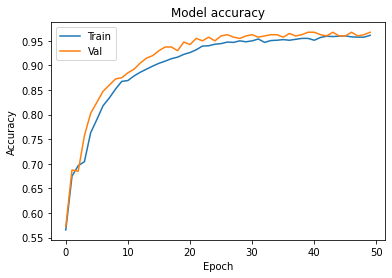

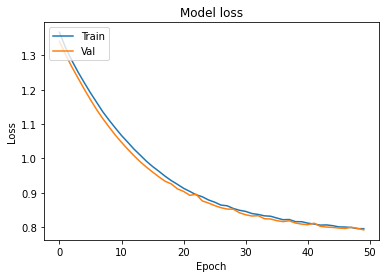

In [54]:
plot_curves(history)

#### Get predictions and find confusion matrix to get the metrics.  

C:\Users\sarde\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b08d57aac8>)

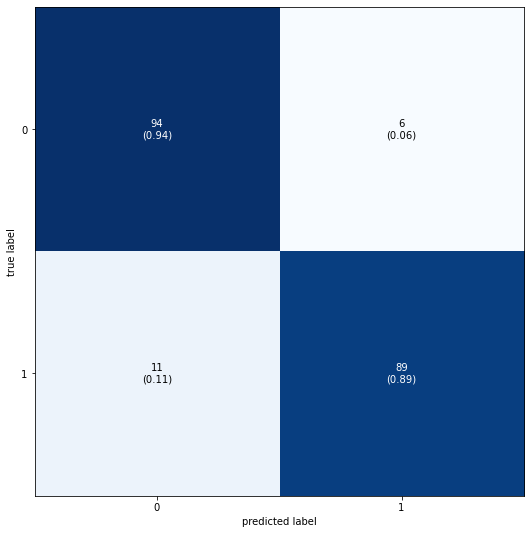

In [55]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       106
           1       0.88      0.94      0.91        94

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

0.91


#### Try Fine Search with Batch Norm

Adding batch norm allows to accelerate training and reduce overfitting. We try a fine search using batch norm to check if we can improve performance. 



In [91]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-2,-4)
    l2_reg = 10**np.random.uniform(-6, -1)
    model = create_model(num_classes,l2_reg, False, True)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)



  0%|          | 0/30 [00:00<?, ?it/s]

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.4043 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/15
1600/1600 [==============================] - 1s 610us/sample - loss: 0.2337 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.7403 - val_sparse_categorical_accuracy: 0.5175
Epoch 3/15
1600/1600 [==============================] - 1s 559us/sample - loss: 0.1931 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.7858 - val_sparse_categorical_accuracy: 0.5250
Epoch 4/15
1600/1600 [==============================] - 1s 580us/sample - loss: 0.1720 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.7104 - val_sparse_categorical_accuracy: 0.5650
Epoch 5/15
1600/1600 [==============================] - 1s 516us/sample - loss: 0.1643 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.5548 - val_sparse_categorical_accuracy: 0.6925
Epoch 6/15
1600/1600 [===



  3%|▎         | 1/30 [00:29<14:01, 29.00s/it]

0.965 0.00033873550952943557 4.777451697904967e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.2096 - sparse_categorical_accuracy: 0.9119 - val_loss: 1.0966 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 559us/sample - loss: 0.1117 - sparse_categorical_accuracy: 0.9625 - val_loss: 1.6182 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 529us/sample - loss: 0.0799 - sparse_categorical_accuracy: 0.9775 - val_loss: 1.6353 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 528us/sample - loss: 0.0780 - sparse_categorical_accuracy: 0.9794 - val_loss: 1.1588 - val_sparse_categorical_accuracy: 0.5175
Epoch 5/15
1600/1600 [==============================] - 1s 525us/sample - loss: 0.0705 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.6157 - val_sparse_cat



  7%|▋         | 2/30 [00:57<13:31, 28.99s/it]

0.975 0.00744720243416951 3.818592530780928e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 7s 5ms/sample - loss: 8.6336 - sparse_categorical_accuracy: 0.9087 - val_loss: 9.1418 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 554us/sample - loss: 8.4738 - sparse_categorical_accuracy: 0.9506 - val_loss: 9.4218 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 546us/sample - loss: 8.3765 - sparse_categorical_accuracy: 0.9631 - val_loss: 9.3439 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/15
1600/1600 [==============================] - 1s 532us/sample - loss: 8.2981 - sparse_categorical_accuracy: 0.9675 - val_loss: 9.0597 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/15
1600/1600 [==============================] - 1s 528us/sample - loss: 8.2170 - sparse_categorical_accuracy: 0.9744 - val_loss: 8.6394 - val_sparse_catego



 10%|█         | 3/30 [01:27<13:03, 29.03s/it]

0.9625 0.001762093344904466 0.02222380595410831
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 7s 4ms/sample - loss: 0.3986 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.7296 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/15
1600/1600 [==============================] - 1s 545us/sample - loss: 0.2439 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.8311 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/15
1600/1600 [==============================] - 1s 527us/sample - loss: 0.2197 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.9102 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/15
1600/1600 [==============================] - 1s 517us/sample - loss: 0.2020 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.8556 - val_sparse_categorical_accuracy: 0.5225
Epoch 5/15
1600/1600 [==============================] - 1s 519us/sample - loss: 0.1799 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.7042 - val_sparse_catego



 13%|█▎        | 4/30 [01:55<12:32, 28.92s/it]

0.955 0.0006720527096075657 0.00015451694984585924
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 7s 5ms/sample - loss: 0.2201 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.7552 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 545us/sample - loss: 0.1127 - sparse_categorical_accuracy: 0.9625 - val_loss: 1.1349 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 539us/sample - loss: 0.0815 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.9560 - val_sparse_categorical_accuracy: 0.5350
Epoch 4/15
1600/1600 [==============================] - 1s 532us/sample - loss: 0.0804 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.6405 - val_sparse_categorical_accuracy: 0.6800
Epoch 5/15
1600/1600 [==============================] - 1s 586us/sample - loss: 0.0622 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.4255 - val_sparse_cat



 17%|█▋        | 5/30 [02:25<12:09, 29.20s/it]

0.97 0.007386198291184139 4.503886557875093e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 7s 5ms/sample - loss: 0.3566 - sparse_categorical_accuracy: 0.8838 - val_loss: 0.7294 - val_sparse_categorical_accuracy: 0.5350
Epoch 2/15
1600/1600 [==============================] - 1s 553us/sample - loss: 0.2434 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/15
1600/1600 [==============================] - 1s 530us/sample - loss: 0.2252 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.5350
Epoch 4/15
1600/1600 [==============================] - 1s 533us/sample - loss: 0.2025 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.7771 - val_sparse_categorical_accuracy: 0.6350
Epoch 5/15
1600/1600 [==============================] - 1s 537us/sample - loss: 0.1919 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.5667 - val_sparse_catego



 20%|██        | 6/30 [02:55<11:44, 29.33s/it]

0.97 0.0016011322382188382 0.00023284888247193707
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.7654 - sparse_categorical_accuracy: 0.9231 - val_loss: 1.2399 - val_sparse_categorical_accuracy: 0.5250
Epoch 2/15
1600/1600 [==============================] - 1s 582us/sample - loss: 0.6862 - sparse_categorical_accuracy: 0.9544 - val_loss: 1.5127 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6623 - sparse_categorical_accuracy: 0.9638 - val_loss: 1.6019 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 539us/sample - loss: 0.6473 - sparse_categorical_accuracy: 0.9744 - val_loss: 1.3570 - val_sparse_categorical_accuracy: 0.5825
Epoch 5/15
1600/1600 [==============================] - 1s 553us/sample - loss: 0.6375 - sparse_categorical_accuracy: 0.9750 - val_loss: 1.0963 - val_sparse_cate



 23%|██▎       | 7/30 [03:26<11:28, 29.95s/it]

0.97 0.0032792150635137063 0.0014741842697323327
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.2213 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 573us/sample - loss: 0.1363 - sparse_categorical_accuracy: 0.9631 - val_loss: 1.1666 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/15
1600/1600 [==============================] - 1s 556us/sample - loss: 0.1191 - sparse_categorical_accuracy: 0.9706 - val_loss: 1.1917 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/15
1600/1600 [==============================] - 1s 553us/sample - loss: 0.1053 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.9020 - val_sparse_categorical_accuracy: 0.5600
Epoch 5/15
1600/1600 [==============================] - 1s 540us/sample - loss: 0.1003 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.4733 - val_sparse_categ



 27%|██▋       | 8/30 [03:58<11:10, 30.47s/it]

0.965 0.0059306840984324006 7.06452730982574e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.3743 - sparse_categorical_accuracy: 0.9181 - val_loss: 1.0104 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 572us/sample - loss: 0.2808 - sparse_categorical_accuracy: 0.9631 - val_loss: 1.4131 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 542us/sample - loss: 0.2507 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.2576 - val_sparse_categorical_accuracy: 0.5250
Epoch 4/15
1600/1600 [==============================] - 1s 539us/sample - loss: 0.2459 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.9211 - val_sparse_categorical_accuracy: 0.6550
Epoch 5/15
1600/1600 [==============================] - 1s 542us/sample - loss: 0.2249 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.6060 - val_sparse_categ



 30%|███       | 9/30 [04:29<10:43, 30.65s/it]

0.97 0.00801402248060675 0.00047308275038140344
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1188 - sparse_categorical_accuracy: 0.6075 - val_loss: 1.0699 - val_sparse_categorical_accuracy: 0.5350
Epoch 2/15
1600/1600 [==============================] - 1s 576us/sample - loss: 0.8290 - sparse_categorical_accuracy: 0.8006 - val_loss: 1.1626 - val_sparse_categorical_accuracy: 0.5150
Epoch 3/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.7447 - sparse_categorical_accuracy: 0.8569 - val_loss: 1.2183 - val_sparse_categorical_accuracy: 0.5175
Epoch 4/15
1600/1600 [==============================] - 1s 569us/sample - loss: 0.7097 - sparse_categorical_accuracy: 0.8725 - val_loss: 1.1673 - val_sparse_categorical_accuracy: 0.5475
Epoch 5/15
1600/1600 [==============================] - 1s 559us/sample - loss: 0.6776 - sparse_categorical_accuracy: 0.8894 - val_loss: 1.0527 - val_sparse_catego



 33%|███▎      | 10/30 [05:01<10:23, 31.17s/it]

0.9125 0.00012329168227791348 0.0010588151636835668
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 23.0011 - sparse_categorical_accuracy: 0.8888 - val_loss: 23.1468 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 565us/sample - loss: 22.1755 - sparse_categorical_accuracy: 0.9563 - val_loss: 22.7819 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 556us/sample - loss: 21.4670 - sparse_categorical_accuracy: 0.9594 - val_loss: 22.1749 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 569us/sample - loss: 20.8003 - sparse_categorical_accuracy: 0.9650 - val_loss: 21.2763 - val_sparse_categorical_accuracy: 0.5475
Epoch 5/15
1600/1600 [==============================] - 1s 571us/sample - loss: 20.1432 - sparse_categorical_accuracy: 0.9725 - val_loss: 20.3009 - val



 37%|███▋      | 11/30 [05:33<09:54, 31.30s/it]

0.9725 0.002595425536095227 0.06063302870501905
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.2896 - sparse_categorical_accuracy: 0.6681 - val_loss: 1.2963 - val_sparse_categorical_accuracy: 0.6375
Epoch 2/15
1600/1600 [==============================] - 1s 578us/sample - loss: 0.9501 - sparse_categorical_accuracy: 0.8969 - val_loss: 1.2739 - val_sparse_categorical_accuracy: 0.6125
Epoch 3/15
1600/1600 [==============================] - 1s 557us/sample - loss: 0.8754 - sparse_categorical_accuracy: 0.9250 - val_loss: 1.2619 - val_sparse_categorical_accuracy: 0.5875
Epoch 4/15
1600/1600 [==============================] - 1s 558us/sample - loss: 0.8611 - sparse_categorical_accuracy: 0.9319 - val_loss: 1.1948 - val_sparse_categorical_accuracy: 0.6475
Epoch 5/15
1600/1600 [==============================] - 1s 555us/sample - loss: 0.8401 - sparse_categorical_accuracy: 0.9350 - val_loss: 1.0829 - val_sparse_catego



 40%|████      | 12/30 [06:05<09:27, 31.52s/it]

0.9575 0.00023089552740953115 0.0017200637935700705
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 8.6918 - sparse_categorical_accuracy: 0.8313 - val_loss: 8.9643 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/15
1600/1600 [==============================] - 1s 582us/sample - loss: 8.5183 - sparse_categorical_accuracy: 0.9137 - val_loss: 9.0796 - val_sparse_categorical_accuracy: 0.5150
Epoch 3/15
1600/1600 [==============================] - 1s 563us/sample - loss: 8.4717 - sparse_categorical_accuracy: 0.9344 - val_loss: 9.1335 - val_sparse_categorical_accuracy: 0.5150
Epoch 4/15
1600/1600 [==============================] - 1s 557us/sample - loss: 8.4361 - sparse_categorical_accuracy: 0.9350 - val_loss: 9.0367 - val_sparse_categorical_accuracy: 0.5575
Epoch 5/15
1600/1600 [==============================] - 1s 561us/sample - loss: 8.4082 - sparse_categorical_accuracy: 0.9388 - val_loss: 8.8630 - val_sparse_ca



 43%|████▎     | 13/30 [06:37<08:59, 31.73s/it]

0.9625 0.0003985610132428364 0.02182495687064198
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.2704 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.7369 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 577us/sample - loss: 0.1570 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.9833 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 563us/sample - loss: 0.1395 - sparse_categorical_accuracy: 0.9519 - val_loss: 1.0316 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 551us/sample - loss: 0.1135 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.5350
Epoch 5/15
1600/1600 [==============================] - 1s 550us/sample - loss: 0.1230 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.5986 - val_sparse_categ



 47%|████▋     | 14/30 [07:09<08:30, 31.89s/it]

0.9725 0.0015277223474092555 1.9198659825491413e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.3453 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.5125
Epoch 2/15
1600/1600 [==============================] - 1s 602us/sample - loss: 0.2152 - sparse_categorical_accuracy: 0.9413 - val_loss: 1.0242 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 577us/sample - loss: 0.1907 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.9882 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/15
1600/1600 [==============================] - 1s 561us/sample - loss: 0.1605 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.7384 - val_sparse_categorical_accuracy: 0.6325
Epoch 5/15
1600/1600 [==============================] - 1s 572us/sample - loss: 0.1525 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.4729 - val_sparse_ca



 50%|█████     | 15/30 [07:42<08:01, 32.13s/it]

0.9725 0.001759366905922034 0.00012824415731024368
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 22.6916 - sparse_categorical_accuracy: 0.8031 - val_loss: 22.9238 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/15
1600/1600 [==============================] - 1s 592us/sample - loss: 22.3570 - sparse_categorical_accuracy: 0.8950 - val_loss: 22.9869 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 572us/sample - loss: 22.1419 - sparse_categorical_accuracy: 0.9294 - val_loss: 22.9134 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 562us/sample - loss: 21.9372 - sparse_categorical_accuracy: 0.9362 - val_loss: 22.6164 - val_sparse_categorical_accuracy: 0.5225
Epoch 5/15
1600/1600 [==============================] - 1s 558us/sample - loss: 21.7585 - sparse_categorical_accuracy: 0.9425 - val_loss: 22.1890 - val_



 53%|█████▎    | 16/30 [08:15<07:32, 32.34s/it]

0.965 0.0006665290763922695 0.05890593655403384
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 0.2904 - sparse_categorical_accuracy: 0.9144 - val_loss: 0.9189 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 591us/sample - loss: 0.2005 - sparse_categorical_accuracy: 0.9531 - val_loss: 1.1543 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1673 - sparse_categorical_accuracy: 0.9688 - val_loss: 1.0886 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/15
1600/1600 [==============================] - 1s 556us/sample - loss: 0.1609 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.8648 - val_sparse_categorical_accuracy: 0.5750
Epoch 5/15
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1490 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.6239 - val_sparse_catego



 57%|█████▋    | 17/30 [08:47<07:01, 32.40s/it]

0.975 0.0038804625439820897 0.0001857896763070955
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.3437 - sparse_categorical_accuracy: 0.8650 - val_loss: 1.8416 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 600us/sample - loss: 1.2003 - sparse_categorical_accuracy: 0.9331 - val_loss: 2.1815 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 570us/sample - loss: 1.1621 - sparse_categorical_accuracy: 0.9525 - val_loss: 2.1692 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 588us/sample - loss: 1.1380 - sparse_categorical_accuracy: 0.9594 - val_loss: 1.9625 - val_sparse_categorical_accuracy: 0.5325
Epoch 5/15
1600/1600 [==============================] - 1s 571us/sample - loss: 1.1262 - sparse_categorical_accuracy: 0.9600 - val_loss: 1.6358 - val_sparse_cate



 60%|██████    | 18/30 [09:21<06:31, 32.64s/it]

0.9725 0.0017329606492475034 0.002687330398870056
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.1794 - sparse_categorical_accuracy: 0.9331 - val_loss: 0.8788 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 618us/sample - loss: 0.1026 - sparse_categorical_accuracy: 0.9663 - val_loss: 1.2177 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 585us/sample - loss: 0.0752 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.3060 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 591us/sample - loss: 0.0758 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.9901 - val_sparse_categorical_accuracy: 0.5450
Epoch 5/15
1600/1600 [==============================] - 1s 602us/sample - loss: 0.0563 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.6073 - val_sparse_cate



 63%|██████▎   | 19/30 [09:55<06:04, 33.12s/it]

0.9775 0.005728520739073729 4.160207718379816e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.7601 - sparse_categorical_accuracy: 0.6119 - val_loss: 0.8173 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/15
1600/1600 [==============================] - 1s 607us/sample - loss: 0.5832 - sparse_categorical_accuracy: 0.8150 - val_loss: 0.7795 - val_sparse_categorical_accuracy: 0.7325
Epoch 3/15
1600/1600 [==============================] - 1s 586us/sample - loss: 0.4840 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.7255 - val_sparse_categorical_accuracy: 0.7375
Epoch 4/15
1600/1600 [==============================] - 1s 581us/sample - loss: 0.4453 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.7900
Epoch 5/15
1600/1600 [==============================] - 1s 585us/sample - loss: 0.4157 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.5627 - val_sparse_cate



 67%|██████▋   | 20/30 [10:29<05:35, 33.55s/it]

0.955 0.000115094412059652 0.0004180516599188814
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 5ms/sample - loss: 0.2037 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.8692 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 608us/sample - loss: 0.1127 - sparse_categorical_accuracy: 0.9625 - val_loss: 1.2050 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 598us/sample - loss: 0.0897 - sparse_categorical_accuracy: 0.9756 - val_loss: 1.1402 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.0834 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.8520 - val_sparse_categorical_accuracy: 0.5600
Epoch 5/15
1600/1600 [==============================] - 1s 568us/sample - loss: 0.0723 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.4132 - val_sparse_categ



 70%|███████   | 21/30 [11:04<05:04, 33.85s/it]

0.975 0.004475876078768491 1.2786062627915434e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 1.0247 - sparse_categorical_accuracy: 0.9112 - val_loss: 1.4747 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/15
1600/1600 [==============================] - 1s 593us/sample - loss: 0.9146 - sparse_categorical_accuracy: 0.9644 - val_loss: 1.7050 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/15
1600/1600 [==============================] - 1s 634us/sample - loss: 0.8993 - sparse_categorical_accuracy: 0.9675 - val_loss: 1.6686 - val_sparse_categorical_accuracy: 0.5375
Epoch 4/15
1600/1600 [==============================] - 1s 646us/sample - loss: 0.8706 - sparse_categorical_accuracy: 0.9769 - val_loss: 1.4717 - val_sparse_categorical_accuracy: 0.6425
Epoch 5/15
1600/1600 [==============================] - 1s 598us/sample - loss: 0.8621 - sparse_categorical_accuracy: 0.9831 - val_loss: 1.2242 - val_sparse_cate



 73%|███████▎  | 22/30 [11:39<04:33, 34.24s/it]

0.9725 0.002836272275088877 0.002092903659529543
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.2922 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.5125
Epoch 2/15
1600/1600 [==============================] - 1s 637us/sample - loss: 0.1650 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.9286 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.1384 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.9590 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/15
1600/1600 [==============================] - 1s 565us/sample - loss: 0.1240 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.7878 - val_sparse_categorical_accuracy: 0.5525
Epoch 5/15
1600/1600 [==============================] - 1s 571us/sample - loss: 0.1127 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.5740 - val_sparse_categ



 77%|███████▋  | 23/30 [12:14<04:00, 34.40s/it]

0.97 0.0016363739854297645 3.235991295189342e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 18.1326 - sparse_categorical_accuracy: 0.8056 - val_loss: 18.3555 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 597us/sample - loss: 17.8287 - sparse_categorical_accuracy: 0.9156 - val_loss: 18.4321 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 589us/sample - loss: 17.6562 - sparse_categorical_accuracy: 0.9413 - val_loss: 18.3630 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 583us/sample - loss: 17.5259 - sparse_categorical_accuracy: 0.9406 - val_loss: 18.1153 - val_sparse_categorical_accuracy: 0.5350
Epoch 5/15
1600/1600 [==============================] - 1s 599us/sample - loss: 17.3957 - sparse_categorical_accuracy: 0.9469 - val_loss: 17.7737 - val_sp



 80%|████████  | 24/30 [12:50<03:29, 34.88s/it]

0.975 0.0007107950831921206 0.04681228396670937
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.7149 - sparse_categorical_accuracy: 0.9144 - val_loss: 1.1847 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 643us/sample - loss: 0.6175 - sparse_categorical_accuracy: 0.9494 - val_loss: 1.4324 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 569us/sample - loss: 0.5970 - sparse_categorical_accuracy: 0.9600 - val_loss: 1.5092 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 568us/sample - loss: 0.5802 - sparse_categorical_accuracy: 0.9625 - val_loss: 1.3160 - val_sparse_categorical_accuracy: 0.5250
Epoch 5/15
1600/1600 [==============================] - 1s 572us/sample - loss: 0.5763 - sparse_categorical_accuracy: 0.9681 - val_loss: 1.0816 - val_sparse_catego



 83%|████████▎ | 25/30 [13:25<02:55, 35.04s/it]

0.97 0.0019913853764241016 0.0012542552381959566
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 5ms/sample - loss: 1.1661 - sparse_categorical_accuracy: 0.6162 - val_loss: 1.1385 - val_sparse_categorical_accuracy: 0.5375
Epoch 2/15
1600/1600 [==============================] - 1s 598us/sample - loss: 0.9037 - sparse_categorical_accuracy: 0.7981 - val_loss: 1.1772 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.8087 - sparse_categorical_accuracy: 0.8462 - val_loss: 1.2184 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/15
1600/1600 [==============================] - 1s 569us/sample - loss: 0.7651 - sparse_categorical_accuracy: 0.8725 - val_loss: 1.1907 - val_sparse_categorical_accuracy: 0.5475
Epoch 5/15
1600/1600 [==============================] - 1s 565us/sample - loss: 0.7311 - sparse_categorical_accuracy: 0.8906 - val_loss: 1.1032 - val_sparse_categ



 87%|████████▋ | 26/30 [14:00<02:19, 34.81s/it]

0.925 0.00010485255568562435 0.0011901262132900281
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.6239 - sparse_categorical_accuracy: 0.9169 - val_loss: 1.1524 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 608us/sample - loss: 0.5183 - sparse_categorical_accuracy: 0.9619 - val_loss: 1.3519 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 597us/sample - loss: 0.4979 - sparse_categorical_accuracy: 0.9688 - val_loss: 1.4038 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 584us/sample - loss: 0.4846 - sparse_categorical_accuracy: 0.9725 - val_loss: 1.2479 - val_sparse_categorical_accuracy: 0.5425
Epoch 5/15
1600/1600 [==============================] - 1s 607us/sample - loss: 0.4845 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.9232 - val_sparse_cat



 90%|█████████ | 27/30 [14:35<01:45, 35.03s/it]

0.9675 0.0029781679994282115 0.0010522906024874525
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.1862 - sparse_categorical_accuracy: 0.9294 - val_loss: 0.7734 - val_sparse_categorical_accuracy: 0.5150
Epoch 2/15
1600/1600 [==============================] - 1s 604us/sample - loss: 0.1085 - sparse_categorical_accuracy: 0.9656 - val_loss: 1.1066 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 614us/sample - loss: 0.0815 - sparse_categorical_accuracy: 0.9775 - val_loss: 1.0645 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/15
1600/1600 [==============================] - 1s 598us/sample - loss: 0.0774 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.6075
Epoch 5/15
1600/1600 [==============================] - 1s 579us/sample - loss: 0.0604 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.4636 - val_sparse_cat



 93%|█████████▎| 28/30 [15:11<01:10, 35.35s/it]

0.975 0.007915179569609089 3.964991577687053e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.3152 - sparse_categorical_accuracy: 0.8769 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.5125
Epoch 2/15
1600/1600 [==============================] - 1s 631us/sample - loss: 0.1899 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.8840 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 596us/sample - loss: 0.1689 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.9409 - val_sparse_categorical_accuracy: 0.5125
Epoch 4/15
1600/1600 [==============================] - 1s 582us/sample - loss: 0.1470 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.8420 - val_sparse_categorical_accuracy: 0.5275
Epoch 5/15
1600/1600 [==============================] - 1s 580us/sample - loss: 0.1406 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.6724 - val_sparse_categ



 97%|█████████▋| 29/30 [15:47<00:35, 35.58s/it]

0.9675 0.0007134273462730262 5.763317555447575e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 22.5642 - sparse_categorical_accuracy: 0.9350 - val_loss: 21.9249 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/15
1600/1600 [==============================] - 1s 597us/sample - loss: 19.9131 - sparse_categorical_accuracy: 0.9631 - val_loss: 20.1008 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/15
1600/1600 [==============================] - 1s 580us/sample - loss: 17.6041 - sparse_categorical_accuracy: 0.9744 - val_loss: 18.2086 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/15
1600/1600 [==============================] - 1s 575us/sample - loss: 15.5702 - sparse_categorical_accuracy: 0.9819 - val_loss: 16.1960 - val_sparse_categorical_accuracy: 0.5075
Epoch 5/15
1600/1600 [==============================] - 1s 571us/sample - loss: 13.7744 - sparse_categorical_accuracy: 0.9869 - val_loss: 14.4549 - val_



100%|██████████| 30/30 [16:23<00:00, 32.79s/it]

0.935 0.009820189037584557 0.06236639635205201


In [92]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [93]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([18, 20, 27,  1], dtype=int64)

In [94]:
logs[:,top4]

array([[9.77500021e-01, 9.75000024e-01, 9.75000024e-01, 9.75000024e-01],
       [5.72852074e-03, 4.47587608e-03, 7.91517957e-03, 7.44720243e-03],
       [4.16020772e-06, 1.27860626e-06, 3.96499158e-06, 3.81859253e-06]])

In [95]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]

#### Final Training 

Now we will train the model using the top performer found using the top performer from the fine search. 


In [96]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg, False, True)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.1939 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.8588 - val_sparse_categorical_accuracy: 0.5075
Epoch 2/50
1600/1600 [==============================] - 1s 610us/sample - loss: 0.1138 - sparse_categorical_accuracy: 0.9625 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.5075
Epoch 3/50
1600/1600 [==============================] - 1s 587us/sample - loss: 0.0938 - sparse_categorical_accuracy: 0.9712 - val_loss: 1.2294 - val_sparse_categorical_accuracy: 0.5075
Epoch 4/50
1600/1600 [==============================] - 1s 581us/sample - loss: 0.0810 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.8739 - val_sparse_categorical_accuracy: 0.5800
Epoch 5/50
1600/1600 [==============================] - 1s 576us/sample - loss: 0.0755 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.6012 - val_sparse_categorical_accuracy: 0.6975
Epoch 6/50
1600/1600 [===

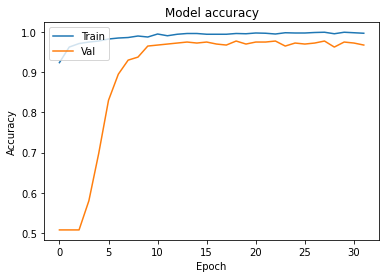

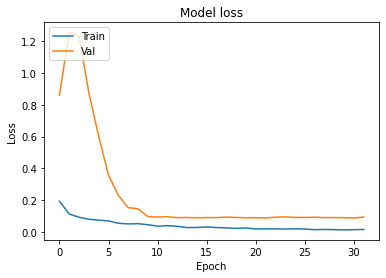

In [97]:
plot_curves(history)

#### Get predictions and find confusion matrix to get the metrics.  

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b0b16e39b0>)

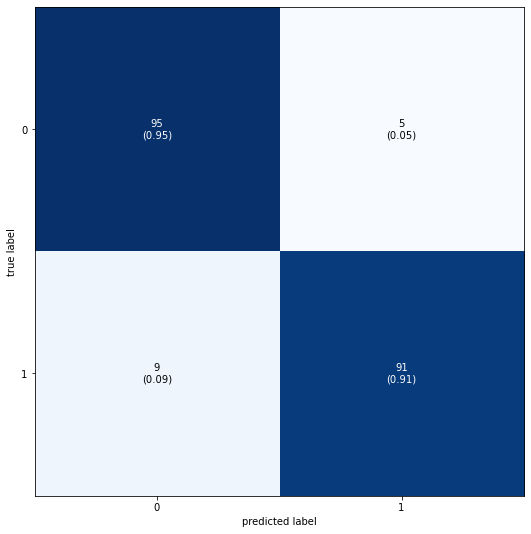

In [98]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)

In [99]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       104
           1       0.91      0.95      0.93        96

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200

0.93


#### Try He Initialization 

Try using He Initialization. Fine search and the steps after that are carried out to check if we get different optimum paramters. Note that Batch norm is not used here. 

In [100]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-2,-4)
    l2_reg = 10**np.random.uniform(-6, -1)
    model = create_model(num_classes,l2_reg, False, False, 'he_uniform')
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)



  0%|          | 0/30 [00:00<?, ?it/s]

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.7367 - sparse_categorical_accuracy: 0.8188 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.9050
Epoch 2/15
1600/1600 [==============================] - 1s 527us/sample - loss: 0.2988 - sparse_categorical_accuracy: 0.9275 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9500
Epoch 3/15
1600/1600 [==============================] - 1s 524us/sample - loss: 0.2516 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.2374 - val_sparse_categorical_accuracy: 0.9575
Epoch 4/15
1600/1600 [==============================] - 1s 530us/sample - loss: 0.2319 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.2283 - val_sparse_categorical_accuracy: 0.9600
Epoch 5/15
1600/1600 [==============================] - 1s 539us/sample - loss: 0.2146 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.2307 - val_sparse_categorical_accuracy: 0.9525
Epoch 6/15
1600/1600 [===



  3%|▎         | 1/30 [00:34<16:39, 34.46s/it]

0.97 0.00577802981720117 0.0001386776045819732
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.4308 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.2893 - val_sparse_categorical_accuracy: 0.8975
Epoch 2/15
1600/1600 [==============================] - 1s 530us/sample - loss: 0.2653 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.2657 - val_sparse_categorical_accuracy: 0.9300
Epoch 3/15
1600/1600 [==============================] - 1s 526us/sample - loss: 0.2289 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.2175 - val_sparse_categorical_accuracy: 0.9425
Epoch 4/15
1600/1600 [==============================] - 1s 528us/sample - loss: 0.2031 - sparse_categorical_accuracy: 0.9344 - val_loss: 0.2042 - val_sparse_categorical_accuracy: 0.9425
Epoch 5/15
1600/1600 [==============================] - 1s 527us/sample - loss: 0.1936 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.2060 - val_sparse_categor



  7%|▋         | 2/30 [01:09<16:06, 34.53s/it]

0.9425 0.0008827404287979808 1.970700251464561e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.4358 - sparse_categorical_accuracy: 0.8231 - val_loss: 0.3472 - val_sparse_categorical_accuracy: 0.8700
Epoch 2/15
1600/1600 [==============================] - 1s 530us/sample - loss: 0.3133 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.2931 - val_sparse_categorical_accuracy: 0.8825
Epoch 3/15
1600/1600 [==============================] - 1s 532us/sample - loss: 0.2748 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.2781 - val_sparse_categorical_accuracy: 0.9125
Epoch 4/15
1600/1600 [==============================] - 1s 528us/sample - loss: 0.2530 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.2413 - val_sparse_categorical_accuracy: 0.9225
Epoch 5/15
1600/1600 [==============================] - 1s 523us/sample - loss: 0.2331 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.2323 - val_sparse_cat



 10%|█         | 3/30 [01:43<15:33, 34.58s/it]

0.9475 0.00036330171743589147 3.26059460775761e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 0.4959 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.2500 - val_sparse_categorical_accuracy: 0.9125
Epoch 2/15
1600/1600 [==============================] - 1s 534us/sample - loss: 0.2331 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.2080 - val_sparse_categorical_accuracy: 0.9400
Epoch 3/15
1600/1600 [==============================] - 1s 554us/sample - loss: 0.1974 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.1908 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/15
1600/1600 [==============================] - 1s 538us/sample - loss: 0.1796 - sparse_categorical_accuracy: 0.9456 - val_loss: 0.1715 - val_sparse_categorical_accuracy: 0.9400
Epoch 5/15
1600/1600 [==============================] - 1s 549us/sample - loss: 0.1749 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.1641 - val_sparse_ca



 13%|█▎        | 4/30 [02:20<15:14, 35.16s/it]

0.9475 0.0009136175688359365 6.0677677581912675e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 0.8068 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.4698 - val_sparse_categorical_accuracy: 0.8925
Epoch 2/15
1600/1600 [==============================] - 1s 575us/sample - loss: 0.4521 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.4177 - val_sparse_categorical_accuracy: 0.9300
Epoch 3/15
1600/1600 [==============================] - 1s 579us/sample - loss: 0.4057 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.4420 - val_sparse_categorical_accuracy: 0.9200
Epoch 4/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.3817 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.9400
Epoch 5/15
1600/1600 [==============================] - 1s 660us/sample - loss: 0.3627 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.3677 - val_sparse_ca



 17%|█▋        | 5/30 [02:57<14:53, 35.73s/it]

0.9575 0.0021373217587287467 0.000330252434655382
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 0.6888 - sparse_categorical_accuracy: 0.6081 - val_loss: 0.4497 - val_sparse_categorical_accuracy: 0.8075
Epoch 2/15
1600/1600 [==============================] - 1s 555us/sample - loss: 0.4215 - sparse_categorical_accuracy: 0.8194 - val_loss: 0.3510 - val_sparse_categorical_accuracy: 0.8650
Epoch 3/15
1600/1600 [==============================] - 1s 552us/sample - loss: 0.3534 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.3057 - val_sparse_categorical_accuracy: 0.8950
Epoch 4/15
1600/1600 [==============================] - 1s 541us/sample - loss: 0.3139 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.2786 - val_sparse_categorical_accuracy: 0.9100
Epoch 5/15
1600/1600 [==============================] - 1s 579us/sample - loss: 0.2871 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.2582 - val_sparse_cat



 20%|██        | 6/30 [03:34<14:28, 36.21s/it]

0.9475 0.00011546787989074746 9.685270857456587e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 0.5412 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.3447 - val_sparse_categorical_accuracy: 0.9225
Epoch 2/15
1600/1600 [==============================] - 1s 538us/sample - loss: 0.2899 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.9375
Epoch 3/15
1600/1600 [==============================] - 1s 535us/sample - loss: 0.2983 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.2582 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/15
1600/1600 [==============================] - 1s 534us/sample - loss: 0.2284 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.2325 - val_sparse_categorical_accuracy: 0.9575
Epoch 5/15
1600/1600 [==============================] - 1s 539us/sample - loss: 0.2156 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.2170 - val_sparse_c



 23%|██▎       | 7/30 [04:10<13:49, 36.07s/it]

0.9725 0.005664947236940586 0.0001597542839151364
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 9s 6ms/sample - loss: 5.4962 - sparse_categorical_accuracy: 0.8081 - val_loss: 5.3222 - val_sparse_categorical_accuracy: 0.8825
Epoch 2/15
1600/1600 [==============================] - 1s 541us/sample - loss: 5.2546 - sparse_categorical_accuracy: 0.9038 - val_loss: 5.2499 - val_sparse_categorical_accuracy: 0.9050
Epoch 3/15
1600/1600 [==============================] - 1s 535us/sample - loss: 5.1977 - sparse_categorical_accuracy: 0.9312 - val_loss: 5.1717 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/15
1600/1600 [==============================] - 1s 535us/sample - loss: 5.1531 - sparse_categorical_accuracy: 0.9394 - val_loss: 5.1564 - val_sparse_categorical_accuracy: 0.9350
Epoch 5/15
1600/1600 [==============================] - 1s 537us/sample - loss: 5.1369 - sparse_categorical_accuracy: 0.9413 - val_loss: 5.1204 - val_sparse_cate



 27%|██▋       | 8/30 [04:46<13:10, 35.92s/it]

0.9375 0.0016756472751727508 0.007853317076531282
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 1.8408 - sparse_categorical_accuracy: 0.7725 - val_loss: 1.6709 - val_sparse_categorical_accuracy: 0.8650
Epoch 2/15
1600/1600 [==============================] - 1s 564us/sample - loss: 1.6632 - sparse_categorical_accuracy: 0.8656 - val_loss: 1.6448 - val_sparse_categorical_accuracy: 0.8700
Epoch 3/15
1600/1600 [==============================] - 1s 605us/sample - loss: 1.6091 - sparse_categorical_accuracy: 0.9013 - val_loss: 1.5752 - val_sparse_categorical_accuracy: 0.9200
Epoch 4/15
1600/1600 [==============================] - 1s 549us/sample - loss: 1.5777 - sparse_categorical_accuracy: 0.9169 - val_loss: 1.5622 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/15
1600/1600 [==============================] - 1s 538us/sample - loss: 1.5544 - sparse_categorical_accuracy: 0.9231 - val_loss: 1.5607 - val_sparse_cat



 30%|███       | 9/30 [05:22<12:35, 35.98s/it]

0.9375 0.0005292370540430307 0.002102038627566575
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 1.4548 - sparse_categorical_accuracy: 0.8250 - val_loss: 1.3356 - val_sparse_categorical_accuracy: 0.9025
Epoch 2/15
1600/1600 [==============================] - 1s 535us/sample - loss: 1.3157 - sparse_categorical_accuracy: 0.8950 - val_loss: 1.2823 - val_sparse_categorical_accuracy: 0.9200
Epoch 3/15
1600/1600 [==============================] - 1s 537us/sample - loss: 1.2701 - sparse_categorical_accuracy: 0.9212 - val_loss: 1.2566 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/15
1600/1600 [==============================] - 1s 539us/sample - loss: 1.2425 - sparse_categorical_accuracy: 0.9325 - val_loss: 1.2377 - val_sparse_categorical_accuracy: 0.9500
Epoch 5/15
1600/1600 [==============================] - 1s 536us/sample - loss: 1.2242 - sparse_categorical_accuracy: 0.9413 - val_loss: 1.2172 - val_sparse_cat



 33%|███▎      | 10/30 [05:58<11:59, 35.99s/it]

0.96 0.0007706275590196288 0.0016132068522539756
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 0.4578 - sparse_categorical_accuracy: 0.8288 - val_loss: 0.3282 - val_sparse_categorical_accuracy: 0.9125
Epoch 2/15
1600/1600 [==============================] - 1s 564us/sample - loss: 0.3242 - sparse_categorical_accuracy: 0.8956 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/15
1600/1600 [==============================] - 1s 546us/sample - loss: 0.2831 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.2577 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/15
1600/1600 [==============================] - 1s 539us/sample - loss: 0.2587 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.2416 - val_sparse_categorical_accuracy: 0.9425
Epoch 5/15
1600/1600 [==============================] - 1s 538us/sample - loss: 0.2410 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.2276 - val_sparse_cate



 37%|███▋      | 11/30 [06:34<11:24, 36.03s/it]

0.9625 0.0005162810738005957 5.632861724272285e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 29.6797 - sparse_categorical_accuracy: 0.8281 - val_loss: 28.2330 - val_sparse_categorical_accuracy: 0.9125
Epoch 2/15
1600/1600 [==============================] - 1s 542us/sample - loss: 27.2555 - sparse_categorical_accuracy: 0.9156 - val_loss: 26.2462 - val_sparse_categorical_accuracy: 0.9225
Epoch 3/15
1600/1600 [==============================] - 1s 536us/sample - loss: 25.3615 - sparse_categorical_accuracy: 0.9337 - val_loss: 24.4315 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/15
1600/1600 [==============================] - 1s 539us/sample - loss: 23.6147 - sparse_categorical_accuracy: 0.9425 - val_loss: 22.7506 - val_sparse_categorical_accuracy: 0.9500
Epoch 5/15
1600/1600 [==============================] - 1s 556us/sample - loss: 21.9789 - sparse_categorical_accuracy: 0.9550 - val_loss: 21.2546 - val



 40%|████      | 12/30 [07:11<10:53, 36.31s/it]

0.955 0.007603334906345555 0.046968430432505925
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 7.0125 - sparse_categorical_accuracy: 0.8056 - val_loss: 6.7934 - val_sparse_categorical_accuracy: 0.8625
Epoch 2/15
1600/1600 [==============================] - 1s 667us/sample - loss: 6.7101 - sparse_categorical_accuracy: 0.9019 - val_loss: 6.6376 - val_sparse_categorical_accuracy: 0.9225
Epoch 3/15
1600/1600 [==============================] - 1s 550us/sample - loss: 6.6029 - sparse_categorical_accuracy: 0.9337 - val_loss: 6.6024 - val_sparse_categorical_accuracy: 0.9200
Epoch 4/15
1600/1600 [==============================] - 1s 539us/sample - loss: 6.5385 - sparse_categorical_accuracy: 0.9438 - val_loss: 6.5189 - val_sparse_categorical_accuracy: 0.9475
Epoch 5/15
1600/1600 [==============================] - 1s 538us/sample - loss: 6.4923 - sparse_categorical_accuracy: 0.9400 - val_loss: 6.4597 - val_sparse_categ



 43%|████▎     | 13/30 [07:49<10:28, 36.95s/it]

0.955 0.0031642418277492757 0.010185165887279735
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 0.7264 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.4051 - val_sparse_categorical_accuracy: 0.9100
Epoch 2/15
1600/1600 [==============================] - 1s 546us/sample - loss: 0.3994 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.3588 - val_sparse_categorical_accuracy: 0.9525
Epoch 3/15
1600/1600 [==============================] - 1s 546us/sample - loss: 0.3651 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.3354 - val_sparse_categorical_accuracy: 0.9575
Epoch 4/15
1600/1600 [==============================] - 1s 559us/sample - loss: 0.3528 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.3276 - val_sparse_categorical_accuracy: 0.9525
Epoch 5/15
1600/1600 [==============================] - 1s 544us/sample - loss: 0.3076 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.3080 - val_sparse_cate



 47%|████▋     | 14/30 [08:28<10:02, 37.63s/it]

0.9675 0.0030070841171079958 0.0002743041941158186
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 18.6683 - sparse_categorical_accuracy: 0.8006 - val_loss: 18.2635 - val_sparse_categorical_accuracy: 0.9125
Epoch 2/15
1600/1600 [==============================] - 1s 544us/sample - loss: 18.1878 - sparse_categorical_accuracy: 0.9013 - val_loss: 18.0252 - val_sparse_categorical_accuracy: 0.9350
Epoch 3/15
1600/1600 [==============================] - 1s 545us/sample - loss: 17.9469 - sparse_categorical_accuracy: 0.9250 - val_loss: 17.8234 - val_sparse_categorical_accuracy: 0.9475
Epoch 4/15
1600/1600 [==============================] - 1s 572us/sample - loss: 17.7488 - sparse_categorical_accuracy: 0.9294 - val_loss: 17.6341 - val_sparse_categorical_accuracy: 0.9450
Epoch 5/15
1600/1600 [==============================] - 1s 553us/sample - loss: 17.5361 - sparse_categorical_accuracy: 0.9475 - val_loss: 17.4369 - val



 50%|█████     | 15/30 [09:08<09:31, 38.08s/it]

0.945 0.001834562737569804 0.028432779722585344
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 0.8541 - sparse_categorical_accuracy: 0.8406 - val_loss: 0.5188 - val_sparse_categorical_accuracy: 0.9325
Epoch 2/15
1600/1600 [==============================] - 1s 546us/sample - loss: 0.5195 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.4797 - val_sparse_categorical_accuracy: 0.9550
Epoch 3/15
1600/1600 [==============================] - 1s 559us/sample - loss: 0.4816 - sparse_categorical_accuracy: 0.9456 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/15
1600/1600 [==============================] - 1s 570us/sample - loss: 0.4741 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.4523 - val_sparse_categorical_accuracy: 0.9600
Epoch 5/15
1600/1600 [==============================] - 1s 563us/sample - loss: 0.4370 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.4573 - val_sparse_categ



 53%|█████▎    | 16/30 [09:46<08:54, 38.19s/it]

0.965 0.008366689123479676 0.0005008409721048519
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 1.0462 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.5182 - val_sparse_categorical_accuracy: 0.9275
Epoch 2/15
1600/1600 [==============================] - 1s 583us/sample - loss: 0.5074 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.4616 - val_sparse_categorical_accuracy: 0.9500
Epoch 3/15
1600/1600 [==============================] - 1s 559us/sample - loss: 0.4505 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.4409 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/15
1600/1600 [==============================] - 1s 565us/sample - loss: 0.4194 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.4403 - val_sparse_categorical_accuracy: 0.9450
Epoch 5/15
1600/1600 [==============================] - 1s 598us/sample - loss: 0.4199 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.4185 - val_sparse_cate



 57%|█████▋    | 17/30 [10:25<08:18, 38.32s/it]

0.96 0.008687153577158838 0.0004572934100099932
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 7ms/sample - loss: 1.9921 - sparse_categorical_accuracy: 0.7337 - val_loss: 1.7960 - val_sparse_categorical_accuracy: 0.8800
Epoch 2/15
1600/1600 [==============================] - 1s 553us/sample - loss: 1.7870 - sparse_categorical_accuracy: 0.8562 - val_loss: 1.7255 - val_sparse_categorical_accuracy: 0.8900
Epoch 3/15
1600/1600 [==============================] - 1s 558us/sample - loss: 1.7293 - sparse_categorical_accuracy: 0.8819 - val_loss: 1.6955 - val_sparse_categorical_accuracy: 0.8900
Epoch 4/15
1600/1600 [==============================] - 1s 558us/sample - loss: 1.7003 - sparse_categorical_accuracy: 0.8931 - val_loss: 1.6665 - val_sparse_categorical_accuracy: 0.9050
Epoch 5/15
1600/1600 [==============================] - 1s 579us/sample - loss: 1.6772 - sparse_categorical_accuracy: 0.8981 - val_loss: 1.6514 - val_sparse_categ



 60%|██████    | 18/30 [11:03<07:41, 38.43s/it]

0.9325 0.00014727909660568834 0.0021719892696524406
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 7ms/sample - loss: 0.4103 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.2515 - val_sparse_categorical_accuracy: 0.9150
Epoch 2/15
1600/1600 [==============================] - 1s 545us/sample - loss: 0.2440 - sparse_categorical_accuracy: 0.9131 - val_loss: 0.2106 - val_sparse_categorical_accuracy: 0.9300
Epoch 3/15
1600/1600 [==============================] - 1s 573us/sample - loss: 0.2034 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/15
1600/1600 [==============================] - 1s 562us/sample - loss: 0.1766 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.2171 - val_sparse_categorical_accuracy: 0.9225
Epoch 5/15
1600/1600 [==============================] - 1s 556us/sample - loss: 0.1623 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.1575 - val_sparse_c



 63%|██████▎   | 19/30 [11:42<07:02, 38.39s/it]

0.965 0.000930982600371908 2.9151132055724327e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 7ms/sample - loss: 0.5195 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.4135 - val_sparse_categorical_accuracy: 0.8500
Epoch 2/15
1600/1600 [==============================] - 1s 568us/sample - loss: 0.3956 - sparse_categorical_accuracy: 0.8756 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.8800
Epoch 3/15
1600/1600 [==============================] - 1s 581us/sample - loss: 0.3456 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.3287 - val_sparse_categorical_accuracy: 0.9075
Epoch 4/15
1600/1600 [==============================] - 1s 568us/sample - loss: 0.3204 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.9125
Epoch 5/15
1600/1600 [==============================] - 1s 571us/sample - loss: 0.3004 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.2930 - val_sparse_cat



 67%|██████▋   | 20/30 [12:20<06:25, 38.52s/it]

0.96 0.0003138469368518641 9.251033540233525e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 0.7423 - sparse_categorical_accuracy: 0.8025 - val_loss: 0.3172 - val_sparse_categorical_accuracy: 0.9000
Epoch 2/15
1600/1600 [==============================] - 1s 625us/sample - loss: 0.3172 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.2622 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.2657 - sparse_categorical_accuracy: 0.9269 - val_loss: 0.2308 - val_sparse_categorical_accuracy: 0.9450
Epoch 4/15
1600/1600 [==============================] - 1s 564us/sample - loss: 0.2301 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.2169 - val_sparse_categorical_accuracy: 0.9550
Epoch 5/15
1600/1600 [==============================] - 1s 572us/sample - loss: 0.2217 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.2138 - val_sparse_cate

0.965 0.0018407467308465967 8.265370206297737e-05


 70%|███████   | 21/30 [13:00<05:48, 38.70s/it]

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 7ms/sample - loss: 0.5995 - sparse_categorical_accuracy: 0.7663 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.8375
Epoch 2/15
1600/1600 [==============================] - 1s 584us/sample - loss: 0.4351 - sparse_categorical_accuracy: 0.8569 - val_loss: 0.3921 - val_sparse_categorical_accuracy: 0.8650
Epoch 3/15
1600/1600 [==============================] - 1s 637us/sample - loss: 0.3872 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.3647 - val_sparse_categorical_accuracy: 0.9125
Epoch 4/15
1600/1600 [==============================] - 1s 565us/sample - loss: 0.3575 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.3398 - val_sparse_categorical_accuracy: 0.9200
Epoch 5/15
1600/1600 [==============================] - 1s 585us/sample - loss: 0.3374 - sparse_categorical_accuracy: 0.9194 - val_loss: 0.3258 - val_sparse_categorical_accuracy: 0.9200
Epoch 6/15
1600/1600 [==



 73%|███████▎  | 22/30 [13:39<05:12, 39.00s/it]

0.94 0.0003683625420711011 0.00015535705473831014
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 0.6027 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.4546 - val_sparse_categorical_accuracy: 0.8900
Epoch 2/15
1600/1600 [==============================] - 1s 577us/sample - loss: 0.4184 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.3937 - val_sparse_categorical_accuracy: 0.9100
Epoch 3/15
1600/1600 [==============================] - 1s 569us/sample - loss: 0.3717 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.3473 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/15
1600/1600 [==============================] - 1s 575us/sample - loss: 0.3427 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.3277 - val_sparse_categorical_accuracy: 0.9475
Epoch 5/15
1600/1600 [==============================] - 1s 591us/sample - loss: 0.3263 - sparse_categorical_accuracy: 0.9319 - val_loss: 0.3135 - val_sparse_cat



 77%|███████▋  | 23/30 [14:18<04:32, 38.98s/it]

0.9575 0.0005303144059849948 0.0002013468159719442
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 0.5673 - sparse_categorical_accuracy: 0.7731 - val_loss: 0.2577 - val_sparse_categorical_accuracy: 0.9100
Epoch 2/15
1600/1600 [==============================] - 1s 637us/sample - loss: 0.2618 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.2705 - val_sparse_categorical_accuracy: 0.9100
Epoch 3/15
1600/1600 [==============================] - 1s 577us/sample - loss: 0.2305 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.2044 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/15
1600/1600 [==============================] - 1s 600us/sample - loss: 0.2000 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.2015 - val_sparse_categorical_accuracy: 0.9450
Epoch 5/15
1600/1600 [==============================] - 1s 592us/sample - loss: 0.1812 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.1799 - val_sparse_ca



 80%|████████  | 24/30 [14:59<03:57, 39.52s/it]

0.96 0.0009223451932521895 3.0111415005661137e-06
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 7ms/sample - loss: 0.5503 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.3712 - val_sparse_categorical_accuracy: 0.8425
Epoch 2/15
1600/1600 [==============================] - 1s 635us/sample - loss: 0.3442 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.2981 - val_sparse_categorical_accuracy: 0.8950
Epoch 3/15
1600/1600 [==============================] - 1s 627us/sample - loss: 0.2877 - sparse_categorical_accuracy: 0.8956 - val_loss: 0.2708 - val_sparse_categorical_accuracy: 0.9125
Epoch 4/15
1600/1600 [==============================] - 1s 668us/sample - loss: 0.2526 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2441 - val_sparse_categorical_accuracy: 0.9200
Epoch 5/15
1600/1600 [==============================] - 1s 579us/sample - loss: 0.2320 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.2245 - val_sparse_cat



 83%|████████▎ | 25/30 [15:40<03:20, 40.12s/it]

0.9425 0.0003796503985833124 1.1087832676170107e-05
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 2.2684 - sparse_categorical_accuracy: 0.7487 - val_loss: 2.1475 - val_sparse_categorical_accuracy: 0.8325
Epoch 2/15
1600/1600 [==============================] - 1s 553us/sample - loss: 2.1164 - sparse_categorical_accuracy: 0.8438 - val_loss: 2.0884 - val_sparse_categorical_accuracy: 0.8500
Epoch 3/15
1600/1600 [==============================] - 1s 552us/sample - loss: 2.0717 - sparse_categorical_accuracy: 0.8694 - val_loss: 2.0601 - val_sparse_categorical_accuracy: 0.8650
Epoch 4/15
1600/1600 [==============================] - 1s 560us/sample - loss: 2.0445 - sparse_categorical_accuracy: 0.8825 - val_loss: 2.0402 - val_sparse_categorical_accuracy: 0.8725
Epoch 5/15
1600/1600 [==============================] - 1s 549us/sample - loss: 2.0221 - sparse_categorical_accuracy: 0.8900 - val_loss: 2.0250 - val_sparse_c



 87%|████████▋ | 26/30 [16:21<02:41, 40.38s/it]

0.915 0.00010531080419573483 0.002698522479327534
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 4.2216 - sparse_categorical_accuracy: 0.8194 - val_loss: 4.1022 - val_sparse_categorical_accuracy: 0.8225
Epoch 2/15
1600/1600 [==============================] - 1s 597us/sample - loss: 3.9775 - sparse_categorical_accuracy: 0.9137 - val_loss: 3.9302 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/15
1600/1600 [==============================] - 1s 580us/sample - loss: 3.9171 - sparse_categorical_accuracy: 0.9356 - val_loss: 3.9464 - val_sparse_categorical_accuracy: 0.9175
Epoch 4/15
1600/1600 [==============================] - 1s 565us/sample - loss: 3.8875 - sparse_categorical_accuracy: 0.9381 - val_loss: 3.8785 - val_sparse_categorical_accuracy: 0.9450
Epoch 5/15
1600/1600 [==============================] - 1s 553us/sample - loss: 3.8492 - sparse_categorical_accuracy: 0.9513 - val_loss: 3.8457 - val_sparse_cat



 90%|█████████ | 27/30 [17:02<02:00, 40.32s/it]

0.96 0.002693144484606442 0.0058495663103849144
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 19.9356 - sparse_categorical_accuracy: 0.8400 - val_loss: 19.7691 - val_sparse_categorical_accuracy: 0.9125
Epoch 2/15
1600/1600 [==============================] - 1s 557us/sample - loss: 19.7183 - sparse_categorical_accuracy: 0.9087 - val_loss: 19.6376 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/15
1600/1600 [==============================] - 1s 553us/sample - loss: 19.5813 - sparse_categorical_accuracy: 0.9325 - val_loss: 19.5232 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/15
1600/1600 [==============================] - 1s 555us/sample - loss: 19.4692 - sparse_categorical_accuracy: 0.9356 - val_loss: 19.4186 - val_sparse_categorical_accuracy: 0.9450
Epoch 5/15
1600/1600 [==============================] - 1s 553us/sample - loss: 19.3615 - sparse_categorical_accuracy: 0.9481 - val_loss: 19.3110 - val_sp



 93%|█████████▎| 28/30 [17:42<01:20, 40.19s/it]

0.9575 0.0007849439163576307 0.030694158488986222
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 11s 7ms/sample - loss: 0.8990 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.8825
Epoch 2/15
1600/1600 [==============================] - 1s 590us/sample - loss: 0.6090 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.5987 - val_sparse_categorical_accuracy: 0.9125
Epoch 3/15
1600/1600 [==============================] - 1s 583us/sample - loss: 0.5692 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.5576 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/15
1600/1600 [==============================] - 1s 574us/sample - loss: 0.5460 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.5502 - val_sparse_categorical_accuracy: 0.9400
Epoch 5/15
1600/1600 [==============================] - 1s 542us/sample - loss: 0.5196 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.5239 - val_sparse_cat



 97%|█████████▋| 29/30 [18:22<00:40, 40.27s/it]

0.9575 0.000717646963667178 0.0005340962959732322
Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 10s 6ms/sample - loss: 0.6731 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.2039 - val_sparse_categorical_accuracy: 0.9250
Epoch 2/15
1600/1600 [==============================] - 1s 551us/sample - loss: 0.2293 - sparse_categorical_accuracy: 0.9194 - val_loss: 0.1666 - val_sparse_categorical_accuracy: 0.9600
Epoch 3/15
1600/1600 [==============================] - 1s 553us/sample - loss: 0.1504 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.1207 - val_sparse_categorical_accuracy: 0.9625
Epoch 4/15
1600/1600 [==============================] - 1s 549us/sample - loss: 0.1443 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.1371 - val_sparse_categorical_accuracy: 0.9525
Epoch 5/15
1600/1600 [==============================] - 1s 551us/sample - loss: 0.1175 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.1211 - val_sparse_cat



100%|██████████| 30/30 [19:01<00:00, 38.04s/it]

0.9625 0.009169899130199007 5.555899178672394e-06


In [101]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [102]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([ 6,  0, 13, 20], dtype=int64)

In [103]:
logs[:,top4]

array([[9.72500026e-01, 9.70000029e-01, 9.67499971e-01, 9.64999974e-01],
       [5.66494724e-03, 5.77802982e-03, 3.00708412e-03, 1.84074673e-03],
       [1.59754284e-04, 1.38677605e-04, 2.74304194e-04, 8.26537021e-05]])

In [104]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]

#### Final Training 

Now we will train the model using the top performer found using the top performer from the fine search. 


In [105]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg, False, False, 'he_uniform')
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 12s 7ms/sample - loss: 0.6546 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.3865 - val_sparse_categorical_accuracy: 0.8975
Epoch 2/50
1600/1600 [==============================] - 1s 555us/sample - loss: 0.2827 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.2484 - val_sparse_categorical_accuracy: 0.9575
Epoch 3/50
1600/1600 [==============================] - 1s 587us/sample - loss: 0.2627 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.2322 - val_sparse_categorical_accuracy: 0.9600
Epoch 4/50
1600/1600 [==============================] - 1s 541us/sample - loss: 0.2297 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.2210 - val_sparse_categorical_accuracy: 0.9625
Epoch 5/50
1600/1600 [==============================] - 1s 548us/sample - loss: 0.2146 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.2158 - val_sparse_categorical_accuracy: 0.9600
Epoch 6/50
1600/1600 [==

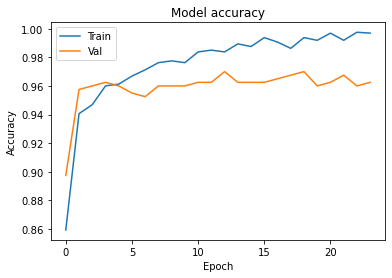

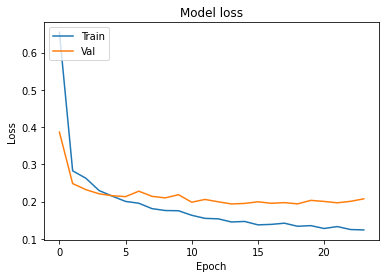

In [106]:
plot_curves(history)

#### Get predictions and find confusion matrix to get the metrics.  

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b0c6bda908>)

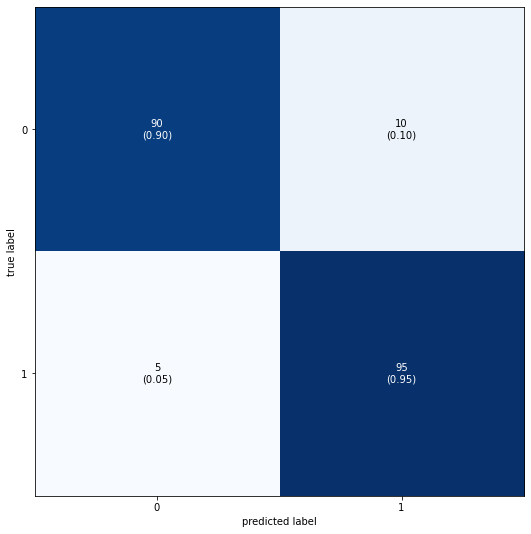

In [107]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)

In [108]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        95
           1       0.95      0.90      0.93       105

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.93       200

0.925


In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tr_gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,\
 	height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,\
 	horizontal_flip=True, fill_mode="reflect")
val_gen = ImageDataGenerator()

train_datagen = tr_gen.flow(X_train,y_train, batch_size=BATCH_SIZE, shuffle=True)
valid_datagen = val_gen.flow(X_val,y_val,batch_size=BATCH_SIZE, shuffle=True)
tsdata = ImageDataGenerator()
test_datagen = tsdata.flow(X_test,batch_size=BATCH_SIZE, shuffle=False)

In [115]:
LR = 5.72852074e-03
L2_REG = 4.16020772e-06
model = create_model(num_classes,l2_reg, False, True)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [119]:
hist = model.fit_generator(train_datagen,steps_per_epoch=train_datagen.n//train_datagen.batch_size,epochs=50,\
                           validation_data=valid_datagen, validation_steps=valid_datagen.n//valid_datagen.batch_size\
                              , callbacks=[es])

Epoch 1/50
50/50 [==============================] - 2s 44ms/step - loss: 0.1403 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.1958 - val_sparse_categorical_accuracy: 0.9583
Epoch 2/50
50/50 [==============================] - 2s 43ms/step - loss: 0.1351 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.1386 - val_sparse_categorical_accuracy: 0.9792
Epoch 3/50
50/50 [==============================] - 2s 42ms/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.1412 - val_sparse_categorical_accuracy: 0.9740
Epoch 4/50
50/50 [==============================] - 2s 41ms/step - loss: 0.1391 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1343 - val_sparse_categorical_accuracy: 0.9766
Epoch 5/50
50/50 [==============================] - 2s 41ms/step - loss: 0.1402 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1421 - val_sparse_categorical_accuracy: 0.9714
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: 0.1276 - sparse_categorical_accu

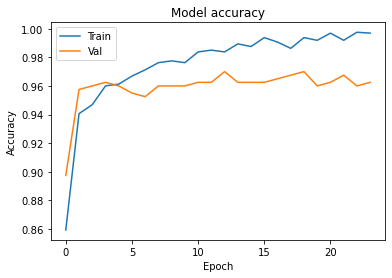

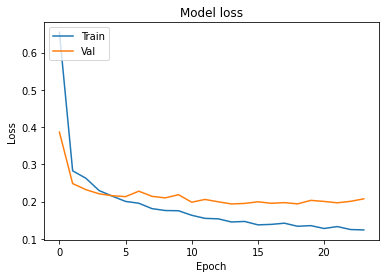

In [120]:
plot_curves(history)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       103
           1       0.93      0.96      0.94        97

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200

0.945


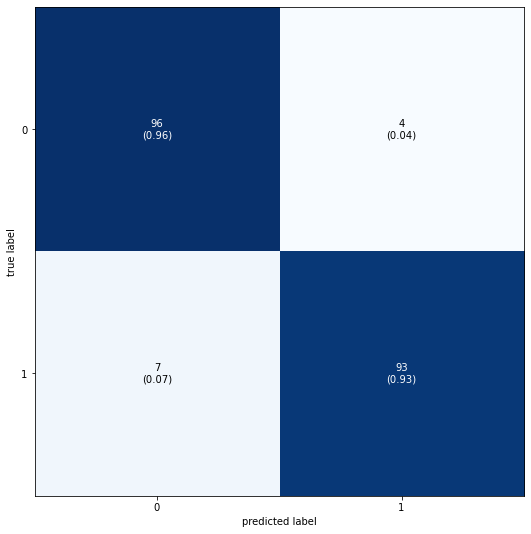

In [121]:
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))